In [1]:
import numpy as np
import matplotlib.pyplot as pl
import json
from sklearn.utils import class_weight
from keras import Sequential, activations, Input
from keras.models import Model
from keras.layers import BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.abspath(os.path.join('../src/'))

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import (
    recall_precision_fscore_from_confusion_matrix
)

from labelsUtils import (
    Label,
)

from regionUtils import (
    vietnam_labels_coordinates,
)

from rasterUtils import (
    make_dataset_from_raster_files,
)

from convNetUtils import (
    cross_validation,
    plot_confusion_matrix,
    hold_out_split_dataset,
    separate_data_into_images_and_labels,
    evaluate_model,
    add_ndvi_to_dataset,
    add_mndwi_to_dataset,
    add_evi2_to_dataset,
    add_bu_to_dataset,
)

/home/simon/miniconda3/envs/earthEngine/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
from enum import Enum

class Band(Enum):
    COASTAL_AEROSOL = 0
    BLUE = 1
    GREEN = 2
    RED = 3
    NIR = 4
    SWIR1 = 5
    SWIR2 = 6
    PANCHROMATIC = 7
    CIRRUS = 8
    TIRS1 = 9
    TIRS2 = 10
    NDVI = 11
    MNDWI = 12
    EVI2 = 13
    BU = 14

In [3]:
NB_TESTS = 4
EPOCHS = 2000
DATA_ROOT_PATH ='../data/'
LABELS_COORDINATES = vietnam_labels_coordinates()

In [4]:
labels = [
    Label.COFFEE,
    Label.NATIVEVEGE,
    Label.URBAN,
    Label.WATER,
    Label.PEPPER,
    Label.TEA,
]

In [5]:
NB_PIXEL_AROUND=4

dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2017_january_march/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)
add_ndvi_to_dataset(dataset)
add_mndwi_to_dataset(dataset)
add_evi2_to_dataset(dataset)
add_bu_to_dataset(dataset)

This notebook uses :

```
AUGMENTATIONS = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625,
        scale_limit=0,
        rotate_limit=0,
        p=0.8
    ),
    RandomRotate90(p=0.5),
])
```

# COASTAL_AEROSOL, BLUE, GREEN, RED, NIR, SWIR1, SWIR2, PANCHROMATIC

In [6]:
bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value,
    Band.PANCHROMATIC.value,
]

model_name = "coastal_aerosol_blue_green_red_nir_swir1_swir2_panchromatic"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 9, 9, 8)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 8)           32        
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          2336      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          3

57/57 [==============================] - 0s 6ms/step - loss: 0.3380 - accuracy: 0.8437 - val_loss: 0.7079 - val_accuracy: 0.7581
Epoch 101/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.3055 - accuracy: 0.8263 - val_loss: 0.6852 - val_accuracy: 0.7663
Epoch 102/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2756 - accuracy: 0.8156 - val_loss: 0.7063 - val_accuracy: 0.7750
Epoch 103/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2379 - accuracy: 0.8636 - val_loss: 0.6605 - val_accuracy: 0.7872
Epoch 104/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.2491 - accuracy: 0.8480 - val_loss: 0.7673 - val_accuracy: 0.7564
Epoch 105/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.2508 - accuracy: 0.8389 - val_loss: 0.7351 - val_accuracy: 0.7534
Epoch 106/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.2583 - accuracy: 0.8642 - val_loss: 0.7492 - val_accuracy: 0.7664
Epoch 1

Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1486 - accuracy: 0.9003 - val_loss: 0.7323 - val_accuracy: 0.8122
Epoch 158/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1316 - accuracy: 0.9124 - val_loss: 0.8126 - val_accuracy: 0.7761
Epoch 159/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2052 - accuracy: 0.8694 - val_loss: 0.7492 - val_accuracy: 0.7856
Epoch 160/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1710 - accuracy: 0.8858 - val_loss: 0.6848 - val_accuracy: 0.8105
Epoch 161/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1490 - accuracy: 0.9039 - val_loss: 0.7481 - val_accuracy: 0.8093
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1558 - accuracy: 0.8929 - val_loss: 0.7147 - val_accuracy: 0.8192
Epoch 163/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2266 - accuracy: 0.8987 - val_loss: 0.8099 - val_accuracy:

Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1776 - accuracy: 0.9019 - val_loss: 0.7642 - val_accuracy: 0.7877
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1670 - accuracy: 0.8768 - val_loss: 0.6948 - val_accuracy: 0.8058
Epoch 216/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1152 - accuracy: 0.9259 - val_loss: 0.7604 - val_accuracy: 0.8021
Epoch 217/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1266 - accuracy: 0.9194 - val_loss: 0.7198 - val_accuracy: 0.8237
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1038 - accuracy: 0.9389 - val_loss: 0.7889 - val_accuracy: 0.8168
Epoch 219/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1199 - accuracy: 0.9214 - val_loss: 0.7544 - val_accuracy: 0.8115
Epoch 220/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1399 - accuracy: 0.9108 - val_loss: 0.7695 - val_accuracy:

Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0812 - accuracy: 0.9499 - val_loss: 0.8700 - val_accuracy: 0.7980
Epoch 272/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0635 - accuracy: 0.9540 - val_loss: 0.8098 - val_accuracy: 0.8303
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0781 - accuracy: 0.9567 - val_loss: 0.8931 - val_accuracy: 0.8101
Epoch 274/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1128 - accuracy: 0.9383 - val_loss: 1.0402 - val_accuracy: 0.7820
Epoch 275/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1111 - accuracy: 0.9124 - val_loss: 0.8309 - val_accuracy: 0.8226
Epoch 276/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0746 - accuracy: 0.9468 - val_loss: 0.8615 - val_accuracy: 0.8082
Epoch 277/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1270 - accuracy: 0.9358 - val_loss: 0.8918 - val_accuracy:

Epoch 328/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0738 - accuracy: 0.9561 - val_loss: 0.8569 - val_accuracy: 0.8234
Epoch 329/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0498 - accuracy: 0.9737 - val_loss: 0.8792 - val_accuracy: 0.8234
Epoch 330/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0600 - accuracy: 0.9619 - val_loss: 0.9334 - val_accuracy: 0.8225
Epoch 331/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0739 - accuracy: 0.9489 - val_loss: 0.9316 - val_accuracy: 0.8299
Epoch 332/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0407 - accuracy: 0.9780 - val_loss: 1.0208 - val_accuracy: 0.8005
Epoch 333/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1118 - accuracy: 0.9376 - val_loss: 0.8798 - val_accuracy: 0.8299
Epoch 334/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0613 - accuracy: 0.9566 - val_loss: 0.8862 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.3184 - accuracy: 0.8336 - val_loss: 0.6046 - val_accuracy: 0.7831
Epoch 70/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3050 - accuracy: 0.8339 - val_loss: 0.8245 - val_accuracy: 0.6921
Epoch 71/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3225 - accuracy: 0.7966 - val_loss: 0.7837 - val_accuracy: 0.6972
Epoch 72/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3101 - accuracy: 0.8264 - val_loss: 0.8501 - val_accuracy: 0.6955
Epoch 73/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3474 - accuracy: 0.8191 - val_loss: 0.7692 - val_accuracy: 0.7272
Epoch 74/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3713 - accuracy: 0.7942 - val_loss: 0.6133 - val_accuracy: 0.7798
Epoch 75/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2718 - accuracy: 0.8491 - val_loss: 0.6504 - val_accuracy: 0.7675
Epoch 76/2000

Epoch 183/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1564 - accuracy: 0.9171 - val_loss: 0.8235 - val_accuracy: 0.8069
Epoch 184/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1458 - accuracy: 0.9165 - val_loss: 0.9262 - val_accuracy: 0.7755
Epoch 185/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2064 - accuracy: 0.9059 - val_loss: 0.8284 - val_accuracy: 0.7992
Epoch 186/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1680 - accuracy: 0.9174 - val_loss: 0.7907 - val_accuracy: 0.8015
Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1882 - accuracy: 0.9064 - val_loss: 0.9025 - val_accuracy: 0.7693
Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1750 - accuracy: 0.9023 - val_loss: 0.8272 - val_accuracy: 0.7684
Epoch 189/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1846 - accuracy: 0.8895 - val_loss: 0.7328 - val_accuracy:

Epoch 240/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1273 - accuracy: 0.9467 - val_loss: 0.8777 - val_accuracy: 0.8171
Epoch 241/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0781 - accuracy: 0.9569 - val_loss: 0.8981 - val_accuracy: 0.8165
Epoch 242/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0838 - accuracy: 0.9543 - val_loss: 0.8824 - val_accuracy: 0.7899
Epoch 243/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1190 - accuracy: 0.9178 - val_loss: 0.9436 - val_accuracy: 0.7993
Epoch 244/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1372 - accuracy: 0.9281 - val_loss: 0.8561 - val_accuracy: 0.8130
Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0802 - accuracy: 0.9501 - val_loss: 0.9022 - val_accuracy: 0.8070
Epoch 246/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0838 - accuracy: 0.9488 - val_loss: 0.9225 - val_accuracy:

Epoch 297/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1032 - accuracy: 0.9446 - val_loss: 0.9848 - val_accuracy: 0.7901
Epoch 298/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0709 - accuracy: 0.9576 - val_loss: 0.9707 - val_accuracy: 0.8127
Epoch 299/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0913 - accuracy: 0.9552 - val_loss: 0.9471 - val_accuracy: 0.8084
Epoch 300/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1168 - accuracy: 0.9348 - val_loss: 0.9403 - val_accuracy: 0.8091
Epoch 301/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0598 - accuracy: 0.9675 - val_loss: 1.1110 - val_accuracy: 0.8049
Epoch 302/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0963 - accuracy: 0.9368 - val_loss: 1.0110 - val_accuracy: 0.8059
Epoch 303/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0798 - accuracy: 0.9504 - val_loss: 1.0086 - val_accuracy:

Epoch 354/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0596 - accuracy: 0.9570 - val_loss: 1.0039 - val_accuracy: 0.8165
Epoch 355/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0530 - accuracy: 0.9628 - val_loss: 1.0052 - val_accuracy: 0.8237
Epoch 356/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1047 - accuracy: 0.9583 - val_loss: 0.9920 - val_accuracy: 0.8100
Epoch 357/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0694 - accuracy: 0.9630 - val_loss: 0.9675 - val_accuracy: 0.8209
Epoch 358/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0610 - accuracy: 0.9624 - val_loss: 1.0200 - val_accuracy: 0.8112
Epoch 359/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0594 - accuracy: 0.9734 - val_loss: 1.0437 - val_accuracy: 0.8110
Epoch 360/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0522 - accuracy: 0.9685 - val_loss: 1.2121 - val_accuracy:

Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4727 - accuracy: 0.7565 - val_loss: 0.6830 - val_accuracy: 0.7365
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4823 - accuracy: 0.7537 - val_loss: 0.6605 - val_accuracy: 0.7465
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4779 - accuracy: 0.7833 - val_loss: 0.8175 - val_accuracy: 0.6826
Epoch 44/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4844 - accuracy: 0.7452 - val_loss: 0.8269 - val_accuracy: 0.6951
Epoch 45/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4978 - accuracy: 0.7535 - val_loss: 0.8171 - val_accuracy: 0.6892
Epoch 46/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4879 - accuracy: 0.7331 - val_loss: 0.6911 - val_accuracy: 0.7325
Epoch 47/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4530 - accuracy: 0.7625 - val_loss: 0.6974 - val_accuracy: 0.7279

Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1304 - accuracy: 0.9063 - val_loss: 0.8432 - val_accuracy: 0.7838
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1937 - accuracy: 0.8896 - val_loss: 0.7269 - val_accuracy: 0.7912
Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1954 - accuracy: 0.8963 - val_loss: 0.7244 - val_accuracy: 0.8019
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1704 - accuracy: 0.8996 - val_loss: 0.8039 - val_accuracy: 0.7777
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1743 - accuracy: 0.8878 - val_loss: 0.7060 - val_accuracy: 0.8076
Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1850 - accuracy: 0.8907 - val_loss: 0.7638 - val_accuracy: 0.7857
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1917 - accuracy: 0.8948 - val_loss: 0.7999 - val_accuracy:

Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1237 - accuracy: 0.9278 - val_loss: 0.7944 - val_accuracy: 0.8141
Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1203 - accuracy: 0.9348 - val_loss: 0.8356 - val_accuracy: 0.7986
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1850 - accuracy: 0.9224 - val_loss: 0.8159 - val_accuracy: 0.7971
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1091 - accuracy: 0.9235 - val_loss: 0.7959 - val_accuracy: 0.7988
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1768 - accuracy: 0.8976 - val_loss: 0.8083 - val_accuracy: 0.8073
Epoch 217/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1371 - accuracy: 0.9280 - val_loss: 0.8377 - val_accuracy: 0.7897
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1259 - accuracy: 0.9227 - val_loss: 0.8160 - val_accuracy:

Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1647 - accuracy: 0.9255 - val_loss: 0.8504 - val_accuracy: 0.8159
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1116 - accuracy: 0.9386 - val_loss: 0.8441 - val_accuracy: 0.8148
Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0792 - accuracy: 0.9494 - val_loss: 0.8699 - val_accuracy: 0.8138
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0696 - accuracy: 0.9544 - val_loss: 0.8770 - val_accuracy: 0.8210
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0768 - accuracy: 0.9542 - val_loss: 0.8538 - val_accuracy: 0.8138
Epoch 274/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1110 - accuracy: 0.9403 - val_loss: 0.8598 - val_accuracy: 0.7982
Epoch 275/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0891 - accuracy: 0.9493 - val_loss: 0.8459 - val_accuracy:

Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1104 - accuracy: 0.9376 - val_loss: 0.9008 - val_accuracy: 0.8203
Epoch 327/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0763 - accuracy: 0.9654 - val_loss: 0.9340 - val_accuracy: 0.8247
Epoch 328/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0587 - accuracy: 0.9669 - val_loss: 0.9505 - val_accuracy: 0.8175
Epoch 329/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0642 - accuracy: 0.9615 - val_loss: 0.9285 - val_accuracy: 0.8180
Epoch 330/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0651 - accuracy: 0.9649 - val_loss: 0.9470 - val_accuracy: 0.8129
Epoch 331/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0807 - accuracy: 0.9518 - val_loss: 1.0214 - val_accuracy: 0.8196
Epoch 332/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0698 - accuracy: 0.9688 - val_loss: 0.9270 - val_accuracy:

Epoch 383/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1051 - accuracy: 0.9345 - val_loss: 1.0758 - val_accuracy: 0.7903
Epoch 384/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1212 - accuracy: 0.9220 - val_loss: 0.9420 - val_accuracy: 0.8077
Epoch 385/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1060 - accuracy: 0.9429 - val_loss: 0.9822 - val_accuracy: 0.7917
Epoch 386/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1430 - accuracy: 0.9245 - val_loss: 0.8758 - val_accuracy: 0.8172
Epoch 387/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0957 - accuracy: 0.9535 - val_loss: 0.9280 - val_accuracy: 0.8130
Epoch 388/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0839 - accuracy: 0.9567 - val_loss: 0.9020 - val_accuracy: 0.8199
Epoch 389/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0681 - accuracy: 0.9634 - val_loss: 0.9831 - val_accuracy:

Epoch 440/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0326 - accuracy: 0.9827 - val_loss: 1.0039 - val_accuracy: 0.8220
Epoch 441/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0499 - accuracy: 0.9758 - val_loss: 1.1585 - val_accuracy: 0.7950
Epoch 442/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0657 - accuracy: 0.9629 - val_loss: 1.0842 - val_accuracy: 0.8159
Epoch 443/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0744 - accuracy: 0.9528 - val_loss: 1.0124 - val_accuracy: 0.8228
Epoch 444/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0840 - accuracy: 0.9646 - val_loss: 1.0467 - val_accuracy: 0.8137
Epoch 445/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0909 - accuracy: 0.9601 - val_loss: 1.0315 - val_accuracy: 0.8182
Epoch 446/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0573 - accuracy: 0.9583 - val_loss: 1.0570 - val_accuracy:

Epoch 17/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8266 - accuracy: 0.5891 - val_loss: 0.9340 - val_accuracy: 0.6097
Epoch 18/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7332 - accuracy: 0.6449 - val_loss: 1.0319 - val_accuracy: 0.5598
Epoch 19/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8455 - accuracy: 0.6031 - val_loss: 0.8644 - val_accuracy: 0.6701
Epoch 20/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7338 - accuracy: 0.6593 - val_loss: 0.9373 - val_accuracy: 0.6308
Epoch 21/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7814 - accuracy: 0.6265 - val_loss: 0.9698 - val_accuracy: 0.6279
Epoch 22/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8604 - accuracy: 0.6144 - val_loss: 0.9726 - val_accuracy: 0.6116
Epoch 23/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.7446 - accuracy: 0.6491 - val_loss: 0.8950 - val_accuracy: 0.6571

57/57 [==============================] - 0s 8ms/step - loss: 0.2321 - accuracy: 0.8689 - val_loss: 0.7375 - val_accuracy: 0.7717
Epoch 132/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1981 - accuracy: 0.8869 - val_loss: 0.7324 - val_accuracy: 0.7760
Epoch 133/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2343 - accuracy: 0.8613 - val_loss: 0.7974 - val_accuracy: 0.7795
Epoch 134/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2653 - accuracy: 0.8528 - val_loss: 0.7543 - val_accuracy: 0.7643
Epoch 135/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3007 - accuracy: 0.8569 - val_loss: 0.8260 - val_accuracy: 0.7495
Epoch 136/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2225 - accuracy: 0.8588 - val_loss: 0.7085 - val_accuracy: 0.7906
Epoch 137/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2225 - accuracy: 0.8630 - val_loss: 0.8167 - val_accuracy: 0.7533
Epoch 1

Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1967 - accuracy: 0.8867 - val_loss: 0.7938 - val_accuracy: 0.8004
Epoch 189/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1797 - accuracy: 0.9020 - val_loss: 0.7789 - val_accuracy: 0.7859
Epoch 190/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1765 - accuracy: 0.8934 - val_loss: 0.7515 - val_accuracy: 0.8020
Epoch 191/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1442 - accuracy: 0.9035 - val_loss: 0.8011 - val_accuracy: 0.7935
Epoch 192/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1382 - accuracy: 0.9162 - val_loss: 0.8212 - val_accuracy: 0.7945
Epoch 193/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1647 - accuracy: 0.9097 - val_loss: 0.7802 - val_accuracy: 0.7898
Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1742 - accuracy: 0.9075 - val_loss: 0.8061 - val_accuracy:

Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1127 - accuracy: 0.9472 - val_loss: 0.8391 - val_accuracy: 0.8009
Epoch 246/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1133 - accuracy: 0.9342 - val_loss: 0.8440 - val_accuracy: 0.8036
Epoch 247/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1190 - accuracy: 0.9304 - val_loss: 0.9227 - val_accuracy: 0.7943
Epoch 248/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1016 - accuracy: 0.9328 - val_loss: 0.9525 - val_accuracy: 0.7826
Epoch 249/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1158 - accuracy: 0.9364 - val_loss: 0.8198 - val_accuracy: 0.8130
Epoch 250/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1319 - accuracy: 0.9282 - val_loss: 0.9707 - val_accuracy: 0.7639
Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1411 - accuracy: 0.9213 - val_loss: 0.8022 - val_accurac

Epoch 302/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0791 - accuracy: 0.9473 - val_loss: 0.8489 - val_accuracy: 0.8163
Epoch 303/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1370 - accuracy: 0.9221 - val_loss: 0.8602 - val_accuracy: 0.8020
Epoch 304/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1562 - accuracy: 0.9200 - val_loss: 0.8656 - val_accuracy: 0.7988
Epoch 305/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1087 - accuracy: 0.9393 - val_loss: 0.9421 - val_accuracy: 0.7887
Epoch 306/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1226 - accuracy: 0.9118 - val_loss: 0.8333 - val_accuracy: 0.7882
Epoch 307/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0948 - accuracy: 0.9378 - val_loss: 0.9004 - val_accuracy: 0.7823
Epoch 308/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1254 - accuracy: 0.9235 - val_loss: 0.9276 - val_accuracy:

Epoch 359/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0854 - accuracy: 0.9554 - val_loss: 1.0926 - val_accuracy: 0.7891
Epoch 360/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1523 - accuracy: 0.9244 - val_loss: 0.8868 - val_accuracy: 0.8131
Epoch 361/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0701 - accuracy: 0.9591 - val_loss: 0.9035 - val_accuracy: 0.8036
Epoch 362/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0815 - accuracy: 0.9440 - val_loss: 0.9799 - val_accuracy: 0.7967
Epoch 363/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0878 - accuracy: 0.9519 - val_loss: 0.8826 - val_accuracy: 0.8121
Epoch 364/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0826 - accuracy: 0.9438 - val_loss: 1.0421 - val_accuracy: 0.7829
Epoch 365/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1364 - accuracy: 0.9194 - val_loss: 0.9279 - val_accuracy:

Epoch 27/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6311 - accuracy: 0.6801 - val_loss: 0.9069 - val_accuracy: 0.6385
Epoch 28/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5948 - accuracy: 0.6964 - val_loss: 0.8235 - val_accuracy: 0.6871
Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6133 - accuracy: 0.6904 - val_loss: 0.8086 - val_accuracy: 0.6663
Epoch 30/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5711 - accuracy: 0.6920 - val_loss: 0.6892 - val_accuracy: 0.7323
Epoch 31/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5564 - accuracy: 0.7061 - val_loss: 0.7401 - val_accuracy: 0.7066
Epoch 32/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6216 - accuracy: 0.6923 - val_loss: 0.7991 - val_accuracy: 0.6660
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5073 - accuracy: 0.7285 - val_loss: 0.9345 - val_accuracy: 0.6126

57/57 [==============================] - 0s 8ms/step - loss: 0.1526 - accuracy: 0.9015 - val_loss: 0.7207 - val_accuracy: 0.8050
Epoch 142/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2244 - accuracy: 0.8873 - val_loss: 0.7215 - val_accuracy: 0.7857
Epoch 143/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1872 - accuracy: 0.8913 - val_loss: 0.7189 - val_accuracy: 0.8070
Epoch 144/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1585 - accuracy: 0.9001 - val_loss: 0.7337 - val_accuracy: 0.7937
Epoch 145/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1438 - accuracy: 0.9132 - val_loss: 0.7108 - val_accuracy: 0.7947
Epoch 146/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1363 - accuracy: 0.9082 - val_loss: 0.7361 - val_accuracy: 0.8043
Epoch 147/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1622 - accuracy: 0.8933 - val_loss: 0.7243 - val_accuracy: 0.8156
Epoch 1

Epoch 198/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1477 - accuracy: 0.9137 - val_loss: 0.7437 - val_accuracy: 0.7993
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1207 - accuracy: 0.9335 - val_loss: 0.7821 - val_accuracy: 0.8122
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1365 - accuracy: 0.9161 - val_loss: 0.7424 - val_accuracy: 0.8201
Epoch 201/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1102 - accuracy: 0.9313 - val_loss: 0.8917 - val_accuracy: 0.7675
Epoch 202/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1598 - accuracy: 0.8895 - val_loss: 0.7397 - val_accuracy: 0.8178
Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1211 - accuracy: 0.9239 - val_loss: 0.7757 - val_accuracy: 0.8055
Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1020 - accuracy: 0.9291 - val_loss: 0.7954 - val_accuracy:

Epoch 255/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1115 - accuracy: 0.9299 - val_loss: 0.7859 - val_accuracy: 0.8241

Validation  2 , fold  1 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.6755 - accuracy: 0.1724 - val_loss: 1.7203 - val_accuracy: 0.1521
Epoch 2/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.2672 - accuracy: 0.3337 - val_loss: 1.7089 - val_accuracy: 0.0954
Epoch 3/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.1415 - accuracy: 0.3750 - val_loss: 1.7213 - val_accuracy: 0.2317
Epoch 4/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1685 - accuracy: 0.3959 - val_loss: 1.6851 - val_accuracy: 0.1787
Epoch 5/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0798 - accuracy: 0.4217 - val_loss: 1.6030 - val_accuracy: 0.4895
Epoch 6/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1143 - accurac

Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3614 - accuracy: 0.7999 - val_loss: 0.7112 - val_accuracy: 0.7499
Epoch 58/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3787 - accuracy: 0.7814 - val_loss: 0.6088 - val_accuracy: 0.7838
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3612 - accuracy: 0.8064 - val_loss: 0.8104 - val_accuracy: 0.7196
Epoch 60/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4083 - accuracy: 0.7968 - val_loss: 0.6847 - val_accuracy: 0.7501
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3606 - accuracy: 0.8012 - val_loss: 0.7344 - val_accuracy: 0.7368
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3528 - accuracy: 0.7898 - val_loss: 0.7121 - val_accuracy: 0.7462
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3592 - accuracy: 0.8156 - val_loss: 0.6287 - val_accuracy: 0.7765

Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2606 - accuracy: 0.8946 - val_loss: 0.9115 - val_accuracy: 0.7450
Epoch 172/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2357 - accuracy: 0.8648 - val_loss: 0.7652 - val_accuracy: 0.7797
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1160 - accuracy: 0.9225 - val_loss: 0.7499 - val_accuracy: 0.8074
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1424 - accuracy: 0.9289 - val_loss: 0.8197 - val_accuracy: 0.7942
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1337 - accuracy: 0.9155 - val_loss: 0.8022 - val_accuracy: 0.8100
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1562 - accuracy: 0.9180 - val_loss: 0.8540 - val_accuracy: 0.7861
Epoch 177/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1311 - accuracy: 0.9218 - val_loss: 0.7835 - val_accuracy:

Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1739 - accuracy: 0.9204 - val_loss: 0.8299 - val_accuracy: 0.7999
Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1322 - accuracy: 0.9222 - val_loss: 0.8354 - val_accuracy: 0.8141
Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0844 - accuracy: 0.9462 - val_loss: 0.8807 - val_accuracy: 0.8043
Epoch 231/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0906 - accuracy: 0.9446 - val_loss: 0.9428 - val_accuracy: 0.8029
Epoch 232/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1114 - accuracy: 0.9240 - val_loss: 0.8955 - val_accuracy: 0.7983
Epoch 233/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0974 - accuracy: 0.9273 - val_loss: 0.9822 - val_accuracy: 0.7868
Epoch 234/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1185 - accuracy: 0.9423 - val_loss: 0.8769 - val_accuracy:

Epoch 285/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1235 - accuracy: 0.9490 - val_loss: 0.9205 - val_accuracy: 0.8054
Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0887 - accuracy: 0.9596 - val_loss: 1.0161 - val_accuracy: 0.7970
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0879 - accuracy: 0.9453 - val_loss: 1.0123 - val_accuracy: 0.8112
Epoch 288/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0994 - accuracy: 0.9467 - val_loss: 1.0480 - val_accuracy: 0.8009
Epoch 289/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1245 - accuracy: 0.9349 - val_loss: 0.9238 - val_accuracy: 0.8146
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0544 - accuracy: 0.9727 - val_loss: 0.9449 - val_accuracy: 0.8223
Epoch 291/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0920 - accuracy: 0.9599 - val_loss: 0.8904 - val_accuracy:

Epoch 342/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0805 - accuracy: 0.9556 - val_loss: 0.9082 - val_accuracy: 0.8199
Epoch 343/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0425 - accuracy: 0.9705 - val_loss: 1.0239 - val_accuracy: 0.8044
Epoch 344/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0607 - accuracy: 0.9695 - val_loss: 0.9988 - val_accuracy: 0.8192
Epoch 345/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0988 - accuracy: 0.9565 - val_loss: 1.0178 - val_accuracy: 0.8107
Epoch 346/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0718 - accuracy: 0.9665 - val_loss: 0.9149 - val_accuracy: 0.8175
Epoch 347/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0678 - accuracy: 0.9692 - val_loss: 0.9798 - val_accuracy: 0.8157
Epoch 348/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0419 - accuracy: 0.9739 - val_loss: 0.9758 - val_accuracy:

Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5091 - accuracy: 0.7560 - val_loss: 0.7035 - val_accuracy: 0.7411
Epoch 46/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4434 - accuracy: 0.7597 - val_loss: 0.8020 - val_accuracy: 0.7051
Epoch 47/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4222 - accuracy: 0.7715 - val_loss: 0.7100 - val_accuracy: 0.7380
Epoch 48/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4627 - accuracy: 0.7637 - val_loss: 0.7330 - val_accuracy: 0.7268
Epoch 49/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4441 - accuracy: 0.7821 - val_loss: 0.8013 - val_accuracy: 0.6974
Epoch 50/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4692 - accuracy: 0.7449 - val_loss: 0.6144 - val_accuracy: 0.7732
Epoch 51/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4298 - accuracy: 0.7720 - val_loss: 0.7019 - val_accuracy: 0.7358

Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1231 - accuracy: 0.9221 - val_loss: 0.7408 - val_accuracy: 0.8195
Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1633 - accuracy: 0.9119 - val_loss: 0.7390 - val_accuracy: 0.8172
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2232 - accuracy: 0.8851 - val_loss: 0.7054 - val_accuracy: 0.8019
Epoch 162/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1432 - accuracy: 0.9069 - val_loss: 0.7318 - val_accuracy: 0.8074
Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1854 - accuracy: 0.8981 - val_loss: 0.7346 - val_accuracy: 0.8122
Epoch 164/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1245 - accuracy: 0.9234 - val_loss: 0.7420 - val_accuracy: 0.8183
Epoch 165/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1177 - accuracy: 0.9267 - val_loss: 0.7465 - val_accuracy:

Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1091 - accuracy: 0.9340 - val_loss: 0.8435 - val_accuracy: 0.7978
Epoch 217/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1272 - accuracy: 0.9237 - val_loss: 0.7452 - val_accuracy: 0.8241
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1116 - accuracy: 0.9412 - val_loss: 0.7887 - val_accuracy: 0.8218
Epoch 219/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1121 - accuracy: 0.9244 - val_loss: 0.8131 - val_accuracy: 0.8148
Epoch 220/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1148 - accuracy: 0.9378 - val_loss: 0.8185 - val_accuracy: 0.8043
Epoch 221/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2178 - accuracy: 0.8970 - val_loss: 0.7445 - val_accuracy: 0.8045
Epoch 222/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1051 - accuracy: 0.9442 - val_loss: 0.7625 - val_accuracy:

Epoch 273/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0903 - accuracy: 0.9448 - val_loss: 0.7830 - val_accuracy: 0.8301
Epoch 274/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0566 - accuracy: 0.9677 - val_loss: 0.8944 - val_accuracy: 0.8099
Epoch 275/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1315 - accuracy: 0.9244 - val_loss: 0.8510 - val_accuracy: 0.7997
Epoch 276/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1033 - accuracy: 0.9446 - val_loss: 0.7735 - val_accuracy: 0.8266
Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0835 - accuracy: 0.9503 - val_loss: 0.8352 - val_accuracy: 0.8277
Epoch 278/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1247 - accuracy: 0.9340 - val_loss: 0.8227 - val_accuracy: 0.8164
Epoch 279/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0841 - accuracy: 0.9412 - val_loss: 0.8231 - val_accuracy

Epoch 330/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0626 - accuracy: 0.9522 - val_loss: 0.9362 - val_accuracy: 0.8247
Epoch 331/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1001 - accuracy: 0.9547 - val_loss: 0.8532 - val_accuracy: 0.8264
Epoch 332/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0635 - accuracy: 0.9650 - val_loss: 0.9431 - val_accuracy: 0.8186
Epoch 333/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0890 - accuracy: 0.9402 - val_loss: 0.9849 - val_accuracy: 0.8001
Epoch 334/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1023 - accuracy: 0.9487 - val_loss: 0.8710 - val_accuracy: 0.8206
Epoch 335/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0706 - accuracy: 0.9566 - val_loss: 0.8969 - val_accuracy: 0.8085
Epoch 336/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1013 - accuracy: 0.9447 - val_loss: 0.9238 - val_accuracy

Epoch 387/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0585 - accuracy: 0.9686 - val_loss: 0.9785 - val_accuracy: 0.8277
Epoch 388/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0732 - accuracy: 0.9643 - val_loss: 1.2800 - val_accuracy: 0.7844
Epoch 389/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1767 - accuracy: 0.9239 - val_loss: 0.9525 - val_accuracy: 0.7955
Epoch 390/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1899 - accuracy: 0.8996 - val_loss: 0.8180 - val_accuracy: 0.8142
Epoch 391/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0716 - accuracy: 0.9488 - val_loss: 0.8715 - val_accuracy: 0.8301
Epoch 392/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0608 - accuracy: 0.9597 - val_loss: 0.8978 - val_accuracy: 0.8338
Epoch 393/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0619 - accuracy: 0.9687 - val_loss: 0.9158 - val_accuracy:

Epoch 444/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0450 - accuracy: 0.9672 - val_loss: 0.8807 - val_accuracy: 0.8358
Epoch 445/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0530 - accuracy: 0.9742 - val_loss: 0.9777 - val_accuracy: 0.8351
Epoch 446/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0438 - accuracy: 0.9733 - val_loss: 0.9715 - val_accuracy: 0.8149
Epoch 447/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0499 - accuracy: 0.9746 - val_loss: 0.9528 - val_accuracy: 0.8301
Epoch 448/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0423 - accuracy: 0.9768 - val_loss: 1.0874 - val_accuracy: 0.8232
Epoch 449/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1113 - accuracy: 0.9425 - val_loss: 0.9709 - val_accuracy: 0.8184
Epoch 450/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1213 - accuracy: 0.9331 - val_loss: 0.8789 - val_accuracy:

Epoch 501/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0362 - accuracy: 0.9773 - val_loss: 1.0220 - val_accuracy: 0.8059
Epoch 502/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0561 - accuracy: 0.9545 - val_loss: 0.9539 - val_accuracy: 0.8317
Epoch 503/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0503 - accuracy: 0.9700 - val_loss: 0.9384 - val_accuracy: 0.8358
Epoch 504/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0583 - accuracy: 0.9706 - val_loss: 0.9523 - val_accuracy: 0.8321
Epoch 505/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0504 - accuracy: 0.9663 - val_loss: 0.8945 - val_accuracy: 0.8319
Epoch 506/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0497 - accuracy: 0.9701 - val_loss: 0.9243 - val_accuracy: 0.8331
Epoch 507/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0376 - accuracy: 0.9746 - val_loss: 1.0897 - val_accuracy:

Epoch 41/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5170 - accuracy: 0.7422 - val_loss: 0.8886 - val_accuracy: 0.6379
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5465 - accuracy: 0.7238 - val_loss: 0.6788 - val_accuracy: 0.7321
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4739 - accuracy: 0.7565 - val_loss: 0.8145 - val_accuracy: 0.6986
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5083 - accuracy: 0.7331 - val_loss: 0.7724 - val_accuracy: 0.7069
Epoch 45/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4594 - accuracy: 0.7655 - val_loss: 0.7309 - val_accuracy: 0.7114
Epoch 46/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4570 - accuracy: 0.7594 - val_loss: 0.6357 - val_accuracy: 0.7601
Epoch 47/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4476 - accuracy: 0.7519 - val_loss: 0.6288 - val_accuracy: 0.7546

Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2038 - accuracy: 0.8770 - val_loss: 0.7274 - val_accuracy: 0.7884
Epoch 156/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1885 - accuracy: 0.8872 - val_loss: 0.6932 - val_accuracy: 0.7902
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1604 - accuracy: 0.9098 - val_loss: 0.7014 - val_accuracy: 0.8036
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1599 - accuracy: 0.9016 - val_loss: 0.6800 - val_accuracy: 0.8040
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2007 - accuracy: 0.8907 - val_loss: 0.6955 - val_accuracy: 0.7922
Epoch 160/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1289 - accuracy: 0.9192 - val_loss: 0.6880 - val_accuracy: 0.8032
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1148 - accuracy: 0.9272 - val_loss: 0.7405 - val_accuracy:

Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1571 - accuracy: 0.9077 - val_loss: 0.7189 - val_accuracy: 0.7960
Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1232 - accuracy: 0.9258 - val_loss: 0.6917 - val_accuracy: 0.8156
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1036 - accuracy: 0.9428 - val_loss: 0.7611 - val_accuracy: 0.8023
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1029 - accuracy: 0.9357 - val_loss: 0.7839 - val_accuracy: 0.7943
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0999 - accuracy: 0.9337 - val_loss: 0.7259 - val_accuracy: 0.8172
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0898 - accuracy: 0.9444 - val_loss: 0.7622 - val_accuracy: 0.8149
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0979 - accuracy: 0.9457 - val_loss: 0.8352 - val_accuracy:

Epoch 269/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1141 - accuracy: 0.9415 - val_loss: 0.8107 - val_accuracy: 0.8026
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1002 - accuracy: 0.9366 - val_loss: 0.7862 - val_accuracy: 0.8061
Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0798 - accuracy: 0.9511 - val_loss: 0.8221 - val_accuracy: 0.8141
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0970 - accuracy: 0.9444 - val_loss: 0.8134 - val_accuracy: 0.8042
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0764 - accuracy: 0.9581 - val_loss: 0.8054 - val_accuracy: 0.8121
Epoch 274/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0775 - accuracy: 0.9530 - val_loss: 0.8514 - val_accuracy: 0.8069
Epoch 275/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0832 - accuracy: 0.9459 - val_loss: 0.7897 - val_accuracy

Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0774 - accuracy: 0.9548 - val_loss: 0.8136 - val_accuracy: 0.8142
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1004 - accuracy: 0.9586 - val_loss: 0.8562 - val_accuracy: 0.8182
Epoch 328/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0648 - accuracy: 0.9597 - val_loss: 0.8162 - val_accuracy: 0.8021
Epoch 329/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1115 - accuracy: 0.9461 - val_loss: 0.8406 - val_accuracy: 0.8097
Epoch 330/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1133 - accuracy: 0.9424 - val_loss: 0.9077 - val_accuracy: 0.8002
Epoch 331/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1540 - accuracy: 0.9345 - val_loss: 0.8904 - val_accuracy: 0.7932
Epoch 332/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1018 - accuracy: 0.9356 - val_loss: 0.8389 - val_accuracy:

Epoch 383/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0805 - accuracy: 0.9617 - val_loss: 0.8942 - val_accuracy: 0.8152
Epoch 384/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0733 - accuracy: 0.9649 - val_loss: 0.9230 - val_accuracy: 0.8058
Epoch 385/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0687 - accuracy: 0.9544 - val_loss: 0.8774 - val_accuracy: 0.8121
Epoch 386/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0570 - accuracy: 0.9640 - val_loss: 0.8639 - val_accuracy: 0.8210
Epoch 387/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0664 - accuracy: 0.9682 - val_loss: 0.9019 - val_accuracy: 0.8111
Epoch 388/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0808 - accuracy: 0.9556 - val_loss: 0.8528 - val_accuracy: 0.8008
Epoch 389/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0719 - accuracy: 0.9552 - val_loss: 0.7940 - val_accuracy:

Epoch 440/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0816 - accuracy: 0.9690 - val_loss: 1.2384 - val_accuracy: 0.7381
Epoch 441/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2294 - accuracy: 0.8799 - val_loss: 0.8754 - val_accuracy: 0.8051
Epoch 442/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0860 - accuracy: 0.9472 - val_loss: 0.8896 - val_accuracy: 0.8076
Epoch 443/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0809 - accuracy: 0.9597 - val_loss: 0.8861 - val_accuracy: 0.8077
Epoch 444/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0907 - accuracy: 0.9557 - val_loss: 0.8885 - val_accuracy: 0.8081
Epoch 445/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0663 - accuracy: 0.9576 - val_loss: 0.8889 - val_accuracy: 0.8202
Epoch 446/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0713 - accuracy: 0.9624 - val_loss: 0.8712 - val_accuracy:

Epoch 497/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0631 - accuracy: 0.9624 - val_loss: 0.8858 - val_accuracy: 0.8230
Epoch 498/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0581 - accuracy: 0.9745 - val_loss: 0.9442 - val_accuracy: 0.8106
Epoch 499/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0935 - accuracy: 0.9541 - val_loss: 1.1278 - val_accuracy: 0.7779
Epoch 500/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0943 - accuracy: 0.9395 - val_loss: 0.8818 - val_accuracy: 0.8156
Epoch 501/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0808 - accuracy: 0.9624 - val_loss: 0.8852 - val_accuracy: 0.8108
Epoch 502/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0705 - accuracy: 0.9546 - val_loss: 0.9291 - val_accuracy: 0.8036
Epoch 503/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0599 - accuracy: 0.9687 - val_loss: 0.9645 - val_accuracy:

Epoch 554/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0856 - accuracy: 0.9495 - val_loss: 0.9436 - val_accuracy: 0.8023
Epoch 555/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0933 - accuracy: 0.9486 - val_loss: 0.9396 - val_accuracy: 0.8016
Epoch 556/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1219 - accuracy: 0.9359 - val_loss: 0.8336 - val_accuracy: 0.8059
Epoch 557/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0605 - accuracy: 0.9655 - val_loss: 0.9118 - val_accuracy: 0.8093
Epoch 558/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0656 - accuracy: 0.9606 - val_loss: 0.9672 - val_accuracy: 0.8160
Epoch 559/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0479 - accuracy: 0.9760 - val_loss: 0.9421 - val_accuracy: 0.8179
Epoch 560/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0694 - accuracy: 0.9709 - val_loss: 0.9048 - val_accuracy:

Epoch 19/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6941 - accuracy: 0.6976 - val_loss: 0.9401 - val_accuracy: 0.6522
Epoch 20/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6746 - accuracy: 0.6866 - val_loss: 0.8201 - val_accuracy: 0.6898
Epoch 21/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6678 - accuracy: 0.7054 - val_loss: 0.8904 - val_accuracy: 0.6607
Epoch 22/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6782 - accuracy: 0.6710 - val_loss: 0.7788 - val_accuracy: 0.6989
Epoch 23/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.6977 - accuracy: 0.6938 - val_loss: 0.9371 - val_accuracy: 0.6504
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5841 - accuracy: 0.7333 - val_loss: 0.9025 - val_accuracy: 0.6656
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6251 - accuracy: 0.6955 - val_loss: 0.9807 - val_accuracy: 0.6322

57/57 [==============================] - 0s 8ms/step - loss: 0.1819 - accuracy: 0.8927 - val_loss: 0.8248 - val_accuracy: 0.7333
Epoch 134/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2290 - accuracy: 0.8500 - val_loss: 0.7706 - val_accuracy: 0.7751
Epoch 135/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1883 - accuracy: 0.8799 - val_loss: 0.7204 - val_accuracy: 0.8030
Epoch 136/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1772 - accuracy: 0.8994 - val_loss: 0.7773 - val_accuracy: 0.7720
Epoch 137/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1780 - accuracy: 0.8916 - val_loss: 0.8185 - val_accuracy: 0.7697
Epoch 138/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1880 - accuracy: 0.8782 - val_loss: 0.7137 - val_accuracy: 0.7998
Epoch 139/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1640 - accuracy: 0.9044 - val_loss: 0.7286 - val_accuracy: 0.8047
Epoch 1

Epoch 190/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1265 - accuracy: 0.9247 - val_loss: 0.8018 - val_accuracy: 0.8049
Epoch 191/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1302 - accuracy: 0.9139 - val_loss: 0.8049 - val_accuracy: 0.7981
Epoch 192/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1350 - accuracy: 0.9150 - val_loss: 0.7991 - val_accuracy: 0.7871
Epoch 193/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1625 - accuracy: 0.9053 - val_loss: 0.7694 - val_accuracy: 0.8110
Epoch 194/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1438 - accuracy: 0.9356 - val_loss: 0.8526 - val_accuracy: 0.7879
Epoch 195/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1369 - accuracy: 0.9236 - val_loss: 0.7841 - val_accuracy: 0.8066
Epoch 196/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1196 - accuracy: 0.9109 - val_loss: 0.8260 - val_accuracy:

Epoch 247/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1478 - accuracy: 0.9181 - val_loss: 0.9326 - val_accuracy: 0.7970

Validation  2 , fold  5 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.6987 - accuracy: 0.1694 - val_loss: 1.7374 - val_accuracy: 0.0913
Epoch 2/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.1979 - accuracy: 0.3615 - val_loss: 1.7410 - val_accuracy: 0.2257
Epoch 3/2000
57/57 [==============================] - 0s 6ms/step - loss: 1.0883 - accuracy: 0.4230 - val_loss: 1.7599 - val_accuracy: 0.0973
Epoch 4/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0423 - accuracy: 0.4468 - val_loss: 1.7119 - val_accuracy: 0.1163
Epoch 5/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0361 - accuracy: 0.4575 - val_loss: 1.6672 - val_accuracy: 0.2451
Epoch 6/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.9823 - accurac

Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3977 - accuracy: 0.8013 - val_loss: 0.6826 - val_accuracy: 0.7458
Epoch 58/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3929 - accuracy: 0.8042 - val_loss: 0.6665 - val_accuracy: 0.7692
Epoch 59/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3437 - accuracy: 0.8199 - val_loss: 0.8642 - val_accuracy: 0.6982
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3702 - accuracy: 0.8028 - val_loss: 0.7364 - val_accuracy: 0.7424
Epoch 61/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3662 - accuracy: 0.8143 - val_loss: 0.7723 - val_accuracy: 0.7408
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3563 - accuracy: 0.8147 - val_loss: 0.7192 - val_accuracy: 0.7578
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3708 - accuracy: 0.8260 - val_loss: 0.6636 - val_accuracy: 0.7732

Epoch 171/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1565 - accuracy: 0.9168 - val_loss: 0.7865 - val_accuracy: 0.8034
Epoch 172/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1689 - accuracy: 0.9034 - val_loss: 0.7775 - val_accuracy: 0.8072
Epoch 173/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1530 - accuracy: 0.8981 - val_loss: 0.7680 - val_accuracy: 0.8066
Epoch 174/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1382 - accuracy: 0.9131 - val_loss: 0.7884 - val_accuracy: 0.8100
Epoch 175/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1184 - accuracy: 0.9275 - val_loss: 0.8023 - val_accuracy: 0.8171
Epoch 176/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1108 - accuracy: 0.9377 - val_loss: 0.8242 - val_accuracy: 0.8115
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1064 - accuracy: 0.9348 - val_loss: 0.8277 - val_accuracy:

Epoch 228/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1093 - accuracy: 0.9356 - val_loss: 0.8326 - val_accuracy: 0.8118
Epoch 229/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1323 - accuracy: 0.9280 - val_loss: 0.9926 - val_accuracy: 0.8083
Epoch 230/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1189 - accuracy: 0.9314 - val_loss: 0.9078 - val_accuracy: 0.8076
Epoch 231/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1195 - accuracy: 0.9303 - val_loss: 1.0010 - val_accuracy: 0.7950
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0940 - accuracy: 0.9471 - val_loss: 0.9456 - val_accuracy: 0.8058
Epoch 233/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0795 - accuracy: 0.9466 - val_loss: 0.9922 - val_accuracy: 0.8088
Epoch 234/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0638 - accuracy: 0.9582 - val_loss: 0.9834 - val_accuracy:

Epoch 285/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1256 - accuracy: 0.9340 - val_loss: 1.0800 - val_accuracy: 0.7993
Epoch 286/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1022 - accuracy: 0.9492 - val_loss: 0.9257 - val_accuracy: 0.8114
Epoch 287/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1016 - accuracy: 0.9551 - val_loss: 0.9867 - val_accuracy: 0.8059
Epoch 288/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0637 - accuracy: 0.9576 - val_loss: 1.0348 - val_accuracy: 0.8072
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0692 - accuracy: 0.9533 - val_loss: 1.0138 - val_accuracy: 0.8083
Epoch 290/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0847 - accuracy: 0.9478 - val_loss: 0.9840 - val_accuracy: 0.8161
Epoch 291/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0828 - accuracy: 0.9563 - val_loss: 1.0528 - val_accuracy:

Epoch 342/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0915 - accuracy: 0.9516 - val_loss: 1.0319 - val_accuracy: 0.7922
Epoch 343/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1567 - accuracy: 0.9288 - val_loss: 0.9624 - val_accuracy: 0.7944
Epoch 344/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1035 - accuracy: 0.9434 - val_loss: 0.9810 - val_accuracy: 0.7860
Epoch 345/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1513 - accuracy: 0.9166 - val_loss: 0.8757 - val_accuracy: 0.8196
Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0682 - accuracy: 0.9600 - val_loss: 0.9650 - val_accuracy: 0.8194
Epoch 347/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0621 - accuracy: 0.9597 - val_loss: 0.9841 - val_accuracy: 0.8020
Epoch 348/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0612 - accuracy: 0.9662 - val_loss: 1.2549 - val_accuracy:

Epoch 38/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5177 - accuracy: 0.7183 - val_loss: 0.7400 - val_accuracy: 0.7151
Epoch 39/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5250 - accuracy: 0.7403 - val_loss: 0.7881 - val_accuracy: 0.6961
Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4869 - accuracy: 0.7471 - val_loss: 0.6546 - val_accuracy: 0.7457
Epoch 41/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5058 - accuracy: 0.7541 - val_loss: 0.6709 - val_accuracy: 0.7302
Epoch 42/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5599 - accuracy: 0.7617 - val_loss: 0.7569 - val_accuracy: 0.6901
Epoch 43/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5348 - accuracy: 0.7283 - val_loss: 0.6899 - val_accuracy: 0.7349
Epoch 44/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4925 - accuracy: 0.7594 - val_loss: 0.8049 - val_accuracy: 0.6861

57/57 [==============================] - 0s 8ms/step - loss: 0.2119 - accuracy: 0.8857 - val_loss: 0.7349 - val_accuracy: 0.7899
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2007 - accuracy: 0.8797 - val_loss: 0.6957 - val_accuracy: 0.7932
Epoch 154/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1937 - accuracy: 0.8991 - val_loss: 0.7765 - val_accuracy: 0.7554
Epoch 155/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1996 - accuracy: 0.8626 - val_loss: 0.7013 - val_accuracy: 0.8020
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1580 - accuracy: 0.8971 - val_loss: 0.6913 - val_accuracy: 0.8043
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1432 - accuracy: 0.9134 - val_loss: 0.7144 - val_accuracy: 0.8151
Epoch 158/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1421 - accuracy: 0.9086 - val_loss: 0.8958 - val_accuracy: 0.7668
Epoch 1

Epoch 209/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1653 - accuracy: 0.8973 - val_loss: 0.7714 - val_accuracy: 0.8005
Epoch 210/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2349 - accuracy: 0.9032 - val_loss: 0.6818 - val_accuracy: 0.7949
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1665 - accuracy: 0.8962 - val_loss: 0.7860 - val_accuracy: 0.7949
Epoch 212/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1132 - accuracy: 0.9249 - val_loss: 0.7706 - val_accuracy: 0.8027
Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1136 - accuracy: 0.9224 - val_loss: 0.7220 - val_accuracy: 0.8207
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1169 - accuracy: 0.9311 - val_loss: 0.8725 - val_accuracy: 0.7929
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1236 - accuracy: 0.9187 - val_loss: 0.8026 - val_accuracy:

Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0722 - accuracy: 0.9568 - val_loss: 0.9098 - val_accuracy: 0.7868
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1307 - accuracy: 0.9277 - val_loss: 0.8069 - val_accuracy: 0.8037
Epoch 268/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1188 - accuracy: 0.9469 - val_loss: 0.9270 - val_accuracy: 0.7919
Epoch 269/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1623 - accuracy: 0.9143 - val_loss: 0.7523 - val_accuracy: 0.8180
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1222 - accuracy: 0.9397 - val_loss: 0.9164 - val_accuracy: 0.7826
Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1520 - accuracy: 0.9150 - val_loss: 0.7379 - val_accuracy: 0.8151
Epoch 272/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1131 - accuracy: 0.9422 - val_loss: 0.7778 - val_accuracy:

Epoch 323/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0892 - accuracy: 0.9503 - val_loss: 0.9149 - val_accuracy: 0.8146
Epoch 324/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0929 - accuracy: 0.9510 - val_loss: 0.9265 - val_accuracy: 0.7910
Epoch 325/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0948 - accuracy: 0.9338 - val_loss: 0.8742 - val_accuracy: 0.8067
Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0853 - accuracy: 0.9488 - val_loss: 0.9031 - val_accuracy: 0.8037
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1467 - accuracy: 0.9314 - val_loss: 0.8703 - val_accuracy: 0.8085
Epoch 328/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0650 - accuracy: 0.9536 - val_loss: 0.9844 - val_accuracy: 0.7834
Epoch 329/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0824 - accuracy: 0.9518 - val_loss: 0.9311 - val_accuracy

Epoch 380/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0745 - accuracy: 0.9606 - val_loss: 0.8050 - val_accuracy: 0.8229
Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0568 - accuracy: 0.9729 - val_loss: 0.8249 - val_accuracy: 0.8244
Epoch 382/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0505 - accuracy: 0.9642 - val_loss: 0.8433 - val_accuracy: 0.8305
Epoch 383/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0998 - accuracy: 0.9438 - val_loss: 0.8090 - val_accuracy: 0.8252
Epoch 384/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1018 - accuracy: 0.9594 - val_loss: 0.8634 - val_accuracy: 0.8131
Epoch 385/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0706 - accuracy: 0.9649 - val_loss: 0.8244 - val_accuracy: 0.8158
Epoch 386/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0569 - accuracy: 0.9714 - val_loss: 0.9533 - val_accuracy:

Epoch 437/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1081 - accuracy: 0.9460 - val_loss: 0.8957 - val_accuracy: 0.7932
Epoch 438/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0627 - accuracy: 0.9653 - val_loss: 0.8618 - val_accuracy: 0.8217
Epoch 439/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0557 - accuracy: 0.9723 - val_loss: 0.8802 - val_accuracy: 0.8238
Epoch 440/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0607 - accuracy: 0.9659 - val_loss: 0.9140 - val_accuracy: 0.8156
Epoch 441/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0571 - accuracy: 0.9737 - val_loss: 0.9810 - val_accuracy: 0.8002
Epoch 442/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0651 - accuracy: 0.9655 - val_loss: 0.8718 - val_accuracy: 0.8165
Epoch 443/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0750 - accuracy: 0.9609 - val_loss: 0.9198 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.3795 - accuracy: 0.7912 - val_loss: 0.6955 - val_accuracy: 0.7555
Epoch 69/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3530 - accuracy: 0.8040 - val_loss: 0.7407 - val_accuracy: 0.7504
Epoch 70/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3339 - accuracy: 0.8076 - val_loss: 0.8178 - val_accuracy: 0.7255
Epoch 71/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3159 - accuracy: 0.8351 - val_loss: 0.7738 - val_accuracy: 0.7418
Epoch 72/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3210 - accuracy: 0.8269 - val_loss: 0.6224 - val_accuracy: 0.7836
Epoch 73/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3448 - accuracy: 0.8206 - val_loss: 0.7479 - val_accuracy: 0.7510
Epoch 74/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2945 - accuracy: 0.8161 - val_loss: 0.7596 - val_accuracy: 0.7324
Epoch 75/2000

Epoch 182/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1711 - accuracy: 0.9023 - val_loss: 0.7111 - val_accuracy: 0.8073
Epoch 183/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1250 - accuracy: 0.9188 - val_loss: 0.7485 - val_accuracy: 0.7963
Epoch 184/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1252 - accuracy: 0.9152 - val_loss: 0.8121 - val_accuracy: 0.8004
Epoch 185/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2005 - accuracy: 0.9062 - val_loss: 0.8137 - val_accuracy: 0.7804
Epoch 186/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1808 - accuracy: 0.9156 - val_loss: 0.8035 - val_accuracy: 0.7863
Epoch 187/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1401 - accuracy: 0.9189 - val_loss: 0.7278 - val_accuracy: 0.8122
Epoch 188/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1247 - accuracy: 0.9265 - val_loss: 0.8202 - val_accuracy:

Epoch 239/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0893 - accuracy: 0.9462 - val_loss: 0.7485 - val_accuracy: 0.8081
Epoch 240/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1586 - accuracy: 0.9211 - val_loss: 0.7359 - val_accuracy: 0.8123
Epoch 241/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1342 - accuracy: 0.9348 - val_loss: 0.8079 - val_accuracy: 0.8065
Epoch 242/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1021 - accuracy: 0.9411 - val_loss: 0.8069 - val_accuracy: 0.8104
Epoch 243/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1023 - accuracy: 0.9378 - val_loss: 0.9397 - val_accuracy: 0.7768
Epoch 244/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1369 - accuracy: 0.9143 - val_loss: 0.8421 - val_accuracy: 0.7951
Epoch 245/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1239 - accuracy: 0.9301 - val_loss: 0.7612 - val_accuracy:

Epoch 296/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1030 - accuracy: 0.9390 - val_loss: 0.7936 - val_accuracy: 0.8222
Epoch 297/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1027 - accuracy: 0.9469 - val_loss: 0.8462 - val_accuracy: 0.8135
Epoch 298/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1232 - accuracy: 0.9321 - val_loss: 0.8259 - val_accuracy: 0.7997
Epoch 299/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2024 - accuracy: 0.9066 - val_loss: 0.8269 - val_accuracy: 0.7918
Epoch 300/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0957 - accuracy: 0.9535 - val_loss: 0.8389 - val_accuracy: 0.8096
Epoch 301/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0997 - accuracy: 0.9370 - val_loss: 0.8361 - val_accuracy: 0.8126
Epoch 302/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1020 - accuracy: 0.9399 - val_loss: 0.8848 - val_accuracy:

Epoch 353/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0647 - accuracy: 0.9649 - val_loss: 0.8886 - val_accuracy: 0.8142
Epoch 354/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0847 - accuracy: 0.9468 - val_loss: 0.8660 - val_accuracy: 0.8178
Epoch 355/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0720 - accuracy: 0.9676 - val_loss: 0.9249 - val_accuracy: 0.8104
Epoch 356/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0582 - accuracy: 0.9611 - val_loss: 0.9016 - val_accuracy: 0.8097
Epoch 357/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0538 - accuracy: 0.9659 - val_loss: 0.9880 - val_accuracy: 0.8021
Epoch 358/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0571 - accuracy: 0.9681 - val_loss: 0.9389 - val_accuracy: 0.8175
Epoch 359/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0626 - accuracy: 0.9665 - val_loss: 0.9667 - val_accuracy:

Epoch 36/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6104 - accuracy: 0.7182 - val_loss: 0.6956 - val_accuracy: 0.7294
Epoch 37/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5970 - accuracy: 0.7291 - val_loss: 0.8539 - val_accuracy: 0.6702
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5526 - accuracy: 0.7305 - val_loss: 0.7848 - val_accuracy: 0.6853
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5428 - accuracy: 0.7297 - val_loss: 0.7765 - val_accuracy: 0.6994
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5239 - accuracy: 0.7278 - val_loss: 0.8571 - val_accuracy: 0.6573
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4973 - accuracy: 0.7186 - val_loss: 0.7321 - val_accuracy: 0.7253
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5129 - accuracy: 0.7606 - val_loss: 0.8721 - val_accuracy: 0.6801

57/57 [==============================] - 0s 8ms/step - loss: 0.1772 - accuracy: 0.8928 - val_loss: 0.7078 - val_accuracy: 0.7872
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1681 - accuracy: 0.9051 - val_loss: 0.7287 - val_accuracy: 0.7894
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2425 - accuracy: 0.8770 - val_loss: 0.6914 - val_accuracy: 0.7836
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2169 - accuracy: 0.8658 - val_loss: 0.7468 - val_accuracy: 0.7893
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2122 - accuracy: 0.8684 - val_loss: 0.7838 - val_accuracy: 0.7777
Epoch 155/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1962 - accuracy: 0.9017 - val_loss: 0.6782 - val_accuracy: 0.8099
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1857 - accuracy: 0.9009 - val_loss: 0.7657 - val_accuracy: 0.7882
Epoch 1

Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1475 - accuracy: 0.9102 - val_loss: 0.8098 - val_accuracy: 0.8017
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0866 - accuracy: 0.9489 - val_loss: 0.9124 - val_accuracy: 0.7883
Epoch 209/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0924 - accuracy: 0.9367 - val_loss: 1.1315 - val_accuracy: 0.7340
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1536 - accuracy: 0.8862 - val_loss: 0.7524 - val_accuracy: 0.7916
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1176 - accuracy: 0.9190 - val_loss: 0.7621 - val_accuracy: 0.8175
Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1474 - accuracy: 0.9285 - val_loss: 0.7398 - val_accuracy: 0.8125
Epoch 213/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1171 - accuracy: 0.9327 - val_loss: 0.7206 - val_accuracy:

Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1073 - accuracy: 0.9233 - val_loss: 0.9236 - val_accuracy: 0.7921
Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1481 - accuracy: 0.9153 - val_loss: 0.7746 - val_accuracy: 0.7993
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0801 - accuracy: 0.9492 - val_loss: 0.8019 - val_accuracy: 0.8122
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1262 - accuracy: 0.9163 - val_loss: 0.7950 - val_accuracy: 0.7963
Epoch 268/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1778 - accuracy: 0.9110 - val_loss: 0.7962 - val_accuracy: 0.7948
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1413 - accuracy: 0.9215 - val_loss: 0.7601 - val_accuracy: 0.8004
Epoch 270/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1235 - accuracy: 0.9236 - val_loss: 0.8256 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.3612 - accuracy: 0.8195 - val_loss: 0.7175 - val_accuracy: 0.7308
Epoch 65/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3688 - accuracy: 0.7937 - val_loss: 0.7039 - val_accuracy: 0.7385
Epoch 66/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3261 - accuracy: 0.8264 - val_loss: 0.7538 - val_accuracy: 0.7332
Epoch 67/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3183 - accuracy: 0.8236 - val_loss: 0.9388 - val_accuracy: 0.6569
Epoch 68/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3504 - accuracy: 0.7924 - val_loss: 0.6698 - val_accuracy: 0.7500
Epoch 69/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2916 - accuracy: 0.8231 - val_loss: 0.7185 - val_accuracy: 0.7394
Epoch 70/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3177 - accuracy: 0.8219 - val_loss: 0.6245 - val_accuracy: 0.7750
Epoch 71/2000

Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1368 - accuracy: 0.9256 - val_loss: 0.8578 - val_accuracy: 0.8036
Epoch 179/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1057 - accuracy: 0.9451 - val_loss: 0.9148 - val_accuracy: 0.8004
Epoch 180/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1234 - accuracy: 0.9303 - val_loss: 0.8545 - val_accuracy: 0.8066
Epoch 181/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1202 - accuracy: 0.9290 - val_loss: 1.0835 - val_accuracy: 0.7514
Epoch 182/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1878 - accuracy: 0.9077 - val_loss: 0.8825 - val_accuracy: 0.7945
Epoch 183/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1176 - accuracy: 0.9381 - val_loss: 0.7912 - val_accuracy: 0.8016
Epoch 184/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1562 - accuracy: 0.9214 - val_loss: 0.9385 - val_accuracy

Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1035 - accuracy: 0.9315 - val_loss: 0.9305 - val_accuracy: 0.8001
Epoch 236/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0832 - accuracy: 0.9501 - val_loss: 0.9683 - val_accuracy: 0.8070
Epoch 237/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0800 - accuracy: 0.9551 - val_loss: 0.9382 - val_accuracy: 0.8080
Epoch 238/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0799 - accuracy: 0.9584 - val_loss: 1.1269 - val_accuracy: 0.7670
Epoch 239/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1565 - accuracy: 0.9152 - val_loss: 0.8899 - val_accuracy: 0.8061
Epoch 240/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0997 - accuracy: 0.9480 - val_loss: 0.9094 - val_accuracy: 0.8036
Epoch 241/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0953 - accuracy: 0.9430 - val_loss: 0.9688 - val_accuracy:

Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0739 - accuracy: 0.9602 - val_loss: 0.9796 - val_accuracy: 0.8133
Epoch 293/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0545 - accuracy: 0.9688 - val_loss: 1.0502 - val_accuracy: 0.7952
Epoch 294/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0886 - accuracy: 0.9537 - val_loss: 0.9794 - val_accuracy: 0.8076
Epoch 295/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0706 - accuracy: 0.9545 - val_loss: 0.9811 - val_accuracy: 0.8045
Epoch 296/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0901 - accuracy: 0.9551 - val_loss: 1.0899 - val_accuracy: 0.7859
Epoch 297/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0860 - accuracy: 0.9481 - val_loss: 0.9161 - val_accuracy: 0.8188
Epoch 298/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0459 - accuracy: 0.9681 - val_loss: 0.9497 - val_accuracy:

Epoch 349/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0510 - accuracy: 0.9660 - val_loss: 1.1109 - val_accuracy: 0.8034
Epoch 350/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0347 - accuracy: 0.9763 - val_loss: 1.1433 - val_accuracy: 0.8153
Epoch 351/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0378 - accuracy: 0.9748 - val_loss: 1.1405 - val_accuracy: 0.8053
Epoch 352/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0708 - accuracy: 0.9612 - val_loss: 1.1171 - val_accuracy: 0.8049
Epoch 353/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0723 - accuracy: 0.9670 - val_loss: 1.1142 - val_accuracy: 0.8172
Epoch 354/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0940 - accuracy: 0.9522 - val_loss: 1.1477 - val_accuracy: 0.8111
Epoch 355/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0775 - accuracy: 0.9593 - val_loss: 1.2597 - val_accuracy:

Epoch 406/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1388 - accuracy: 0.9328 - val_loss: 1.0382 - val_accuracy: 0.8001
Epoch 407/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0765 - accuracy: 0.9670 - val_loss: 1.0605 - val_accuracy: 0.8054
Epoch 408/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0627 - accuracy: 0.9659 - val_loss: 1.0933 - val_accuracy: 0.8112
Epoch 409/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0646 - accuracy: 0.9589 - val_loss: 1.1302 - val_accuracy: 0.8013
Epoch 410/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0672 - accuracy: 0.9689 - val_loss: 1.0931 - val_accuracy: 0.8000
Epoch 411/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0703 - accuracy: 0.9537 - val_loss: 1.1166 - val_accuracy: 0.7979
Epoch 412/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0912 - accuracy: 0.9538 - val_loss: 1.2002 - val_accuracy:

Epoch 463/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0554 - accuracy: 0.9744 - val_loss: 1.1640 - val_accuracy: 0.8035
Epoch 464/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0497 - accuracy: 0.9655 - val_loss: 1.2095 - val_accuracy: 0.8107
Epoch 465/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0415 - accuracy: 0.9792 - val_loss: 1.2179 - val_accuracy: 0.8191
Epoch 466/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0390 - accuracy: 0.9800 - val_loss: 1.3569 - val_accuracy: 0.8043
Epoch 467/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0524 - accuracy: 0.9772 - val_loss: 1.3626 - val_accuracy: 0.8081
Epoch 468/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0378 - accuracy: 0.9768 - val_loss: 1.3977 - val_accuracy: 0.8108
Epoch 469/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0889 - accuracy: 0.9611 - val_loss: 1.2907 - val_accuracy:

Epoch 520/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0803 - accuracy: 0.9619 - val_loss: 1.0732 - val_accuracy: 0.8114
Epoch 521/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0531 - accuracy: 0.9665 - val_loss: 1.0769 - val_accuracy: 0.8133
Epoch 522/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0288 - accuracy: 0.9829 - val_loss: 1.1577 - val_accuracy: 0.8159
Epoch 523/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0415 - accuracy: 0.9816 - val_loss: 1.2013 - val_accuracy: 0.8076
Epoch 524/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0323 - accuracy: 0.9765 - val_loss: 1.2093 - val_accuracy: 0.8138
Epoch 525/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0455 - accuracy: 0.9752 - val_loss: 1.1957 - val_accuracy: 0.8148
Epoch 526/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0648 - accuracy: 0.9694 - val_loss: 1.2132 - val_accuracy:

Epoch 577/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0635 - accuracy: 0.9708 - val_loss: 1.1849 - val_accuracy: 0.8247
Epoch 578/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0550 - accuracy: 0.9787 - val_loss: 1.3555 - val_accuracy: 0.7994
Epoch 579/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0288 - accuracy: 0.9855 - val_loss: 1.2686 - val_accuracy: 0.8176
Epoch 580/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0478 - accuracy: 0.9806 - val_loss: 1.2734 - val_accuracy: 0.8180
Epoch 581/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0162 - accuracy: 0.9895 - val_loss: 1.3621 - val_accuracy: 0.8057
Epoch 582/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0488 - accuracy: 0.9760 - val_loss: 1.2673 - val_accuracy: 0.8140
Epoch 583/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0581 - accuracy: 0.9642 - val_loss: 1.3329 - val_accuracy:

Epoch 634/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0456 - accuracy: 0.9786 - val_loss: 1.2136 - val_accuracy: 0.8199
Epoch 635/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1143 - accuracy: 0.9542 - val_loss: 1.3831 - val_accuracy: 0.7887
Epoch 636/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0396 - accuracy: 0.9745 - val_loss: 1.2472 - val_accuracy: 0.8243
Epoch 637/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0324 - accuracy: 0.9754 - val_loss: 1.2497 - val_accuracy: 0.8187
Epoch 638/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0346 - accuracy: 0.9803 - val_loss: 1.2760 - val_accuracy: 0.8161
Epoch 639/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0261 - accuracy: 0.9839 - val_loss: 1.3196 - val_accuracy: 0.8154
Epoch 640/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0944 - accuracy: 0.9637 - val_loss: 1.1783 - val_accuracy

Epoch 691/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1692 - accuracy: 0.9236 - val_loss: 1.1529 - val_accuracy: 0.8043
Epoch 692/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0514 - accuracy: 0.9742 - val_loss: 1.1264 - val_accuracy: 0.8152
Epoch 693/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0501 - accuracy: 0.9752 - val_loss: 1.2105 - val_accuracy: 0.8140
Epoch 694/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0428 - accuracy: 0.9785 - val_loss: 1.2153 - val_accuracy: 0.8183
Epoch 695/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0215 - accuracy: 0.9874 - val_loss: 1.3839 - val_accuracy: 0.8065
Epoch 696/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0285 - accuracy: 0.9820 - val_loss: 1.3300 - val_accuracy: 0.8149
Epoch 697/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0351 - accuracy: 0.9828 - val_loss: 1.3101 - val_accuracy:

Epoch 22/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6929 - accuracy: 0.6845 - val_loss: 0.8647 - val_accuracy: 0.6678
Epoch 23/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6761 - accuracy: 0.6730 - val_loss: 0.8593 - val_accuracy: 0.6803
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6457 - accuracy: 0.6917 - val_loss: 0.7412 - val_accuracy: 0.7173
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6099 - accuracy: 0.6878 - val_loss: 0.8915 - val_accuracy: 0.6552
Epoch 26/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5719 - accuracy: 0.7076 - val_loss: 0.8255 - val_accuracy: 0.6781
Epoch 27/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5649 - accuracy: 0.7334 - val_loss: 0.8938 - val_accuracy: 0.6639
Epoch 28/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5997 - accuracy: 0.6908 - val_loss: 0.7655 - val_accuracy: 0.7080

57/57 [==============================] - 1s 9ms/step - loss: 0.1907 - accuracy: 0.8699 - val_loss: 0.7902 - val_accuracy: 0.7894
Epoch 137/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2015 - accuracy: 0.8769 - val_loss: 0.7009 - val_accuracy: 0.8068
Epoch 138/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1808 - accuracy: 0.9011 - val_loss: 0.8076 - val_accuracy: 0.7765
Epoch 139/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1607 - accuracy: 0.8953 - val_loss: 0.7118 - val_accuracy: 0.8108
Epoch 140/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1586 - accuracy: 0.9006 - val_loss: 0.7968 - val_accuracy: 0.7952
Epoch 141/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1514 - accuracy: 0.9017 - val_loss: 0.8752 - val_accuracy: 0.7525
Epoch 142/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1569 - accuracy: 0.9011 - val_loss: 0.7995 - val_accuracy: 0.7860
Epoch 1

Epoch 193/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1190 - accuracy: 0.9291 - val_loss: 0.7878 - val_accuracy: 0.8142
Epoch 194/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0743 - accuracy: 0.9540 - val_loss: 0.8987 - val_accuracy: 0.7944
Epoch 195/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1576 - accuracy: 0.9197 - val_loss: 0.8461 - val_accuracy: 0.8001
Epoch 196/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1410 - accuracy: 0.9209 - val_loss: 0.8349 - val_accuracy: 0.8028
Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1288 - accuracy: 0.9233 - val_loss: 0.8833 - val_accuracy: 0.7921
Epoch 198/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0987 - accuracy: 0.9313 - val_loss: 0.8359 - val_accuracy: 0.8110
Epoch 199/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1203 - accuracy: 0.9188 - val_loss: 0.9048 - val_accuracy:

Epoch 250/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0953 - accuracy: 0.9415 - val_loss: 0.8721 - val_accuracy: 0.8194
Epoch 251/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0785 - accuracy: 0.9551 - val_loss: 0.9694 - val_accuracy: 0.8129
Epoch 252/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0596 - accuracy: 0.9635 - val_loss: 0.9130 - val_accuracy: 0.8156
Epoch 253/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0875 - accuracy: 0.9496 - val_loss: 1.0116 - val_accuracy: 0.8051
Epoch 254/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1050 - accuracy: 0.9419 - val_loss: 0.9851 - val_accuracy: 0.8009
Epoch 255/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0829 - accuracy: 0.9475 - val_loss: 0.9533 - val_accuracy: 0.7964
Epoch 256/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0726 - accuracy: 0.9426 - val_loss: 0.9818 - val_accuracy:

Epoch 307/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0535 - accuracy: 0.9596 - val_loss: 0.9803 - val_accuracy: 0.8183
Epoch 308/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0415 - accuracy: 0.9693 - val_loss: 1.1235 - val_accuracy: 0.8093
Epoch 309/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0953 - accuracy: 0.9421 - val_loss: 1.0799 - val_accuracy: 0.7982
Epoch 310/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0706 - accuracy: 0.9397 - val_loss: 0.9816 - val_accuracy: 0.8148
Epoch 311/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0820 - accuracy: 0.9535 - val_loss: 1.0475 - val_accuracy: 0.8173
Epoch 312/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0546 - accuracy: 0.9659 - val_loss: 1.0507 - val_accuracy: 0.8243
Epoch 313/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0381 - accuracy: 0.9736 - val_loss: 1.0563 - val_accuracy:

Epoch 364/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0742 - accuracy: 0.9646 - val_loss: 1.0242 - val_accuracy: 0.8140
Epoch 365/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0577 - accuracy: 0.9652 - val_loss: 1.0395 - val_accuracy: 0.8168
Epoch 366/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0720 - accuracy: 0.9585 - val_loss: 1.1255 - val_accuracy: 0.7773
Epoch 367/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1069 - accuracy: 0.9404 - val_loss: 0.9565 - val_accuracy: 0.8135
Epoch 368/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0466 - accuracy: 0.9734 - val_loss: 1.0577 - val_accuracy: 0.8179
Epoch 369/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0602 - accuracy: 0.9663 - val_loss: 1.0325 - val_accuracy: 0.8134
Epoch 370/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0720 - accuracy: 0.9567 - val_loss: 1.0089 - val_accuracy:

Epoch 421/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0591 - accuracy: 0.9666 - val_loss: 1.0911 - val_accuracy: 0.8028
Epoch 422/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0597 - accuracy: 0.9687 - val_loss: 1.0716 - val_accuracy: 0.8131
Epoch 423/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0356 - accuracy: 0.9751 - val_loss: 1.1660 - val_accuracy: 0.8196
Epoch 424/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0460 - accuracy: 0.9722 - val_loss: 1.1311 - val_accuracy: 0.8159
Epoch 425/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0350 - accuracy: 0.9788 - val_loss: 1.1478 - val_accuracy: 0.8220
Epoch 426/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0460 - accuracy: 0.9729 - val_loss: 1.1929 - val_accuracy: 0.8203
Epoch 427/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1469 - accuracy: 0.9519 - val_loss: 1.3028 - val_accuracy:

Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4976 - accuracy: 0.7465 - val_loss: 0.7660 - val_accuracy: 0.7051
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5543 - accuracy: 0.7176 - val_loss: 0.7467 - val_accuracy: 0.7195
Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4921 - accuracy: 0.7643 - val_loss: 0.7517 - val_accuracy: 0.7100
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4781 - accuracy: 0.7467 - val_loss: 0.7918 - val_accuracy: 0.6953
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5074 - accuracy: 0.7526 - val_loss: 0.6578 - val_accuracy: 0.7386
Epoch 43/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4629 - accuracy: 0.7576 - val_loss: 0.7656 - val_accuracy: 0.7068
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4739 - accuracy: 0.7631 - val_loss: 0.9200 - val_accuracy: 0.6348

57/57 [==============================] - 0s 8ms/step - loss: 0.1914 - accuracy: 0.8891 - val_loss: 0.7347 - val_accuracy: 0.8073
Epoch 153/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1337 - accuracy: 0.9224 - val_loss: 0.8043 - val_accuracy: 0.7991
Epoch 154/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1820 - accuracy: 0.9073 - val_loss: 0.7516 - val_accuracy: 0.7918
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1884 - accuracy: 0.9012 - val_loss: 0.7574 - val_accuracy: 0.7884
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1665 - accuracy: 0.8998 - val_loss: 0.7438 - val_accuracy: 0.8052
Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1844 - accuracy: 0.9083 - val_loss: 0.8022 - val_accuracy: 0.7845
Epoch 158/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.2761 - accuracy: 0.8834 - val_loss: 0.7677 - val_accuracy: 0.7852
Epoch 1

Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1236 - accuracy: 0.9167 - val_loss: 0.7815 - val_accuracy: 0.8105
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0961 - accuracy: 0.9413 - val_loss: 0.8968 - val_accuracy: 0.7871
Epoch 211/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0947 - accuracy: 0.9441 - val_loss: 0.8463 - val_accuracy: 0.7995
Epoch 212/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1520 - accuracy: 0.9199 - val_loss: 0.8643 - val_accuracy: 0.7952
Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1252 - accuracy: 0.9239 - val_loss: 0.8642 - val_accuracy: 0.7932
Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1463 - accuracy: 0.9238 - val_loss: 0.8013 - val_accuracy: 0.7915
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1088 - accuracy: 0.9403 - val_loss: 0.8321 - val_accuracy:

Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0707 - accuracy: 0.9551 - val_loss: 0.9516 - val_accuracy: 0.7940
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1023 - accuracy: 0.9426 - val_loss: 0.9838 - val_accuracy: 0.7750
Epoch 268/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0879 - accuracy: 0.9506 - val_loss: 0.8697 - val_accuracy: 0.8116
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0967 - accuracy: 0.9481 - val_loss: 0.9145 - val_accuracy: 0.8147
Epoch 270/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1363 - accuracy: 0.9459 - val_loss: 1.0483 - val_accuracy: 0.7598
Epoch 271/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1590 - accuracy: 0.9017 - val_loss: 0.8228 - val_accuracy: 0.7986
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0863 - accuracy: 0.9468 - val_loss: 0.8783 - val_accuracy:

Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0863 - accuracy: 0.9500 - val_loss: 0.9261 - val_accuracy: 0.8185
Epoch 324/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0642 - accuracy: 0.9638 - val_loss: 0.9679 - val_accuracy: 0.8002
Epoch 325/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0913 - accuracy: 0.9416 - val_loss: 0.9035 - val_accuracy: 0.8086
Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1263 - accuracy: 0.9427 - val_loss: 0.9835 - val_accuracy: 0.7922
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0684 - accuracy: 0.9531 - val_loss: 0.9212 - val_accuracy: 0.8047
Epoch 328/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0672 - accuracy: 0.9595 - val_loss: 0.9521 - val_accuracy: 0.8176
Epoch 329/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0742 - accuracy: 0.9573 - val_loss: 0.9485 - val_accuracy:

Epoch 380/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0664 - accuracy: 0.9581 - val_loss: 0.9675 - val_accuracy: 0.8137
Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0730 - accuracy: 0.9639 - val_loss: 0.9332 - val_accuracy: 0.8097
Epoch 382/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0803 - accuracy: 0.9501 - val_loss: 0.8633 - val_accuracy: 0.8234
Epoch 383/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0515 - accuracy: 0.9668 - val_loss: 1.1151 - val_accuracy: 0.7777
Epoch 384/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1042 - accuracy: 0.9423 - val_loss: 0.8963 - val_accuracy: 0.8215
Epoch 385/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0620 - accuracy: 0.9619 - val_loss: 0.9285 - val_accuracy: 0.8177
Epoch 386/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0653 - accuracy: 0.9627 - val_loss: 0.9524 - val_accuracy:

Epoch 437/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0662 - accuracy: 0.9639 - val_loss: 1.0411 - val_accuracy: 0.8211
Epoch 438/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0577 - accuracy: 0.9645 - val_loss: 1.0660 - val_accuracy: 0.8070
Epoch 439/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0762 - accuracy: 0.9568 - val_loss: 1.0821 - val_accuracy: 0.7990
Epoch 440/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0547 - accuracy: 0.9553 - val_loss: 1.0328 - val_accuracy: 0.8104
Epoch 441/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0578 - accuracy: 0.9713 - val_loss: 1.0287 - val_accuracy: 0.8071
Epoch 442/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0768 - accuracy: 0.9574 - val_loss: 1.0158 - val_accuracy: 0.8066
Epoch 443/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0754 - accuracy: 0.9629 - val_loss: 0.9307 - val_accuracy:

57/57 [==============================] - 0s 7ms/step - loss: 0.3343 - accuracy: 0.8068 - val_loss: 0.7039 - val_accuracy: 0.7397
Epoch 69/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3056 - accuracy: 0.8108 - val_loss: 0.7710 - val_accuracy: 0.7196
Epoch 70/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3307 - accuracy: 0.7874 - val_loss: 0.6781 - val_accuracy: 0.7473
Epoch 71/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3100 - accuracy: 0.8152 - val_loss: 0.7815 - val_accuracy: 0.7183
Epoch 72/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3164 - accuracy: 0.8112 - val_loss: 0.8572 - val_accuracy: 0.7120
Epoch 73/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3475 - accuracy: 0.8011 - val_loss: 0.6796 - val_accuracy: 0.7616
Epoch 74/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2951 - accuracy: 0.8377 - val_loss: 0.7747 - val_accuracy: 0.7205
Epoch 75/2000

Epoch 182/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1616 - accuracy: 0.8960 - val_loss: 0.8393 - val_accuracy: 0.8068
Epoch 183/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1733 - accuracy: 0.8966 - val_loss: 0.7714 - val_accuracy: 0.7971
Epoch 184/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1333 - accuracy: 0.9220 - val_loss: 0.7774 - val_accuracy: 0.8097
Epoch 185/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1525 - accuracy: 0.9157 - val_loss: 0.9025 - val_accuracy: 0.7719
Epoch 186/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1144 - accuracy: 0.9124 - val_loss: 0.7638 - val_accuracy: 0.8134
Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1858 - accuracy: 0.8988 - val_loss: 0.8540 - val_accuracy: 0.7951
Epoch 188/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1475 - accuracy: 0.9138 - val_loss: 0.9171 - val_accuracy:

Epoch 239/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1025 - accuracy: 0.9335 - val_loss: 0.9190 - val_accuracy: 0.8015
Epoch 240/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1362 - accuracy: 0.9156 - val_loss: 0.8942 - val_accuracy: 0.8021
Epoch 241/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1273 - accuracy: 0.9251 - val_loss: 0.8429 - val_accuracy: 0.8186
Epoch 242/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1729 - accuracy: 0.9241 - val_loss: 0.8907 - val_accuracy: 0.7948
Epoch 243/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1387 - accuracy: 0.9084 - val_loss: 0.8728 - val_accuracy: 0.7993
Epoch 244/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1223 - accuracy: 0.9338 - val_loss: 0.8169 - val_accuracy: 0.8203
Epoch 245/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0933 - accuracy: 0.9476 - val_loss: 0.8663 - val_accuracy:

Epoch 296/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0687 - accuracy: 0.9553 - val_loss: 0.9291 - val_accuracy: 0.8201
Epoch 297/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1496 - accuracy: 0.9281 - val_loss: 0.8719 - val_accuracy: 0.8141
Epoch 298/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1011 - accuracy: 0.9374 - val_loss: 0.8719 - val_accuracy: 0.8114
Epoch 299/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0813 - accuracy: 0.9465 - val_loss: 0.9503 - val_accuracy: 0.8053
Epoch 300/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0970 - accuracy: 0.9493 - val_loss: 1.0134 - val_accuracy: 0.8053
Epoch 301/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1121 - accuracy: 0.9280 - val_loss: 0.9943 - val_accuracy: 0.8024
Epoch 302/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1548 - accuracy: 0.9224 - val_loss: 0.9268 - val_accuracy:

Epoch 353/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1228 - accuracy: 0.9262 - val_loss: 0.9587 - val_accuracy: 0.8131
Epoch 354/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1165 - accuracy: 0.9410 - val_loss: 1.1256 - val_accuracy: 0.7863
Epoch 355/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0994 - accuracy: 0.9312 - val_loss: 0.9742 - val_accuracy: 0.8142
Epoch 356/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0727 - accuracy: 0.9593 - val_loss: 0.9821 - val_accuracy: 0.8270
Epoch 357/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1071 - accuracy: 0.9518 - val_loss: 1.0650 - val_accuracy: 0.8115
Epoch 358/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1048 - accuracy: 0.9477 - val_loss: 1.0804 - val_accuracy: 0.7888
Epoch 359/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1287 - accuracy: 0.9189 - val_loss: 1.0244 - val_accuracy:

Epoch 50/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3953 - accuracy: 0.7950 - val_loss: 0.7420 - val_accuracy: 0.7237
Epoch 51/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3966 - accuracy: 0.7914 - val_loss: 0.7622 - val_accuracy: 0.7104
Epoch 52/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4138 - accuracy: 0.7695 - val_loss: 0.7334 - val_accuracy: 0.7183
Epoch 53/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4706 - accuracy: 0.7631 - val_loss: 0.6715 - val_accuracy: 0.7363
Epoch 54/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4138 - accuracy: 0.7891 - val_loss: 0.6500 - val_accuracy: 0.7633
Epoch 55/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4267 - accuracy: 0.7884 - val_loss: 0.6475 - val_accuracy: 0.7724
Epoch 56/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3987 - accuracy: 0.7992 - val_loss: 0.7021 - val_accuracy: 0.7616

Epoch 164/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1300 - accuracy: 0.9239 - val_loss: 0.6903 - val_accuracy: 0.8172
Epoch 165/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1038 - accuracy: 0.9381 - val_loss: 0.7322 - val_accuracy: 0.8192
Epoch 166/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1094 - accuracy: 0.9387 - val_loss: 0.7552 - val_accuracy: 0.8097
Epoch 167/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1617 - accuracy: 0.9170 - val_loss: 0.8109 - val_accuracy: 0.8068
Epoch 168/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1537 - accuracy: 0.9091 - val_loss: 0.7185 - val_accuracy: 0.8148
Epoch 169/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1467 - accuracy: 0.9173 - val_loss: 0.7323 - val_accuracy: 0.8209
Epoch 170/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1183 - accuracy: 0.9287 - val_loss: 0.7637 - val_accuracy:

Epoch 221/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1071 - accuracy: 0.9401 - val_loss: 0.8631 - val_accuracy: 0.7981
Epoch 222/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1342 - accuracy: 0.9130 - val_loss: 0.7482 - val_accuracy: 0.8168
Epoch 223/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0894 - accuracy: 0.9478 - val_loss: 0.8386 - val_accuracy: 0.7960
Epoch 224/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0976 - accuracy: 0.9400 - val_loss: 0.8311 - val_accuracy: 0.8199
Epoch 225/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0948 - accuracy: 0.9463 - val_loss: 0.8332 - val_accuracy: 0.8126
Epoch 226/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1262 - accuracy: 0.9290 - val_loss: 0.8264 - val_accuracy: 0.8088
Epoch 227/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1302 - accuracy: 0.9340 - val_loss: 0.7538 - val_accuracy:

Epoch 278/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0838 - accuracy: 0.9538 - val_loss: 1.0329 - val_accuracy: 0.7913
Epoch 279/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1127 - accuracy: 0.9397 - val_loss: 0.9008 - val_accuracy: 0.8130
Epoch 280/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0879 - accuracy: 0.9455 - val_loss: 0.9345 - val_accuracy: 0.8138
Epoch 281/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1143 - accuracy: 0.9410 - val_loss: 0.8473 - val_accuracy: 0.8112
Epoch 282/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1843 - accuracy: 0.9057 - val_loss: 0.8807 - val_accuracy: 0.8027
Epoch 283/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0977 - accuracy: 0.9346 - val_loss: 0.8832 - val_accuracy: 0.8140
Epoch 284/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1084 - accuracy: 0.9507 - val_loss: 0.8662 - val_accuracy:

Epoch 335/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0863 - accuracy: 0.9503 - val_loss: 0.9851 - val_accuracy: 0.8221
Epoch 336/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0831 - accuracy: 0.9534 - val_loss: 0.9226 - val_accuracy: 0.8215
Epoch 337/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0988 - accuracy: 0.9521 - val_loss: 0.8223 - val_accuracy: 0.8140
Epoch 338/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1153 - accuracy: 0.9335 - val_loss: 0.9376 - val_accuracy: 0.8011
Epoch 339/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0703 - accuracy: 0.9654 - val_loss: 0.8927 - val_accuracy: 0.8241
Epoch 340/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0723 - accuracy: 0.9595 - val_loss: 0.9254 - val_accuracy: 0.8301
Epoch 341/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0999 - accuracy: 0.9563 - val_loss: 0.8291 - val_accuracy:

Epoch 392/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0614 - accuracy: 0.9667 - val_loss: 0.9800 - val_accuracy: 0.8169
Epoch 393/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0412 - accuracy: 0.9698 - val_loss: 0.9504 - val_accuracy: 0.8236
Epoch 394/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0317 - accuracy: 0.9814 - val_loss: 0.9873 - val_accuracy: 0.8277
Epoch 395/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0472 - accuracy: 0.9784 - val_loss: 1.0367 - val_accuracy: 0.8266
Epoch 396/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0587 - accuracy: 0.9645 - val_loss: 1.0962 - val_accuracy: 0.8088
Epoch 397/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0680 - accuracy: 0.9570 - val_loss: 0.9613 - val_accuracy: 0.8262
Epoch 398/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0626 - accuracy: 0.9601 - val_loss: 0.9815 - val_accuracy:

Epoch 449/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0505 - accuracy: 0.9732 - val_loss: 0.9636 - val_accuracy: 0.8183
Epoch 450/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0446 - accuracy: 0.9734 - val_loss: 1.0141 - val_accuracy: 0.8251
Epoch 451/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0482 - accuracy: 0.9757 - val_loss: 1.0466 - val_accuracy: 0.8186
Epoch 452/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0496 - accuracy: 0.9714 - val_loss: 1.0607 - val_accuracy: 0.8144
Epoch 453/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0611 - accuracy: 0.9603 - val_loss: 1.0485 - val_accuracy: 0.8225
Epoch 454/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0647 - accuracy: 0.9711 - val_loss: 1.0002 - val_accuracy: 0.8253
Epoch 455/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0629 - accuracy: 0.9700 - val_loss: 1.0303 - val_accuracy:

Epoch 40/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5628 - accuracy: 0.7358 - val_loss: 0.6532 - val_accuracy: 0.7492
Epoch 41/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4634 - accuracy: 0.7703 - val_loss: 0.7382 - val_accuracy: 0.7287
Epoch 42/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4641 - accuracy: 0.7623 - val_loss: 0.8787 - val_accuracy: 0.6751
Epoch 43/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5781 - accuracy: 0.7057 - val_loss: 0.8211 - val_accuracy: 0.6751
Epoch 44/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.5118 - accuracy: 0.7129 - val_loss: 0.7680 - val_accuracy: 0.7230
Epoch 45/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4957 - accuracy: 0.7644 - val_loss: 0.7704 - val_accuracy: 0.7118
Epoch 46/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4930 - accuracy: 0.7528 - val_loss: 0.7809 - val_accuracy: 0.7143

57/57 [==============================] - 0s 7ms/step - loss: 0.1606 - accuracy: 0.9050 - val_loss: 0.8253 - val_accuracy: 0.7632
Epoch 155/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2398 - accuracy: 0.8426 - val_loss: 0.9088 - val_accuracy: 0.7441
Epoch 156/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2696 - accuracy: 0.8566 - val_loss: 0.6932 - val_accuracy: 0.7973
Epoch 157/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2169 - accuracy: 0.8739 - val_loss: 0.7424 - val_accuracy: 0.7884
Epoch 158/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1610 - accuracy: 0.9137 - val_loss: 0.6959 - val_accuracy: 0.8020
Epoch 159/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1397 - accuracy: 0.9062 - val_loss: 0.7186 - val_accuracy: 0.7990
Epoch 160/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1658 - accuracy: 0.9014 - val_loss: 0.7810 - val_accuracy: 0.7849
Epoch 1

Epoch 211/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1207 - accuracy: 0.9190 - val_loss: 0.8388 - val_accuracy: 0.7959
Epoch 212/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1536 - accuracy: 0.9066 - val_loss: 0.8048 - val_accuracy: 0.7996
Epoch 213/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1127 - accuracy: 0.9335 - val_loss: 0.8270 - val_accuracy: 0.7859
Epoch 214/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1160 - accuracy: 0.9254 - val_loss: 0.8062 - val_accuracy: 0.7996
Epoch 215/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1287 - accuracy: 0.9183 - val_loss: 0.8130 - val_accuracy: 0.8035
Epoch 216/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1180 - accuracy: 0.9148 - val_loss: 0.8906 - val_accuracy: 0.7781
Epoch 217/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1420 - accuracy: 0.8990 - val_loss: 0.8778 - val_accuracy:

Epoch 51/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4387 - accuracy: 0.7633 - val_loss: 0.6732 - val_accuracy: 0.7427
Epoch 52/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4547 - accuracy: 0.7628 - val_loss: 0.6395 - val_accuracy: 0.7720
Epoch 53/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4217 - accuracy: 0.7671 - val_loss: 0.7678 - val_accuracy: 0.6849
Epoch 54/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4323 - accuracy: 0.7645 - val_loss: 0.5992 - val_accuracy: 0.7732
Epoch 55/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3766 - accuracy: 0.7934 - val_loss: 0.7382 - val_accuracy: 0.7148
Epoch 56/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3798 - accuracy: 0.7611 - val_loss: 0.6735 - val_accuracy: 0.7491
Epoch 57/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.3870 - accuracy: 0.7820 - val_loss: 0.8113 - val_accuracy: 0.7097

Epoch 165/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0971 - accuracy: 0.9276 - val_loss: 0.8117 - val_accuracy: 0.8084
Epoch 166/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1132 - accuracy: 0.9315 - val_loss: 0.7133 - val_accuracy: 0.8239
Epoch 167/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1085 - accuracy: 0.9374 - val_loss: 0.7810 - val_accuracy: 0.8027
Epoch 168/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2054 - accuracy: 0.9006 - val_loss: 0.7439 - val_accuracy: 0.8078
Epoch 169/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1727 - accuracy: 0.9049 - val_loss: 0.7905 - val_accuracy: 0.7893
Epoch 170/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1533 - accuracy: 0.9033 - val_loss: 0.7543 - val_accuracy: 0.7833
Epoch 171/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1416 - accuracy: 0.9161 - val_loss: 0.7951 - val_accuracy:

Epoch 222/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2014 - accuracy: 0.8955 - val_loss: 0.8390 - val_accuracy: 0.7853
Epoch 223/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1472 - accuracy: 0.9193 - val_loss: 0.7739 - val_accuracy: 0.8119
Epoch 224/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0773 - accuracy: 0.9491 - val_loss: 0.8530 - val_accuracy: 0.8064
Epoch 225/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1256 - accuracy: 0.9298 - val_loss: 0.7829 - val_accuracy: 0.8115
Epoch 226/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0871 - accuracy: 0.9486 - val_loss: 0.8317 - val_accuracy: 0.8021
Epoch 227/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0961 - accuracy: 0.9412 - val_loss: 0.8206 - val_accuracy: 0.8144
Epoch 228/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0946 - accuracy: 0.9392 - val_loss: 0.8366 - val_accuracy:

Epoch 279/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0772 - accuracy: 0.9567 - val_loss: 1.0235 - val_accuracy: 0.8123
Epoch 280/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1026 - accuracy: 0.9474 - val_loss: 0.9263 - val_accuracy: 0.8217
Epoch 281/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0665 - accuracy: 0.9614 - val_loss: 0.9207 - val_accuracy: 0.8243
Epoch 282/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0662 - accuracy: 0.9602 - val_loss: 0.9587 - val_accuracy: 0.8334
Epoch 283/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0705 - accuracy: 0.9536 - val_loss: 0.9571 - val_accuracy: 0.8225
Epoch 284/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0637 - accuracy: 0.9589 - val_loss: 0.9452 - val_accuracy: 0.8237
Epoch 285/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0933 - accuracy: 0.9472 - val_loss: 0.8763 - val_accuracy:

Epoch 336/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0541 - accuracy: 0.9704 - val_loss: 0.9967 - val_accuracy: 0.8116
Epoch 337/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1447 - accuracy: 0.9459 - val_loss: 1.0976 - val_accuracy: 0.7686
Epoch 338/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1598 - accuracy: 0.9263 - val_loss: 0.8153 - val_accuracy: 0.8214
Epoch 339/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0616 - accuracy: 0.9635 - val_loss: 0.9134 - val_accuracy: 0.8103
Epoch 340/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0741 - accuracy: 0.9578 - val_loss: 0.9519 - val_accuracy: 0.8042
Epoch 341/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0865 - accuracy: 0.9512 - val_loss: 0.9526 - val_accuracy: 0.8142
Epoch 342/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0501 - accuracy: 0.9711 - val_loss: 1.0107 - val_accuracy:

In [7]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  0.9834279997407541
mean accuracy:  0.8102274442900665


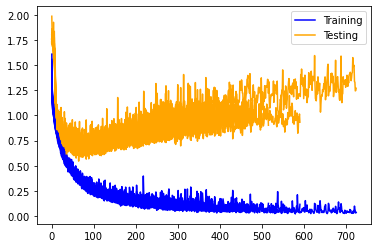

In [8]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

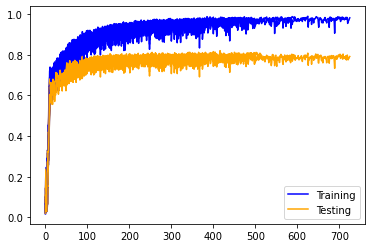

In [9]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

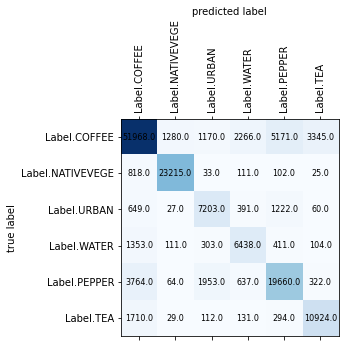

In [10]:
plot_confusion_matrix(conf_matrix, labels)

In [11]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.86236766 0.93889024 0.66855393 0.64547824 0.73194341 0.7391069 ]
Mean precision:  0.7643900632091535

Recalls:  [0.79705521 0.95519256 0.75408291 0.73830275 0.74469697 0.82757576]
Mean recall:  0.802817694959737

F-Score:  [0.82842614 0.94697124 0.70874742 0.68877715 0.73826511 0.78084346]
Mean f-score:  0.7820050863483358


# COASTAL_AEROSOL, BLUE, GREEN, RED, NIR, SWIR1, SWIR2, PANCHROMATIC, MNDWI, EVI2, BU

In [6]:
bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value,
    Band.PANCHROMATIC.value,
    Band.MNDWI.value,
    Band.EVI2.value,
    Band.BU.value,
]

model_name = "coastal_aerosol_blue_green_red_nir_swir1_swir2_panchromatic_mndwi_evi2_bu_2"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 9, 9, 11)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 11)          44        
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          3200      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          3

57/57 [==============================] - 0s 7ms/step - loss: 0.4611 - accuracy: 0.7525 - val_loss: 0.6193 - val_accuracy: 0.7706
Epoch 44/2000
57/57 [==============================] - 0s 6ms/step - loss: 0.4477 - accuracy: 0.7673 - val_loss: 0.7689 - val_accuracy: 0.7153
Epoch 45/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4436 - accuracy: 0.7560 - val_loss: 0.7146 - val_accuracy: 0.7353
Epoch 46/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4515 - accuracy: 0.7785 - val_loss: 0.7505 - val_accuracy: 0.7264
Epoch 47/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4293 - accuracy: 0.7681 - val_loss: 0.7225 - val_accuracy: 0.7295
Epoch 48/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4286 - accuracy: 0.7804 - val_loss: 0.8019 - val_accuracy: 0.6911
Epoch 49/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.4329 - accuracy: 0.7521 - val_loss: 0.7114 - val_accuracy: 0.7510
Epoch 50/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.2459 - accuracy: 0.8402 - val_loss: 0.6373 - val_accuracy: 0.7982
Epoch 101/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2718 - accuracy: 0.8387 - val_loss: 0.7134 - val_accuracy: 0.7690
Epoch 102/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2845 - accuracy: 0.8304 - val_loss: 0.6265 - val_accuracy: 0.8037
Epoch 103/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.2550 - accuracy: 0.8560 - val_loss: 0.7013 - val_accuracy: 0.7710
Epoch 104/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2469 - accuracy: 0.8548 - val_loss: 0.7394 - val_accuracy: 0.7659
Epoch 105/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2732 - accuracy: 0.8371 - val_loss: 0.7361 - val_accuracy: 0.7586
Epoch 106/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2626 - accuracy: 0.8333 - val_loss: 0.6820 - val_accuracy: 0.7845
Epoch 1

Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2060 - accuracy: 0.8930 - val_loss: 0.6804 - val_accuracy: 0.7938
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1974 - accuracy: 0.8918 - val_loss: 0.8469 - val_accuracy: 0.7691
Epoch 159/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1718 - accuracy: 0.8898 - val_loss: 0.8186 - val_accuracy: 0.7652
Epoch 160/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1581 - accuracy: 0.8926 - val_loss: 0.7978 - val_accuracy: 0.7835
Epoch 161/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1559 - accuracy: 0.8909 - val_loss: 0.8194 - val_accuracy: 0.7930
Epoch 162/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2279 - accuracy: 0.8773 - val_loss: 0.7066 - val_accuracy: 0.7949
Epoch 163/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1811 - accuracy: 0.8844 - val_loss: 0.6996 - val_accuracy:

Epoch 214/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1045 - accuracy: 0.9261 - val_loss: 0.8210 - val_accuracy: 0.8120
Epoch 215/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1545 - accuracy: 0.9161 - val_loss: 0.8181 - val_accuracy: 0.8027
Epoch 216/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1362 - accuracy: 0.9110 - val_loss: 0.8209 - val_accuracy: 0.7975
Epoch 217/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1310 - accuracy: 0.9180 - val_loss: 0.9062 - val_accuracy: 0.7961
Epoch 218/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1313 - accuracy: 0.9218 - val_loss: 0.8782 - val_accuracy: 0.7847
Epoch 219/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1395 - accuracy: 0.9084 - val_loss: 0.8072 - val_accuracy: 0.8058
Epoch 220/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1089 - accuracy: 0.9371 - val_loss: 0.8139 - val_accuracy:

Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2115 - accuracy: 0.8988 - val_loss: 0.8438 - val_accuracy: 0.7911
Epoch 272/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0980 - accuracy: 0.9317 - val_loss: 0.8725 - val_accuracy: 0.8008
Epoch 273/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1263 - accuracy: 0.9311 - val_loss: 0.9529 - val_accuracy: 0.8069
Epoch 274/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.1424 - accuracy: 0.9111 - val_loss: 0.9336 - val_accuracy: 0.8069
Epoch 275/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1171 - accuracy: 0.9275 - val_loss: 0.9192 - val_accuracy: 0.7986
Epoch 276/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0883 - accuracy: 0.9473 - val_loss: 1.0188 - val_accuracy: 0.7839
Epoch 277/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1467 - accuracy: 0.9230 - val_loss: 0.7983 - val_accuracy

Epoch 328/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1208 - accuracy: 0.9205 - val_loss: 0.8759 - val_accuracy: 0.8188
Epoch 329/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0970 - accuracy: 0.9446 - val_loss: 0.8719 - val_accuracy: 0.8109
Epoch 330/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0852 - accuracy: 0.9388 - val_loss: 0.9149 - val_accuracy: 0.8284
Epoch 331/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0613 - accuracy: 0.9528 - val_loss: 0.9479 - val_accuracy: 0.8208
Epoch 332/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0599 - accuracy: 0.9637 - val_loss: 0.9650 - val_accuracy: 0.8221
Epoch 333/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.0724 - accuracy: 0.9537 - val_loss: 0.9583 - val_accuracy: 0.8004
Epoch 334/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0761 - accuracy: 0.9552 - val_loss: 0.9738 - val_accuracy:

Epoch 385/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1056 - accuracy: 0.9570 - val_loss: 0.9487 - val_accuracy: 0.8089
Epoch 386/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0585 - accuracy: 0.9644 - val_loss: 1.0384 - val_accuracy: 0.8009
Epoch 387/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1019 - accuracy: 0.9486 - val_loss: 0.9380 - val_accuracy: 0.8158
Epoch 388/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0840 - accuracy: 0.9509 - val_loss: 1.0246 - val_accuracy: 0.8063
Epoch 389/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0708 - accuracy: 0.9592 - val_loss: 0.9863 - val_accuracy: 0.8240
Epoch 390/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0788 - accuracy: 0.9553 - val_loss: 0.9612 - val_accuracy: 0.8099
Epoch 391/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0817 - accuracy: 0.9475 - val_loss: 1.0406 - val_accuracy:

Epoch 51/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4159 - accuracy: 0.7581 - val_loss: 0.7389 - val_accuracy: 0.7099
Epoch 52/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4435 - accuracy: 0.7461 - val_loss: 0.7273 - val_accuracy: 0.7371
Epoch 53/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4750 - accuracy: 0.7555 - val_loss: 0.6225 - val_accuracy: 0.7655
Epoch 54/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4526 - accuracy: 0.7649 - val_loss: 0.6710 - val_accuracy: 0.7551
Epoch 55/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4151 - accuracy: 0.7675 - val_loss: 0.7096 - val_accuracy: 0.7282
Epoch 56/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4509 - accuracy: 0.7737 - val_loss: 0.6865 - val_accuracy: 0.7431
Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4503 - accuracy: 0.7635 - val_loss: 0.7371 - val_accuracy: 0.7354

57/57 [==============================] - 0s 8ms/step - loss: 0.2259 - accuracy: 0.8749 - val_loss: 0.7046 - val_accuracy: 0.7660
Epoch 109/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2055 - accuracy: 0.8730 - val_loss: 0.7154 - val_accuracy: 0.7780
Epoch 110/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3133 - accuracy: 0.8514 - val_loss: 0.6674 - val_accuracy: 0.7833
Epoch 111/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2406 - accuracy: 0.8488 - val_loss: 0.7438 - val_accuracy: 0.7762
Epoch 112/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2379 - accuracy: 0.8563 - val_loss: 0.7704 - val_accuracy: 0.7678
Epoch 113/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3134 - accuracy: 0.8461 - val_loss: 0.7924 - val_accuracy: 0.7293
Epoch 114/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2595 - accuracy: 0.8480 - val_loss: 0.6392 - val_accuracy: 0.7887
Epoch 1

Epoch 165/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1605 - accuracy: 0.9089 - val_loss: 0.7223 - val_accuracy: 0.7982
Epoch 166/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1351 - accuracy: 0.9145 - val_loss: 0.8166 - val_accuracy: 0.7815
Epoch 167/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1566 - accuracy: 0.9056 - val_loss: 0.7930 - val_accuracy: 0.7884
Epoch 168/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1899 - accuracy: 0.8854 - val_loss: 0.8285 - val_accuracy: 0.7757
Epoch 169/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1880 - accuracy: 0.8976 - val_loss: 0.7917 - val_accuracy: 0.7884
Epoch 170/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1705 - accuracy: 0.8982 - val_loss: 0.8181 - val_accuracy: 0.7859
Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1236 - accuracy: 0.9212 - val_loss: 0.8742 - val_accuracy:

Epoch 222/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1070 - accuracy: 0.9391 - val_loss: 0.8665 - val_accuracy: 0.7983
Epoch 223/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2082 - accuracy: 0.9227 - val_loss: 0.8979 - val_accuracy: 0.7802
Epoch 224/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1606 - accuracy: 0.9117 - val_loss: 0.9250 - val_accuracy: 0.7708
Epoch 225/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1606 - accuracy: 0.9080 - val_loss: 0.8198 - val_accuracy: 0.7910
Epoch 226/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1441 - accuracy: 0.9247 - val_loss: 0.8172 - val_accuracy: 0.8007
Epoch 227/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1655 - accuracy: 0.9137 - val_loss: 0.8763 - val_accuracy: 0.7796
Epoch 228/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1500 - accuracy: 0.9103 - val_loss: 0.9284 - val_accuracy:

Epoch 279/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1000 - accuracy: 0.9439 - val_loss: 1.0062 - val_accuracy: 0.7811
Epoch 280/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1596 - accuracy: 0.9316 - val_loss: 0.9221 - val_accuracy: 0.8068
Epoch 281/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0808 - accuracy: 0.9575 - val_loss: 0.9642 - val_accuracy: 0.8038
Epoch 282/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0801 - accuracy: 0.9612 - val_loss: 0.9804 - val_accuracy: 0.7948
Epoch 283/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0870 - accuracy: 0.9537 - val_loss: 0.9997 - val_accuracy: 0.7876
Epoch 284/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1427 - accuracy: 0.9233 - val_loss: 0.9690 - val_accuracy: 0.7966
Epoch 285/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1655 - accuracy: 0.9189 - val_loss: 0.9300 - val_accuracy:

Epoch 336/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0607 - accuracy: 0.9636 - val_loss: 1.1167 - val_accuracy: 0.8100
Epoch 337/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0659 - accuracy: 0.9602 - val_loss: 1.0994 - val_accuracy: 0.7929
Epoch 338/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0860 - accuracy: 0.9446 - val_loss: 1.0028 - val_accuracy: 0.8149
Epoch 339/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0583 - accuracy: 0.9652 - val_loss: 1.0719 - val_accuracy: 0.8062
Epoch 340/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0731 - accuracy: 0.9513 - val_loss: 1.1316 - val_accuracy: 0.7952
Epoch 341/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1316 - accuracy: 0.9294 - val_loss: 0.9943 - val_accuracy: 0.8004
Epoch 342/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0865 - accuracy: 0.9483 - val_loss: 1.0227 - val_accuracy:

Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5490 - accuracy: 0.7054 - val_loss: 0.7789 - val_accuracy: 0.7005
Epoch 36/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5312 - accuracy: 0.7438 - val_loss: 0.7813 - val_accuracy: 0.7046
Epoch 37/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5018 - accuracy: 0.7618 - val_loss: 0.7890 - val_accuracy: 0.7027
Epoch 38/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5298 - accuracy: 0.7284 - val_loss: 0.7347 - val_accuracy: 0.7276
Epoch 39/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4910 - accuracy: 0.7592 - val_loss: 0.7286 - val_accuracy: 0.7291
Epoch 40/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5229 - accuracy: 0.7347 - val_loss: 0.9197 - val_accuracy: 0.6378
Epoch 41/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.4891 - accuracy: 0.7192 - val_loss: 0.6708 - val_accuracy: 0.7525

57/57 [==============================] - 1s 9ms/step - loss: 0.2905 - accuracy: 0.8654 - val_loss: 0.6527 - val_accuracy: 0.7903
Epoch 93/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2542 - accuracy: 0.8735 - val_loss: 0.7081 - val_accuracy: 0.7498
Epoch 94/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3009 - accuracy: 0.8520 - val_loss: 0.6637 - val_accuracy: 0.7840
Epoch 95/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2577 - accuracy: 0.8589 - val_loss: 0.7281 - val_accuracy: 0.7483
Epoch 96/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2352 - accuracy: 0.8617 - val_loss: 0.6655 - val_accuracy: 0.7739
Epoch 97/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2383 - accuracy: 0.8757 - val_loss: 0.6752 - val_accuracy: 0.7836
Epoch 98/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2194 - accuracy: 0.8793 - val_loss: 0.7232 - val_accuracy: 0.7667
Epoch 99/2000

57/57 [==============================] - 1s 9ms/step - loss: 0.2325 - accuracy: 0.8972 - val_loss: 0.6913 - val_accuracy: 0.7982
Epoch 150/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2007 - accuracy: 0.8950 - val_loss: 0.8112 - val_accuracy: 0.7526
Epoch 151/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1933 - accuracy: 0.8734 - val_loss: 0.7282 - val_accuracy: 0.8032
Epoch 152/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1790 - accuracy: 0.9067 - val_loss: 0.7794 - val_accuracy: 0.7682
Epoch 153/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1897 - accuracy: 0.8792 - val_loss: 0.7969 - val_accuracy: 0.7836
Epoch 154/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1565 - accuracy: 0.9112 - val_loss: 0.7435 - val_accuracy: 0.7921
Epoch 155/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1531 - accuracy: 0.9120 - val_loss: 0.7040 - val_accuracy: 0.8087
Epoch 1

Epoch 206/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1503 - accuracy: 0.9237 - val_loss: 0.8106 - val_accuracy: 0.7963
Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1224 - accuracy: 0.9268 - val_loss: 0.9205 - val_accuracy: 0.7810
Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1622 - accuracy: 0.9188 - val_loss: 0.7964 - val_accuracy: 0.8020
Epoch 209/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1102 - accuracy: 0.9282 - val_loss: 0.8238 - val_accuracy: 0.7982
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0926 - accuracy: 0.9456 - val_loss: 0.8174 - val_accuracy: 0.8047
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1242 - accuracy: 0.9367 - val_loss: 0.7897 - val_accuracy: 0.8050
Epoch 212/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1580 - accuracy: 0.9240 - val_loss: 0.8112 - val_accuracy:

Epoch 263/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1210 - accuracy: 0.9501 - val_loss: 0.8414 - val_accuracy: 0.8201
Epoch 264/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1061 - accuracy: 0.9420 - val_loss: 0.8931 - val_accuracy: 0.8049
Epoch 265/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1179 - accuracy: 0.9487 - val_loss: 0.8755 - val_accuracy: 0.8107
Epoch 266/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1367 - accuracy: 0.9319 - val_loss: 1.0435 - val_accuracy: 0.7420
Epoch 267/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1488 - accuracy: 0.9105 - val_loss: 0.7877 - val_accuracy: 0.8249
Epoch 268/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1206 - accuracy: 0.9348 - val_loss: 0.7764 - val_accuracy: 0.8137
Epoch 269/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0986 - accuracy: 0.9563 - val_loss: 0.8297 - val_accuracy:

Epoch 320/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1067 - accuracy: 0.9444 - val_loss: 0.8731 - val_accuracy: 0.8159
Epoch 321/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0654 - accuracy: 0.9686 - val_loss: 0.9334 - val_accuracy: 0.8230
Epoch 322/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0916 - accuracy: 0.9580 - val_loss: 0.8905 - val_accuracy: 0.8093
Epoch 323/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0738 - accuracy: 0.9609 - val_loss: 0.8901 - val_accuracy: 0.8097
Epoch 324/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0729 - accuracy: 0.9454 - val_loss: 0.9293 - val_accuracy: 0.8081
Epoch 325/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1157 - accuracy: 0.9085 - val_loss: 0.9074 - val_accuracy: 0.7922
Epoch 326/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0709 - accuracy: 0.9493 - val_loss: 0.9370 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.7746 - accuracy: 0.6667 - val_loss: 1.0169 - val_accuracy: 0.5975
Epoch 22/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7709 - accuracy: 0.6453 - val_loss: 0.8493 - val_accuracy: 0.6837
Epoch 23/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.7607 - accuracy: 0.6664 - val_loss: 0.8641 - val_accuracy: 0.6854
Epoch 24/2000
57/57 [==============================] - 0s 7ms/step - loss: 0.7866 - accuracy: 0.6904 - val_loss: 0.7072 - val_accuracy: 0.7314
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7348 - accuracy: 0.6555 - val_loss: 0.7983 - val_accuracy: 0.6998
Epoch 26/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6407 - accuracy: 0.7022 - val_loss: 0.7742 - val_accuracy: 0.7133
Epoch 27/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6379 - accuracy: 0.7148 - val_loss: 0.7382 - val_accuracy: 0.7230
Epoch 28/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.3264 - accuracy: 0.8066 - val_loss: 0.6792 - val_accuracy: 0.7578
Epoch 79/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3615 - accuracy: 0.7978 - val_loss: 0.6385 - val_accuracy: 0.7882
Epoch 80/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3136 - accuracy: 0.8262 - val_loss: 0.7143 - val_accuracy: 0.7734
Epoch 81/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.4224 - accuracy: 0.7926 - val_loss: 0.6052 - val_accuracy: 0.7812
Epoch 82/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2875 - accuracy: 0.8457 - val_loss: 0.6329 - val_accuracy: 0.7899
Epoch 83/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3253 - accuracy: 0.8231 - val_loss: 0.6600 - val_accuracy: 0.7722
Epoch 84/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3054 - accuracy: 0.8255 - val_loss: 0.6358 - val_accuracy: 0.7829
Epoch 85/200

57/57 [==============================] - 0s 9ms/step - loss: 0.1968 - accuracy: 0.8896 - val_loss: 0.6933 - val_accuracy: 0.7962
Epoch 136/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1685 - accuracy: 0.8976 - val_loss: 0.6717 - val_accuracy: 0.8092
Epoch 137/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1755 - accuracy: 0.8989 - val_loss: 0.7574 - val_accuracy: 0.7994
Epoch 138/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1980 - accuracy: 0.8965 - val_loss: 0.6819 - val_accuracy: 0.8008
Epoch 139/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1891 - accuracy: 0.8879 - val_loss: 0.7133 - val_accuracy: 0.8050
Epoch 140/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2500 - accuracy: 0.8766 - val_loss: 0.7101 - val_accuracy: 0.7895
Epoch 141/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1833 - accuracy: 0.8891 - val_loss: 0.6858 - val_accuracy: 0.7875
Epoch 1

Epoch 192/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1130 - accuracy: 0.9335 - val_loss: 0.7571 - val_accuracy: 0.8171
Epoch 193/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1361 - accuracy: 0.9231 - val_loss: 0.8301 - val_accuracy: 0.7955
Epoch 194/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1644 - accuracy: 0.9058 - val_loss: 0.7972 - val_accuracy: 0.8064
Epoch 195/2000
57/57 [==============================] - 1s 14ms/step - loss: 0.1193 - accuracy: 0.9340 - val_loss: 0.7617 - val_accuracy: 0.8103
Epoch 196/2000
57/57 [==============================] - 1s 13ms/step - loss: 0.1162 - accuracy: 0.9225 - val_loss: 0.8008 - val_accuracy: 0.8047
Epoch 197/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.1609 - accuracy: 0.9033 - val_loss: 0.7722 - val_accuracy: 0.8026
Epoch 198/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1209 - accuracy: 0.9257 - val_loss: 0.8292 - val_accur

Epoch 249/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0914 - accuracy: 0.9413 - val_loss: 0.8681 - val_accuracy: 0.8073
Epoch 250/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1090 - accuracy: 0.9311 - val_loss: 0.8979 - val_accuracy: 0.8058
Epoch 251/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1408 - accuracy: 0.9120 - val_loss: 0.7886 - val_accuracy: 0.8239
Epoch 252/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0860 - accuracy: 0.9505 - val_loss: 0.8662 - val_accuracy: 0.8213
Epoch 253/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0972 - accuracy: 0.9476 - val_loss: 0.8779 - val_accuracy: 0.7913
Epoch 254/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1597 - accuracy: 0.9276 - val_loss: 0.7888 - val_accuracy: 0.8226
Epoch 255/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1407 - accuracy: 0.9263 - val_loss: 0.8104 - val_accuracy:

Epoch 306/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0702 - accuracy: 0.9586 - val_loss: 0.9112 - val_accuracy: 0.8253
Epoch 307/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1123 - accuracy: 0.9464 - val_loss: 0.8657 - val_accuracy: 0.8088
Epoch 308/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1091 - accuracy: 0.9408 - val_loss: 0.7988 - val_accuracy: 0.8182
Epoch 309/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0984 - accuracy: 0.9480 - val_loss: 0.8207 - val_accuracy: 0.8274
Epoch 310/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0956 - accuracy: 0.9585 - val_loss: 0.8274 - val_accuracy: 0.8252
Epoch 311/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0796 - accuracy: 0.9537 - val_loss: 0.8584 - val_accuracy: 0.8224
Epoch 312/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0682 - accuracy: 0.9600 - val_loss: 0.8605 - val_accuracy:

Epoch 363/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0723 - accuracy: 0.9676 - val_loss: 0.8778 - val_accuracy: 0.8211
Epoch 364/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0820 - accuracy: 0.9519 - val_loss: 0.9221 - val_accuracy: 0.8157
Epoch 365/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0607 - accuracy: 0.9635 - val_loss: 0.9090 - val_accuracy: 0.8237
Epoch 366/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0567 - accuracy: 0.9683 - val_loss: 0.9149 - val_accuracy: 0.8253
Epoch 367/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0612 - accuracy: 0.9607 - val_loss: 0.9251 - val_accuracy: 0.8279
Epoch 368/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0534 - accuracy: 0.9706 - val_loss: 0.9524 - val_accuracy: 0.8129
Epoch 369/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0861 - accuracy: 0.9522 - val_loss: 0.9728 - val_accuracy:

Epoch 420/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1535 - accuracy: 0.9527 - val_loss: 0.9958 - val_accuracy: 0.8175
Epoch 421/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0652 - accuracy: 0.9700 - val_loss: 0.9339 - val_accuracy: 0.8077
Epoch 422/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0707 - accuracy: 0.9550 - val_loss: 0.9663 - val_accuracy: 0.8203
Epoch 423/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0998 - accuracy: 0.9486 - val_loss: 0.9767 - val_accuracy: 0.8264
Epoch 424/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1121 - accuracy: 0.9489 - val_loss: 0.9293 - val_accuracy: 0.8053
Epoch 425/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0598 - accuracy: 0.9629 - val_loss: 0.9269 - val_accuracy: 0.8239
Epoch 426/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0418 - accuracy: 0.9702 - val_loss: 0.9361 - val_accuracy:

Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5952 - accuracy: 0.7121 - val_loss: 0.7928 - val_accuracy: 0.7047
Epoch 30/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5307 - accuracy: 0.7383 - val_loss: 0.8312 - val_accuracy: 0.6806
Epoch 31/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6287 - accuracy: 0.7034 - val_loss: 1.0099 - val_accuracy: 0.6051
Epoch 32/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6049 - accuracy: 0.7226 - val_loss: 0.7257 - val_accuracy: 0.7210
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4997 - accuracy: 0.7598 - val_loss: 0.7204 - val_accuracy: 0.7272
Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5691 - accuracy: 0.7378 - val_loss: 0.7717 - val_accuracy: 0.7112
Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5254 - accuracy: 0.7497 - val_loss: 0.7158 - val_accuracy: 0.7358

57/57 [==============================] - 0s 8ms/step - loss: 0.2859 - accuracy: 0.8260 - val_loss: 0.6743 - val_accuracy: 0.7612
Epoch 87/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2521 - accuracy: 0.8567 - val_loss: 0.6536 - val_accuracy: 0.7764
Epoch 88/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2486 - accuracy: 0.8609 - val_loss: 0.6671 - val_accuracy: 0.7565
Epoch 89/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2413 - accuracy: 0.8622 - val_loss: 0.6827 - val_accuracy: 0.7831
Epoch 90/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2409 - accuracy: 0.8646 - val_loss: 0.6738 - val_accuracy: 0.7769
Epoch 91/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2655 - accuracy: 0.8398 - val_loss: 0.6719 - val_accuracy: 0.7811
Epoch 92/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2133 - accuracy: 0.8668 - val_loss: 0.7804 - val_accuracy: 0.7475
Epoch 93/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.1468 - accuracy: 0.9037 - val_loss: 0.7604 - val_accuracy: 0.7861
Epoch 144/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1624 - accuracy: 0.8944 - val_loss: 0.7247 - val_accuracy: 0.7841
Epoch 145/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1481 - accuracy: 0.9067 - val_loss: 0.7480 - val_accuracy: 0.7939
Epoch 146/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1762 - accuracy: 0.8974 - val_loss: 0.8024 - val_accuracy: 0.8036
Epoch 147/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1888 - accuracy: 0.8959 - val_loss: 0.7581 - val_accuracy: 0.7743
Epoch 148/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1942 - accuracy: 0.8836 - val_loss: 0.7933 - val_accuracy: 0.7665
Epoch 149/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1747 - accuracy: 0.8940 - val_loss: 0.7750 - val_accuracy: 0.7887
Epoch 1

Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1504 - accuracy: 0.9241 - val_loss: 0.7897 - val_accuracy: 0.8073
Epoch 201/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1210 - accuracy: 0.9247 - val_loss: 0.8049 - val_accuracy: 0.8112
Epoch 202/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1000 - accuracy: 0.9296 - val_loss: 0.7644 - val_accuracy: 0.8222
Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1768 - accuracy: 0.9098 - val_loss: 0.8098 - val_accuracy: 0.8119
Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1104 - accuracy: 0.9400 - val_loss: 0.8498 - val_accuracy: 0.7883
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1155 - accuracy: 0.9426 - val_loss: 0.8187 - val_accuracy: 0.8013
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1982 - accuracy: 0.9101 - val_loss: 0.7819 - val_accuracy:

Epoch 257/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1117 - accuracy: 0.9421 - val_loss: 0.8622 - val_accuracy: 0.8092
Epoch 258/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0907 - accuracy: 0.9482 - val_loss: 0.8443 - val_accuracy: 0.8188
Epoch 259/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0961 - accuracy: 0.9384 - val_loss: 0.9121 - val_accuracy: 0.8121
Epoch 260/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0893 - accuracy: 0.9590 - val_loss: 0.8899 - val_accuracy: 0.8062
Epoch 261/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0711 - accuracy: 0.9521 - val_loss: 0.9302 - val_accuracy: 0.8133
Epoch 262/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0888 - accuracy: 0.9484 - val_loss: 1.0067 - val_accuracy: 0.8023
Epoch 263/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1072 - accuracy: 0.9558 - val_loss: 0.8623 - val_accuracy:

Epoch 314/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0601 - accuracy: 0.9666 - val_loss: 0.9479 - val_accuracy: 0.8171
Epoch 315/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0497 - accuracy: 0.9673 - val_loss: 1.2209 - val_accuracy: 0.7833
Epoch 316/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1573 - accuracy: 0.9246 - val_loss: 1.0211 - val_accuracy: 0.8066
Epoch 317/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0710 - accuracy: 0.9537 - val_loss: 0.9755 - val_accuracy: 0.8179
Epoch 318/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0784 - accuracy: 0.9554 - val_loss: 0.9763 - val_accuracy: 0.8179
Epoch 319/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0670 - accuracy: 0.9646 - val_loss: 1.0516 - val_accuracy: 0.8224
Epoch 320/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0727 - accuracy: 0.9460 - val_loss: 0.9838 - val_accuracy:

Epoch 371/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0648 - accuracy: 0.9656 - val_loss: 1.0034 - val_accuracy: 0.8229
Epoch 372/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0795 - accuracy: 0.9671 - val_loss: 1.0164 - val_accuracy: 0.8233
Epoch 373/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0489 - accuracy: 0.9767 - val_loss: 1.1166 - val_accuracy: 0.8032
Epoch 374/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1076 - accuracy: 0.9483 - val_loss: 1.0292 - val_accuracy: 0.8123
Epoch 375/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0457 - accuracy: 0.9686 - val_loss: 1.0676 - val_accuracy: 0.8258
Epoch 376/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0609 - accuracy: 0.9614 - val_loss: 1.0955 - val_accuracy: 0.8122
Epoch 377/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0788 - accuracy: 0.9652 - val_loss: 1.0945 - val_accuracy:

Epoch 37/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5107 - accuracy: 0.7419 - val_loss: 0.6933 - val_accuracy: 0.7349
Epoch 38/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5081 - accuracy: 0.7428 - val_loss: 0.7609 - val_accuracy: 0.7237
Epoch 39/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5072 - accuracy: 0.7580 - val_loss: 0.7754 - val_accuracy: 0.7090
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5219 - accuracy: 0.7518 - val_loss: 0.7355 - val_accuracy: 0.7283
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4457 - accuracy: 0.7633 - val_loss: 0.7456 - val_accuracy: 0.7093
Epoch 42/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5062 - accuracy: 0.7236 - val_loss: 0.7084 - val_accuracy: 0.7305
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4244 - accuracy: 0.7843 - val_loss: 0.7235 - val_accuracy: 0.7147

57/57 [==============================] - 1s 10ms/step - loss: 0.2422 - accuracy: 0.8676 - val_loss: 0.6614 - val_accuracy: 0.7838
Epoch 95/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2538 - accuracy: 0.8619 - val_loss: 0.7529 - val_accuracy: 0.7710
Epoch 96/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3113 - accuracy: 0.8061 - val_loss: 0.7815 - val_accuracy: 0.7463
Epoch 97/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2136 - accuracy: 0.8514 - val_loss: 0.6463 - val_accuracy: 0.7934
Epoch 98/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2703 - accuracy: 0.8376 - val_loss: 0.6919 - val_accuracy: 0.7727
Epoch 99/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2569 - accuracy: 0.8518 - val_loss: 0.7133 - val_accuracy: 0.7681
Epoch 100/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2631 - accuracy: 0.8530 - val_loss: 0.6758 - val_accuracy: 0.7755
Epoch 101/2

Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1450 - accuracy: 0.9066 - val_loss: 0.7619 - val_accuracy: 0.8002
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1458 - accuracy: 0.9036 - val_loss: 0.7628 - val_accuracy: 0.8008
Epoch 153/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1738 - accuracy: 0.9043 - val_loss: 0.7577 - val_accuracy: 0.7922
Epoch 154/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1555 - accuracy: 0.9106 - val_loss: 0.7253 - val_accuracy: 0.8016
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1651 - accuracy: 0.9026 - val_loss: 0.6992 - val_accuracy: 0.8156
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1313 - accuracy: 0.9096 - val_loss: 0.7652 - val_accuracy: 0.8040
Epoch 157/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1852 - accuracy: 0.8987 - val_loss: 0.7329 - val_accuracy:

Epoch 208/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1282 - accuracy: 0.9318 - val_loss: 0.7138 - val_accuracy: 0.8204
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1049 - accuracy: 0.9470 - val_loss: 0.7518 - val_accuracy: 0.8217
Epoch 210/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1019 - accuracy: 0.9394 - val_loss: 0.7802 - val_accuracy: 0.8123
Epoch 211/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0736 - accuracy: 0.9583 - val_loss: 0.7823 - val_accuracy: 0.8203
Epoch 212/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0941 - accuracy: 0.9406 - val_loss: 0.7880 - val_accuracy: 0.8170
Epoch 213/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1227 - accuracy: 0.9243 - val_loss: 0.7802 - val_accuracy: 0.8135
Epoch 214/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1013 - accuracy: 0.9410 - val_loss: 0.8703 - val_accuracy:

Epoch 265/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0834 - accuracy: 0.9479 - val_loss: 0.8732 - val_accuracy: 0.8094
Epoch 266/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0949 - accuracy: 0.9474 - val_loss: 0.8560 - val_accuracy: 0.8199
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0847 - accuracy: 0.9588 - val_loss: 0.8837 - val_accuracy: 0.8185
Epoch 268/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0721 - accuracy: 0.9613 - val_loss: 0.8715 - val_accuracy: 0.8160
Epoch 269/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1023 - accuracy: 0.9564 - val_loss: 0.9221 - val_accuracy: 0.7975
Epoch 270/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1082 - accuracy: 0.9347 - val_loss: 0.8776 - val_accuracy: 0.8090
Epoch 271/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1174 - accuracy: 0.9461 - val_loss: 0.8361 - val_accuracy:

Epoch 322/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0659 - accuracy: 0.9654 - val_loss: 0.9259 - val_accuracy: 0.8156
Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0810 - accuracy: 0.9566 - val_loss: 0.9818 - val_accuracy: 0.8085
Epoch 324/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1166 - accuracy: 0.9428 - val_loss: 0.9021 - val_accuracy: 0.8162
Epoch 325/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0896 - accuracy: 0.9532 - val_loss: 0.8743 - val_accuracy: 0.8134
Epoch 326/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2392 - accuracy: 0.9214 - val_loss: 0.8701 - val_accuracy: 0.7979
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1393 - accuracy: 0.9265 - val_loss: 0.9102 - val_accuracy: 0.7899
Epoch 328/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1151 - accuracy: 0.9380 - val_loss: 0.7967 - val_accuracy:

Epoch 379/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2346 - accuracy: 0.9126 - val_loss: 0.8637 - val_accuracy: 0.8032
Epoch 380/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0556 - accuracy: 0.9622 - val_loss: 0.9231 - val_accuracy: 0.8005
Epoch 381/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0786 - accuracy: 0.9598 - val_loss: 0.9193 - val_accuracy: 0.8154
Epoch 382/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0568 - accuracy: 0.9688 - val_loss: 1.0145 - val_accuracy: 0.8078
Epoch 383/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1482 - accuracy: 0.9575 - val_loss: 0.8824 - val_accuracy: 0.8183
Epoch 384/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0634 - accuracy: 0.9665 - val_loss: 0.9444 - val_accuracy: 0.8271
Epoch 385/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0480 - accuracy: 0.9758 - val_loss: 0.9458 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 1.0886 - accuracy: 0.3753 - val_loss: 1.7093 - val_accuracy: 0.0949
Epoch 4/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0782 - accuracy: 0.4046 - val_loss: 1.6311 - val_accuracy: 0.4060
Epoch 5/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0153 - accuracy: 0.4405 - val_loss: 1.6747 - val_accuracy: 0.1342
Epoch 6/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0111 - accuracy: 0.4283 - val_loss: 1.6107 - val_accuracy: 0.3832
Epoch 7/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9395 - accuracy: 0.4956 - val_loss: 1.5552 - val_accuracy: 0.4615
Epoch 8/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.9331 - accuracy: 0.5042 - val_loss: 1.5149 - val_accuracy: 0.5320
Epoch 9/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.8819 - accuracy: 0.5631 - val_loss: 1.3327 - val_accuracy: 0.5431
Epoch 10/2000
57/5

57/57 [==============================] - 0s 9ms/step - loss: 0.3809 - accuracy: 0.7981 - val_loss: 0.7329 - val_accuracy: 0.7405
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3729 - accuracy: 0.7989 - val_loss: 0.7363 - val_accuracy: 0.7356
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3604 - accuracy: 0.7874 - val_loss: 0.6223 - val_accuracy: 0.7817
Epoch 63/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3535 - accuracy: 0.8102 - val_loss: 0.6134 - val_accuracy: 0.7956
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3556 - accuracy: 0.7987 - val_loss: 0.7933 - val_accuracy: 0.7260
Epoch 65/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3804 - accuracy: 0.7977 - val_loss: 0.6521 - val_accuracy: 0.7674
Epoch 66/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3350 - accuracy: 0.8250 - val_loss: 0.8101 - val_accuracy: 0.7057
Epoch 67/2000

57/57 [==============================] - 1s 9ms/step - loss: 0.2413 - accuracy: 0.8652 - val_loss: 0.6902 - val_accuracy: 0.8026
Epoch 118/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1866 - accuracy: 0.8847 - val_loss: 0.8989 - val_accuracy: 0.7684
Epoch 119/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4338 - accuracy: 0.7835 - val_loss: 0.9054 - val_accuracy: 0.7118
Epoch 120/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3051 - accuracy: 0.8372 - val_loss: 0.6742 - val_accuracy: 0.7693
Epoch 121/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3030 - accuracy: 0.8323 - val_loss: 0.6136 - val_accuracy: 0.8026
Epoch 122/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2279 - accuracy: 0.8752 - val_loss: 0.6696 - val_accuracy: 0.7853
Epoch 123/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2297 - accuracy: 0.8694 - val_loss: 0.6372 - val_accuracy: 0.7983
Epoch 1

Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1361 - accuracy: 0.9132 - val_loss: 1.0075 - val_accuracy: 0.7682
Epoch 175/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1500 - accuracy: 0.9033 - val_loss: 0.8250 - val_accuracy: 0.8039
Epoch 176/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1647 - accuracy: 0.8965 - val_loss: 0.7942 - val_accuracy: 0.8027
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1043 - accuracy: 0.9463 - val_loss: 0.8896 - val_accuracy: 0.8058
Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1892 - accuracy: 0.8977 - val_loss: 0.8371 - val_accuracy: 0.8027
Epoch 179/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1428 - accuracy: 0.9092 - val_loss: 0.8008 - val_accuracy: 0.8045
Epoch 180/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1118 - accuracy: 0.9292 - val_loss: 0.9039 - val_accuracy:

Epoch 231/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0920 - accuracy: 0.9444 - val_loss: 1.0017 - val_accuracy: 0.8008
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0949 - accuracy: 0.9455 - val_loss: 0.9212 - val_accuracy: 0.7994
Epoch 233/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1181 - accuracy: 0.9305 - val_loss: 0.9158 - val_accuracy: 0.8015
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1019 - accuracy: 0.9419 - val_loss: 0.9709 - val_accuracy: 0.7973
Epoch 235/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1274 - accuracy: 0.9326 - val_loss: 1.0099 - val_accuracy: 0.7776
Epoch 236/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1238 - accuracy: 0.9249 - val_loss: 0.8787 - val_accuracy: 0.8144
Epoch 237/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0867 - accuracy: 0.9492 - val_loss: 0.9082 - val_accuracy:

Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1008 - accuracy: 0.9338 - val_loss: 0.9399 - val_accuracy: 0.8115
Epoch 289/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0819 - accuracy: 0.9533 - val_loss: 1.0271 - val_accuracy: 0.8032
Epoch 290/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0724 - accuracy: 0.9474 - val_loss: 0.9889 - val_accuracy: 0.8107
Epoch 291/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0711 - accuracy: 0.9587 - val_loss: 1.0109 - val_accuracy: 0.8111
Epoch 292/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0672 - accuracy: 0.9657 - val_loss: 1.1431 - val_accuracy: 0.7928
Epoch 293/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1046 - accuracy: 0.9369 - val_loss: 0.9990 - val_accuracy: 0.7913
Epoch 294/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0837 - accuracy: 0.9487 - val_loss: 0.9604 - val_accuracy:

Epoch 345/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0576 - accuracy: 0.9644 - val_loss: 1.0805 - val_accuracy: 0.8195

Validation  2 , fold  3 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 9ms/step - loss: 1.6460 - accuracy: 0.1872 - val_loss: 1.7039 - val_accuracy: 0.3086
Epoch 2/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.2816 - accuracy: 0.3312 - val_loss: 1.7257 - val_accuracy: 0.2253
Epoch 3/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1906 - accuracy: 0.3761 - val_loss: 1.7172 - val_accuracy: 0.2321
Epoch 4/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.1329 - accuracy: 0.4064 - val_loss: 1.6844 - val_accuracy: 0.1962
Epoch 5/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0859 - accuracy: 0.4002 - val_loss: 1.6643 - val_accuracy: 0.3277
Epoch 6/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0665 - accurac

Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4046 - accuracy: 0.7806 - val_loss: 0.6940 - val_accuracy: 0.7365
Epoch 58/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.3745 - accuracy: 0.7879 - val_loss: 0.7439 - val_accuracy: 0.7249
Epoch 59/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4291 - accuracy: 0.7641 - val_loss: 0.7275 - val_accuracy: 0.7141
Epoch 60/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4018 - accuracy: 0.7743 - val_loss: 0.7011 - val_accuracy: 0.7426
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3209 - accuracy: 0.8059 - val_loss: 0.7475 - val_accuracy: 0.7252
Epoch 62/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3886 - accuracy: 0.7997 - val_loss: 0.6829 - val_accuracy: 0.7499
Epoch 63/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3199 - accuracy: 0.8021 - val_loss: 0.8555 - val_accuracy: 0.683

57/57 [==============================] - 0s 8ms/step - loss: 0.2552 - accuracy: 0.8536 - val_loss: 0.6800 - val_accuracy: 0.7967
Epoch 115/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2301 - accuracy: 0.8626 - val_loss: 0.7123 - val_accuracy: 0.7789
Epoch 116/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2310 - accuracy: 0.8593 - val_loss: 0.6786 - val_accuracy: 0.7859
Epoch 117/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2310 - accuracy: 0.8628 - val_loss: 0.7057 - val_accuracy: 0.7895
Epoch 118/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1980 - accuracy: 0.8777 - val_loss: 0.7526 - val_accuracy: 0.7928
Epoch 119/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2051 - accuracy: 0.8711 - val_loss: 0.7124 - val_accuracy: 0.7948
Epoch 120/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2023 - accuracy: 0.8645 - val_loss: 0.7327 - val_accuracy: 0.7878
Epoch 1

Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1717 - accuracy: 0.9186 - val_loss: 0.9652 - val_accuracy: 0.7461
Epoch 172/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2633 - accuracy: 0.8561 - val_loss: 0.6972 - val_accuracy: 0.8043
Epoch 173/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1851 - accuracy: 0.8976 - val_loss: 0.7299 - val_accuracy: 0.7844
Epoch 174/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1620 - accuracy: 0.9019 - val_loss: 0.7693 - val_accuracy: 0.8000
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1282 - accuracy: 0.9214 - val_loss: 0.7863 - val_accuracy: 0.7834
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1216 - accuracy: 0.9200 - val_loss: 0.8276 - val_accuracy: 0.7864
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1444 - accuracy: 0.9048 - val_loss: 0.7708 - val_accuracy:

Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0954 - accuracy: 0.9382 - val_loss: 0.8165 - val_accuracy: 0.8122
Epoch 229/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0936 - accuracy: 0.9412 - val_loss: 0.9378 - val_accuracy: 0.8002
Epoch 230/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1403 - accuracy: 0.9140 - val_loss: 0.9189 - val_accuracy: 0.7825
Epoch 231/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1344 - accuracy: 0.9169 - val_loss: 0.9692 - val_accuracy: 0.7529
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1549 - accuracy: 0.9029 - val_loss: 0.8466 - val_accuracy: 0.7677
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1758 - accuracy: 0.9051 - val_loss: 0.8173 - val_accuracy: 0.8009
Epoch 234/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1089 - accuracy: 0.9325 - val_loss: 0.8428 - val_accuracy:

Epoch 285/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1938 - accuracy: 0.9010 - val_loss: 1.0808 - val_accuracy: 0.7469
Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1582 - accuracy: 0.9333 - val_loss: 0.7986 - val_accuracy: 0.8191
Epoch 287/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0803 - accuracy: 0.9567 - val_loss: 0.8908 - val_accuracy: 0.7920
Epoch 288/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0816 - accuracy: 0.9484 - val_loss: 0.9003 - val_accuracy: 0.7998
Epoch 289/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0959 - accuracy: 0.9478 - val_loss: 0.8988 - val_accuracy: 0.8045
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0878 - accuracy: 0.9548 - val_loss: 1.0076 - val_accuracy: 0.8173
Epoch 291/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0849 - accuracy: 0.9540 - val_loss: 0.8783 - val_accuracy:

Epoch 342/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1039 - accuracy: 0.9620 - val_loss: 0.9277 - val_accuracy: 0.8183
Epoch 343/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0957 - accuracy: 0.9582 - val_loss: 1.0837 - val_accuracy: 0.7997
Epoch 344/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1083 - accuracy: 0.9509 - val_loss: 0.9499 - val_accuracy: 0.8065
Epoch 345/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1132 - accuracy: 0.9525 - val_loss: 0.9647 - val_accuracy: 0.8102
Epoch 346/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0914 - accuracy: 0.9470 - val_loss: 0.9067 - val_accuracy: 0.8108
Epoch 347/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0676 - accuracy: 0.9554 - val_loss: 1.0080 - val_accuracy: 0.8116
Epoch 348/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0680 - accuracy: 0.9532 - val_loss: 0.9946 - val_accuracy:

Epoch 399/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0433 - accuracy: 0.9713 - val_loss: 1.2702 - val_accuracy: 0.8038
Epoch 400/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0800 - accuracy: 0.9655 - val_loss: 0.9871 - val_accuracy: 0.8095
Epoch 401/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0770 - accuracy: 0.9514 - val_loss: 1.1180 - val_accuracy: 0.8123
Epoch 402/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0755 - accuracy: 0.9635 - val_loss: 1.0621 - val_accuracy: 0.8179
Epoch 403/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0653 - accuracy: 0.9674 - val_loss: 1.0871 - val_accuracy: 0.8141
Epoch 404/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0591 - accuracy: 0.9621 - val_loss: 1.0669 - val_accuracy: 0.8196
Epoch 405/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0389 - accuracy: 0.9691 - val_loss: 1.0670 - val_accuracy:

Epoch 39/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5552 - accuracy: 0.7164 - val_loss: 0.7204 - val_accuracy: 0.7181
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5424 - accuracy: 0.7290 - val_loss: 0.7789 - val_accuracy: 0.6998
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5245 - accuracy: 0.7411 - val_loss: 0.7478 - val_accuracy: 0.6958
Epoch 42/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5534 - accuracy: 0.7306 - val_loss: 0.7154 - val_accuracy: 0.7363
Epoch 43/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5121 - accuracy: 0.7527 - val_loss: 0.6287 - val_accuracy: 0.7561
Epoch 44/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5355 - accuracy: 0.7326 - val_loss: 0.7355 - val_accuracy: 0.7091
Epoch 45/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5196 - accuracy: 0.7238 - val_loss: 0.7878 - val_accuracy: 0.7028

57/57 [==============================] - 1s 9ms/step - loss: 0.2477 - accuracy: 0.8599 - val_loss: 0.7090 - val_accuracy: 0.7658
Epoch 97/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3011 - accuracy: 0.8402 - val_loss: 0.6326 - val_accuracy: 0.7849
Epoch 98/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2974 - accuracy: 0.8414 - val_loss: 0.6369 - val_accuracy: 0.7769
Epoch 99/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2499 - accuracy: 0.8468 - val_loss: 0.6344 - val_accuracy: 0.7925
Epoch 100/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2434 - accuracy: 0.8482 - val_loss: 0.6928 - val_accuracy: 0.7586
Epoch 101/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2408 - accuracy: 0.8559 - val_loss: 0.6433 - val_accuracy: 0.7822
Epoch 102/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2627 - accuracy: 0.8446 - val_loss: 0.6925 - val_accuracy: 0.7690
Epoch 103/

57/57 [==============================] - 0s 8ms/step - loss: 0.2022 - accuracy: 0.8665 - val_loss: 0.7411 - val_accuracy: 0.7827
Epoch 154/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2117 - accuracy: 0.8871 - val_loss: 0.7451 - val_accuracy: 0.7950
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1615 - accuracy: 0.8884 - val_loss: 0.7118 - val_accuracy: 0.8167
Epoch 156/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1453 - accuracy: 0.9147 - val_loss: 0.7142 - val_accuracy: 0.8099
Epoch 157/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1536 - accuracy: 0.9209 - val_loss: 0.8564 - val_accuracy: 0.7595
Epoch 158/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1812 - accuracy: 0.8846 - val_loss: 0.7255 - val_accuracy: 0.8061
Epoch 159/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1800 - accuracy: 0.8945 - val_loss: 0.7176 - val_accuracy: 0.8020
Epoch 1

Epoch 210/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1521 - accuracy: 0.9112 - val_loss: 0.7132 - val_accuracy: 0.8195
Epoch 211/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1012 - accuracy: 0.9458 - val_loss: 0.7997 - val_accuracy: 0.8057
Epoch 212/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1021 - accuracy: 0.9351 - val_loss: 0.8219 - val_accuracy: 0.8023
Epoch 213/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1322 - accuracy: 0.9281 - val_loss: 0.8084 - val_accuracy: 0.8024
Epoch 214/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1129 - accuracy: 0.9280 - val_loss: 0.8041 - val_accuracy: 0.8043
Epoch 215/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1554 - accuracy: 0.9191 - val_loss: 0.8808 - val_accuracy: 0.7673
Epoch 216/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1351 - accuracy: 0.9219 - val_loss: 0.7783 - val_accuracy:

Epoch 267/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1089 - accuracy: 0.9380 - val_loss: 0.8358 - val_accuracy: 0.8007
Epoch 268/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0829 - accuracy: 0.9448 - val_loss: 0.8552 - val_accuracy: 0.8038
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1589 - accuracy: 0.9150 - val_loss: 0.9017 - val_accuracy: 0.7855
Epoch 270/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1272 - accuracy: 0.9228 - val_loss: 0.8168 - val_accuracy: 0.8104
Epoch 271/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1064 - accuracy: 0.9277 - val_loss: 0.8287 - val_accuracy: 0.8135
Epoch 272/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0873 - accuracy: 0.9432 - val_loss: 0.8947 - val_accuracy: 0.7967
Epoch 273/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1523 - accuracy: 0.9214 - val_loss: 0.9361 - val_accuracy:

Epoch 324/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1412 - accuracy: 0.9494 - val_loss: 0.9276 - val_accuracy: 0.8064
Epoch 325/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1252 - accuracy: 0.9250 - val_loss: 0.9141 - val_accuracy: 0.8096
Epoch 326/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0802 - accuracy: 0.9488 - val_loss: 0.8715 - val_accuracy: 0.8187
Epoch 327/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0625 - accuracy: 0.9490 - val_loss: 0.9086 - val_accuracy: 0.8127
Epoch 328/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0798 - accuracy: 0.9535 - val_loss: 0.9185 - val_accuracy: 0.8059
Epoch 329/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0906 - accuracy: 0.9527 - val_loss: 0.9676 - val_accuracy: 0.7929
Epoch 330/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1619 - accuracy: 0.9167 - val_loss: 0.8838 - val_accuracy:

Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1099 - accuracy: 0.9401 - val_loss: 0.8806 - val_accuracy: 0.8262
Epoch 382/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0856 - accuracy: 0.9573 - val_loss: 0.8862 - val_accuracy: 0.8172
Epoch 383/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0885 - accuracy: 0.9500 - val_loss: 0.9460 - val_accuracy: 0.8167
Epoch 384/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0766 - accuracy: 0.9555 - val_loss: 0.9075 - val_accuracy: 0.8201
Epoch 385/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0870 - accuracy: 0.9548 - val_loss: 1.0963 - val_accuracy: 0.7779
Epoch 386/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1262 - accuracy: 0.9403 - val_loss: 0.9213 - val_accuracy: 0.8207
Epoch 387/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0880 - accuracy: 0.9554 - val_loss: 0.9197 - val_accuracy:

Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5984 - accuracy: 0.7161 - val_loss: 0.7369 - val_accuracy: 0.7184
Epoch 30/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.6328 - accuracy: 0.7024 - val_loss: 0.7278 - val_accuracy: 0.7202
Epoch 31/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5982 - accuracy: 0.7217 - val_loss: 0.8191 - val_accuracy: 0.6861
Epoch 32/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5696 - accuracy: 0.7364 - val_loss: 0.8654 - val_accuracy: 0.6643
Epoch 33/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5603 - accuracy: 0.7360 - val_loss: 0.7489 - val_accuracy: 0.7065
Epoch 34/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5517 - accuracy: 0.7489 - val_loss: 0.6986 - val_accuracy: 0.7285
Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5679 - accuracy: 0.7404 - val_loss: 0.7598 - val_accuracy: 0.7082

57/57 [==============================] - 1s 9ms/step - loss: 0.3416 - accuracy: 0.8228 - val_loss: 0.7256 - val_accuracy: 0.7593
Epoch 87/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2894 - accuracy: 0.8341 - val_loss: 0.7447 - val_accuracy: 0.7479
Epoch 88/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2863 - accuracy: 0.8251 - val_loss: 0.7579 - val_accuracy: 0.7479
Epoch 89/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3377 - accuracy: 0.8293 - val_loss: 0.5969 - val_accuracy: 0.7996
Epoch 90/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2926 - accuracy: 0.8544 - val_loss: 0.6272 - val_accuracy: 0.7806
Epoch 91/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2546 - accuracy: 0.8631 - val_loss: 0.7185 - val_accuracy: 0.7366
Epoch 92/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3280 - accuracy: 0.8150 - val_loss: 0.6795 - val_accuracy: 0.7780
Epoch 93/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.1788 - accuracy: 0.8902 - val_loss: 0.7896 - val_accuracy: 0.7861
Epoch 144/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1849 - accuracy: 0.8933 - val_loss: 0.6948 - val_accuracy: 0.7941
Epoch 145/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1658 - accuracy: 0.8947 - val_loss: 0.7341 - val_accuracy: 0.7986
Epoch 146/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2021 - accuracy: 0.8944 - val_loss: 0.7477 - val_accuracy: 0.7755
Epoch 147/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1471 - accuracy: 0.9078 - val_loss: 0.7596 - val_accuracy: 0.7982
Epoch 148/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1520 - accuracy: 0.9080 - val_loss: 0.7857 - val_accuracy: 0.7632
Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2025 - accuracy: 0.8916 - val_loss: 0.7530 - val_accuracy: 0.7815
Epoch 1

Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1105 - accuracy: 0.9343 - val_loss: 0.7903 - val_accuracy: 0.8053
Epoch 201/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1375 - accuracy: 0.9119 - val_loss: 0.8341 - val_accuracy: 0.7886
Epoch 202/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1208 - accuracy: 0.9216 - val_loss: 0.7676 - val_accuracy: 0.8081
Epoch 203/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1284 - accuracy: 0.9333 - val_loss: 0.7939 - val_accuracy: 0.7823
Epoch 204/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1582 - accuracy: 0.9244 - val_loss: 0.8862 - val_accuracy: 0.7871
Epoch 205/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1912 - accuracy: 0.9110 - val_loss: 0.7464 - val_accuracy: 0.7986
Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1169 - accuracy: 0.9314 - val_loss: 0.8208 - val_accuracy:

Epoch 257/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1226 - accuracy: 0.9240 - val_loss: 0.8816 - val_accuracy: 0.8019
Epoch 258/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0838 - accuracy: 0.9532 - val_loss: 0.8466 - val_accuracy: 0.8093
Epoch 259/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1014 - accuracy: 0.9425 - val_loss: 0.9791 - val_accuracy: 0.7803
Epoch 260/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0946 - accuracy: 0.9270 - val_loss: 0.8980 - val_accuracy: 0.8020

Validation  3 , fold  1 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 9ms/step - loss: 1.5737 - accuracy: 0.2302 - val_loss: 1.7540 - val_accuracy: 0.4910
Epoch 2/2000
57/57 [==============================] - 1s 9ms/step - loss: 1.2725 - accuracy: 0.3636 - val_loss: 1.7304 - val_accuracy: 0.4001
Epoch 3/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.1399 - a

Epoch 54/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3862 - accuracy: 0.7988 - val_loss: 0.6701 - val_accuracy: 0.7606
Epoch 55/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3418 - accuracy: 0.8142 - val_loss: 0.7628 - val_accuracy: 0.7246
Epoch 56/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4211 - accuracy: 0.7667 - val_loss: 0.6714 - val_accuracy: 0.7685
Epoch 57/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3835 - accuracy: 0.7984 - val_loss: 0.6379 - val_accuracy: 0.7797
Epoch 58/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3420 - accuracy: 0.8032 - val_loss: 0.6146 - val_accuracy: 0.7777
Epoch 59/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3641 - accuracy: 0.8092 - val_loss: 0.6696 - val_accuracy: 0.7484
Epoch 60/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3671 - accuracy: 0.8134 - val_loss: 0.7014 - val_accuracy: 0.7579

57/57 [==============================] - 0s 8ms/step - loss: 0.1883 - accuracy: 0.8968 - val_loss: 0.6468 - val_accuracy: 0.8086
Epoch 112/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1779 - accuracy: 0.8909 - val_loss: 0.6640 - val_accuracy: 0.8056
Epoch 113/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1955 - accuracy: 0.8862 - val_loss: 0.6478 - val_accuracy: 0.7990
Epoch 114/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1779 - accuracy: 0.8837 - val_loss: 0.7243 - val_accuracy: 0.7723
Epoch 115/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1971 - accuracy: 0.8835 - val_loss: 0.7390 - val_accuracy: 0.7751
Epoch 116/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1932 - accuracy: 0.8757 - val_loss: 0.7289 - val_accuracy: 0.7765
Epoch 117/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2087 - accuracy: 0.8660 - val_loss: 0.8012 - val_accuracy: 0.7656
Epoch 1

Epoch 168/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1248 - accuracy: 0.9220 - val_loss: 0.7354 - val_accuracy: 0.8092
Epoch 169/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1268 - accuracy: 0.9162 - val_loss: 0.6988 - val_accuracy: 0.8214
Epoch 170/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1174 - accuracy: 0.9262 - val_loss: 0.7346 - val_accuracy: 0.8181
Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1196 - accuracy: 0.9240 - val_loss: 0.7582 - val_accuracy: 0.8217
Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1967 - accuracy: 0.8984 - val_loss: 0.7578 - val_accuracy: 0.7964
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1411 - accuracy: 0.9179 - val_loss: 0.7722 - val_accuracy: 0.8142
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1491 - accuracy: 0.9157 - val_loss: 0.8121 - val_accuracy:

Epoch 225/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0877 - accuracy: 0.9528 - val_loss: 0.8583 - val_accuracy: 0.8108
Epoch 226/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1556 - accuracy: 0.9327 - val_loss: 0.8658 - val_accuracy: 0.8109
Epoch 227/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1067 - accuracy: 0.9346 - val_loss: 0.7769 - val_accuracy: 0.8119
Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1185 - accuracy: 0.9290 - val_loss: 0.7904 - val_accuracy: 0.8223
Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0874 - accuracy: 0.9499 - val_loss: 0.8882 - val_accuracy: 0.8096
Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0916 - accuracy: 0.9506 - val_loss: 0.8844 - val_accuracy: 0.8071
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0880 - accuracy: 0.9441 - val_loss: 0.8887 - val_accuracy:

Epoch 282/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0988 - accuracy: 0.9362 - val_loss: 0.8400 - val_accuracy: 0.8077
Epoch 283/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0940 - accuracy: 0.9457 - val_loss: 0.8591 - val_accuracy: 0.8164
Epoch 284/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0700 - accuracy: 0.9615 - val_loss: 0.8581 - val_accuracy: 0.8233
Epoch 285/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0676 - accuracy: 0.9507 - val_loss: 0.8906 - val_accuracy: 0.8165
Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0583 - accuracy: 0.9714 - val_loss: 1.0732 - val_accuracy: 0.7940
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1402 - accuracy: 0.9258 - val_loss: 0.9533 - val_accuracy: 0.7697
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2682 - accuracy: 0.8716 - val_loss: 0.7798 - val_accuracy:

Epoch 339/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0853 - accuracy: 0.9484 - val_loss: 0.9629 - val_accuracy: 0.8027
Epoch 340/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0828 - accuracy: 0.9481 - val_loss: 1.0111 - val_accuracy: 0.8070
Epoch 341/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1016 - accuracy: 0.9328 - val_loss: 0.9789 - val_accuracy: 0.8101
Epoch 342/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0749 - accuracy: 0.9576 - val_loss: 0.9399 - val_accuracy: 0.8284
Epoch 343/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0614 - accuracy: 0.9636 - val_loss: 1.0153 - val_accuracy: 0.8089
Epoch 344/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0707 - accuracy: 0.9607 - val_loss: 0.9689 - val_accuracy: 0.8191
Epoch 345/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0719 - accuracy: 0.9629 - val_loss: 0.9198 - val_accuracy:

Epoch 396/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0496 - accuracy: 0.9652 - val_loss: 0.9802 - val_accuracy: 0.8279
Epoch 397/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0429 - accuracy: 0.9728 - val_loss: 1.0272 - val_accuracy: 0.8175
Epoch 398/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0827 - accuracy: 0.9640 - val_loss: 1.1918 - val_accuracy: 0.7466
Epoch 399/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1942 - accuracy: 0.9058 - val_loss: 0.8541 - val_accuracy: 0.8176
Epoch 400/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1086 - accuracy: 0.9448 - val_loss: 0.9386 - val_accuracy: 0.8164
Epoch 401/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0549 - accuracy: 0.9605 - val_loss: 0.8978 - val_accuracy: 0.8276
Epoch 402/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0536 - accuracy: 0.9676 - val_loss: 1.1421 - val_accuracy:

57/57 [==============================] - 0s 8ms/step - loss: 0.9579 - accuracy: 0.5402 - val_loss: 1.1635 - val_accuracy: 0.5936
Epoch 11/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8922 - accuracy: 0.5715 - val_loss: 0.9830 - val_accuracy: 0.6635
Epoch 12/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9060 - accuracy: 0.5796 - val_loss: 0.8901 - val_accuracy: 0.6940
Epoch 13/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8524 - accuracy: 0.6248 - val_loss: 0.9616 - val_accuracy: 0.6024
Epoch 14/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8618 - accuracy: 0.6175 - val_loss: 1.0070 - val_accuracy: 0.6042
Epoch 15/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8110 - accuracy: 0.6352 - val_loss: 0.8807 - val_accuracy: 0.6575
Epoch 16/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7820 - accuracy: 0.6479 - val_loss: 0.7601 - val_accuracy: 0.7180
Epoch 17/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.3392 - accuracy: 0.8142 - val_loss: 0.6369 - val_accuracy: 0.7608
Epoch 68/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3362 - accuracy: 0.8353 - val_loss: 0.7122 - val_accuracy: 0.7301
Epoch 69/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3821 - accuracy: 0.7877 - val_loss: 0.7192 - val_accuracy: 0.7377
Epoch 70/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3377 - accuracy: 0.8112 - val_loss: 0.5701 - val_accuracy: 0.7978
Epoch 71/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3323 - accuracy: 0.8287 - val_loss: 0.6935 - val_accuracy: 0.7517
Epoch 72/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3517 - accuracy: 0.8105 - val_loss: 0.8094 - val_accuracy: 0.7308
Epoch 73/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3953 - accuracy: 0.8149 - val_loss: 0.6034 - val_accuracy: 0.7842
Epoch 74/2000

57/57 [==============================] - 0s 9ms/step - loss: 0.2790 - accuracy: 0.8839 - val_loss: 0.6425 - val_accuracy: 0.7888
Epoch 125/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1974 - accuracy: 0.8883 - val_loss: 0.6179 - val_accuracy: 0.7997
Epoch 126/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2251 - accuracy: 0.8718 - val_loss: 0.6560 - val_accuracy: 0.7924
Epoch 127/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1697 - accuracy: 0.9139 - val_loss: 0.7403 - val_accuracy: 0.7760
Epoch 128/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2771 - accuracy: 0.8603 - val_loss: 0.6929 - val_accuracy: 0.7795
Epoch 129/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2080 - accuracy: 0.8721 - val_loss: 0.6574 - val_accuracy: 0.7831
Epoch 130/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1848 - accuracy: 0.8877 - val_loss: 0.6644 - val_accuracy: 0.8012
Epoch 1

Epoch 181/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1977 - accuracy: 0.9052 - val_loss: 0.6459 - val_accuracy: 0.8190
Epoch 182/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2284 - accuracy: 0.9109 - val_loss: 0.7671 - val_accuracy: 0.7886
Epoch 183/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2196 - accuracy: 0.8859 - val_loss: 0.6767 - val_accuracy: 0.7947
Epoch 184/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1487 - accuracy: 0.9215 - val_loss: 0.6967 - val_accuracy: 0.7977
Epoch 185/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1086 - accuracy: 0.9201 - val_loss: 0.8009 - val_accuracy: 0.7918
Epoch 186/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1476 - accuracy: 0.9212 - val_loss: 0.7496 - val_accuracy: 0.7947
Epoch 187/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1498 - accuracy: 0.9160 - val_loss: 0.6982 - val_accuracy:

Epoch 238/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0815 - accuracy: 0.9541 - val_loss: 0.8255 - val_accuracy: 0.8069
Epoch 239/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1078 - accuracy: 0.9329 - val_loss: 0.8568 - val_accuracy: 0.7958
Epoch 240/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1129 - accuracy: 0.9281 - val_loss: 0.8555 - val_accuracy: 0.8017
Epoch 241/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1382 - accuracy: 0.9302 - val_loss: 0.8869 - val_accuracy: 0.7791
Epoch 242/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1523 - accuracy: 0.9221 - val_loss: 0.7898 - val_accuracy: 0.8046
Epoch 243/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1099 - accuracy: 0.9412 - val_loss: 0.7745 - val_accuracy: 0.8153
Epoch 244/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1451 - accuracy: 0.9322 - val_loss: 0.8503 - val_accuracy:

Epoch 295/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0788 - accuracy: 0.9548 - val_loss: 0.8884 - val_accuracy: 0.8042
Epoch 296/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1340 - accuracy: 0.9494 - val_loss: 0.8109 - val_accuracy: 0.8099
Epoch 297/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0871 - accuracy: 0.9477 - val_loss: 0.8255 - val_accuracy: 0.8154
Epoch 298/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0607 - accuracy: 0.9654 - val_loss: 0.8756 - val_accuracy: 0.8175
Epoch 299/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0835 - accuracy: 0.9573 - val_loss: 0.9461 - val_accuracy: 0.7864
Epoch 300/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0756 - accuracy: 0.9481 - val_loss: 0.8270 - val_accuracy: 0.8259

Validation  3 , fold  3 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 8ms/step - loss: 1.7011

Epoch 52/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5121 - accuracy: 0.7746 - val_loss: 0.7237 - val_accuracy: 0.7348
Epoch 53/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4671 - accuracy: 0.7615 - val_loss: 0.6975 - val_accuracy: 0.7527
Epoch 54/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4432 - accuracy: 0.7733 - val_loss: 0.7514 - val_accuracy: 0.7243
Epoch 55/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4760 - accuracy: 0.7454 - val_loss: 0.7086 - val_accuracy: 0.7413
Epoch 56/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4383 - accuracy: 0.7961 - val_loss: 0.6828 - val_accuracy: 0.7507
Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4194 - accuracy: 0.7897 - val_loss: 0.7240 - val_accuracy: 0.7331
Epoch 58/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3855 - accuracy: 0.7830 - val_loss: 0.6388 - val_accuracy: 0.7769

57/57 [==============================] - 0s 8ms/step - loss: 0.2577 - accuracy: 0.8488 - val_loss: 0.6305 - val_accuracy: 0.7985
Epoch 110/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2515 - accuracy: 0.8568 - val_loss: 0.6378 - val_accuracy: 0.8050
Epoch 111/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1936 - accuracy: 0.8892 - val_loss: 0.7110 - val_accuracy: 0.7783
Epoch 112/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2402 - accuracy: 0.8794 - val_loss: 0.6882 - val_accuracy: 0.7831
Epoch 113/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2632 - accuracy: 0.8698 - val_loss: 0.6765 - val_accuracy: 0.7954
Epoch 114/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2324 - accuracy: 0.8677 - val_loss: 0.6537 - val_accuracy: 0.7819
Epoch 115/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.2528 - accuracy: 0.8518 - val_loss: 0.7403 - val_accuracy: 0.7884
Epoch 

Epoch 166/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1643 - accuracy: 0.9080 - val_loss: 0.6795 - val_accuracy: 0.8023
Epoch 167/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1543 - accuracy: 0.9197 - val_loss: 0.7225 - val_accuracy: 0.8080
Epoch 168/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1976 - accuracy: 0.8882 - val_loss: 0.7172 - val_accuracy: 0.7956
Epoch 169/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1396 - accuracy: 0.9071 - val_loss: 0.7545 - val_accuracy: 0.8007
Epoch 170/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1276 - accuracy: 0.9249 - val_loss: 0.8419 - val_accuracy: 0.7959
Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1386 - accuracy: 0.9101 - val_loss: 0.7731 - val_accuracy: 0.7929
Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1508 - accuracy: 0.9144 - val_loss: 0.7467 - val_accuracy:

Epoch 223/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1089 - accuracy: 0.9325 - val_loss: 0.8097 - val_accuracy: 0.8188
Epoch 224/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1213 - accuracy: 0.9354 - val_loss: 0.7860 - val_accuracy: 0.8137
Epoch 225/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1544 - accuracy: 0.9323 - val_loss: 0.7905 - val_accuracy: 0.7879
Epoch 226/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1545 - accuracy: 0.9271 - val_loss: 0.9654 - val_accuracy: 0.7807
Epoch 227/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2851 - accuracy: 0.8830 - val_loss: 0.8130 - val_accuracy: 0.7684
Epoch 228/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1710 - accuracy: 0.8972 - val_loss: 0.7264 - val_accuracy: 0.8043
Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1126 - accuracy: 0.9383 - val_loss: 0.7931 - val_accuracy:

57/57 [==============================] - 1s 8ms/step - loss: 1.6854 - accuracy: 0.1819 - val_loss: 1.7578 - val_accuracy: 0.4405
Epoch 2/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.2342 - accuracy: 0.3917 - val_loss: 1.7414 - val_accuracy: 0.3462
Epoch 3/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0964 - accuracy: 0.3931 - val_loss: 1.7805 - val_accuracy: 0.0900
Epoch 4/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0917 - accuracy: 0.4139 - val_loss: 1.8130 - val_accuracy: 0.0958
Epoch 5/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9888 - accuracy: 0.4279 - val_loss: 1.7979 - val_accuracy: 0.0950
Epoch 6/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.0960 - accuracy: 0.4346 - val_loss: 1.6912 - val_accuracy: 0.3264
Epoch 7/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0281 - accuracy: 0.4491 - val_loss: 1.5553 - val_accuracy: 0.4984
Epoch 8/2000
57/57 

57/57 [==============================] - 0s 8ms/step - loss: 0.4788 - accuracy: 0.7548 - val_loss: 0.6952 - val_accuracy: 0.7382
Epoch 59/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3879 - accuracy: 0.7844 - val_loss: 0.7085 - val_accuracy: 0.7412
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4351 - accuracy: 0.7793 - val_loss: 0.6999 - val_accuracy: 0.7350
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3952 - accuracy: 0.7698 - val_loss: 0.6738 - val_accuracy: 0.7633
Epoch 62/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4211 - accuracy: 0.7660 - val_loss: 0.7059 - val_accuracy: 0.7500
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4338 - accuracy: 0.7663 - val_loss: 0.6325 - val_accuracy: 0.7631
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4004 - accuracy: 0.7871 - val_loss: 0.6497 - val_accuracy: 0.7598
Epoch 65/2000

57/57 [==============================] - 1s 9ms/step - loss: 0.2859 - accuracy: 0.8262 - val_loss: 0.7016 - val_accuracy: 0.7743
Epoch 116/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2452 - accuracy: 0.8417 - val_loss: 0.7047 - val_accuracy: 0.7815
Epoch 117/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2480 - accuracy: 0.8642 - val_loss: 0.6665 - val_accuracy: 0.7890
Epoch 118/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2315 - accuracy: 0.8811 - val_loss: 0.7852 - val_accuracy: 0.7394
Epoch 119/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2420 - accuracy: 0.8409 - val_loss: 0.6660 - val_accuracy: 0.8000
Epoch 120/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2194 - accuracy: 0.8618 - val_loss: 0.6684 - val_accuracy: 0.7950
Epoch 121/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2077 - accuracy: 0.8741 - val_loss: 0.6819 - val_accuracy: 0.8008
Epoch 1

Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1648 - accuracy: 0.9014 - val_loss: 0.7866 - val_accuracy: 0.7822
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1450 - accuracy: 0.8923 - val_loss: 0.8202 - val_accuracy: 0.7869
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1475 - accuracy: 0.8898 - val_loss: 0.8290 - val_accuracy: 0.7867
Epoch 175/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1294 - accuracy: 0.9163 - val_loss: 0.8149 - val_accuracy: 0.7950
Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1800 - accuracy: 0.8892 - val_loss: 0.9039 - val_accuracy: 0.7732
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1434 - accuracy: 0.9045 - val_loss: 0.8353 - val_accuracy: 0.7728
Epoch 178/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1961 - accuracy: 0.8707 - val_loss: 0.8685 - val_accuracy:

Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2197 - accuracy: 0.8733 - val_loss: 0.8182 - val_accuracy: 0.7969
Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1524 - accuracy: 0.9110 - val_loss: 0.8145 - val_accuracy: 0.8005
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1328 - accuracy: 0.9271 - val_loss: 0.8720 - val_accuracy: 0.7997
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0892 - accuracy: 0.9370 - val_loss: 0.8987 - val_accuracy: 0.8007
Epoch 233/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0955 - accuracy: 0.9296 - val_loss: 0.8988 - val_accuracy: 0.7941
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1813 - accuracy: 0.9203 - val_loss: 0.9088 - val_accuracy: 0.7918
Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2039 - accuracy: 0.9056 - val_loss: 0.9580 - val_accuracy:

Epoch 286/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1179 - accuracy: 0.9384 - val_loss: 0.8512 - val_accuracy: 0.8168
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0902 - accuracy: 0.9373 - val_loss: 0.9520 - val_accuracy: 0.7970
Epoch 288/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0794 - accuracy: 0.9439 - val_loss: 0.9088 - val_accuracy: 0.8042
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0729 - accuracy: 0.9518 - val_loss: 1.0071 - val_accuracy: 0.8102
Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0925 - accuracy: 0.9428 - val_loss: 1.0247 - val_accuracy: 0.8017
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1271 - accuracy: 0.9232 - val_loss: 0.9200 - val_accuracy: 0.8148
Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1243 - accuracy: 0.9376 - val_loss: 0.9115 - val_accuracy:

Epoch 343/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1154 - accuracy: 0.9363 - val_loss: 0.9288 - val_accuracy: 0.7939
Epoch 344/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1298 - accuracy: 0.9195 - val_loss: 0.9120 - val_accuracy: 0.8066
Epoch 345/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0847 - accuracy: 0.9517 - val_loss: 0.9766 - val_accuracy: 0.8076
Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1141 - accuracy: 0.9352 - val_loss: 0.9361 - val_accuracy: 0.8077
Epoch 347/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0776 - accuracy: 0.9505 - val_loss: 0.9160 - val_accuracy: 0.8072
Epoch 348/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0524 - accuracy: 0.9648 - val_loss: 1.0310 - val_accuracy: 0.8126
Epoch 349/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0983 - accuracy: 0.9514 - val_loss: 0.9856 - val_accuracy:

Epoch 400/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0712 - accuracy: 0.9515 - val_loss: 0.9550 - val_accuracy: 0.8164
Epoch 401/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0707 - accuracy: 0.9665 - val_loss: 0.9411 - val_accuracy: 0.8186
Epoch 402/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0588 - accuracy: 0.9581 - val_loss: 0.9585 - val_accuracy: 0.8161
Epoch 403/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0773 - accuracy: 0.9516 - val_loss: 0.9610 - val_accuracy: 0.8127
Epoch 404/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0860 - accuracy: 0.9477 - val_loss: 0.9865 - val_accuracy: 0.8097
Epoch 405/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1529 - accuracy: 0.9293 - val_loss: 0.9487 - val_accuracy: 0.8001
Epoch 406/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0769 - accuracy: 0.9536 - val_loss: 1.0242 - val_accuracy:

Epoch 457/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0751 - accuracy: 0.9467 - val_loss: 1.1686 - val_accuracy: 0.8057
Epoch 458/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0600 - accuracy: 0.9602 - val_loss: 1.1186 - val_accuracy: 0.8164
Epoch 459/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0640 - accuracy: 0.9642 - val_loss: 1.1891 - val_accuracy: 0.8111
Epoch 460/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0586 - accuracy: 0.9645 - val_loss: 1.1891 - val_accuracy: 0.8035
Epoch 461/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0818 - accuracy: 0.9537 - val_loss: 1.1420 - val_accuracy: 0.7983
Epoch 462/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0876 - accuracy: 0.9484 - val_loss: 1.1590 - val_accuracy: 0.8106
Epoch 463/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0549 - accuracy: 0.9700 - val_loss: 1.1200 - val_accuracy:

Epoch 514/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0768 - accuracy: 0.9627 - val_loss: 1.0612 - val_accuracy: 0.8172
Epoch 515/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0589 - accuracy: 0.9626 - val_loss: 1.0029 - val_accuracy: 0.8165
Epoch 516/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0806 - accuracy: 0.9536 - val_loss: 1.0274 - val_accuracy: 0.8050
Epoch 517/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0836 - accuracy: 0.9349 - val_loss: 1.0463 - val_accuracy: 0.8154
Epoch 518/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0521 - accuracy: 0.9691 - val_loss: 1.0721 - val_accuracy: 0.8042
Epoch 519/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0588 - accuracy: 0.9725 - val_loss: 1.1993 - val_accuracy: 0.7845
Epoch 520/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1352 - accuracy: 0.9384 - val_loss: 0.9893 - val_accuracy:

Epoch 35/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5025 - accuracy: 0.7443 - val_loss: 0.7093 - val_accuracy: 0.7367
Epoch 36/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.5200 - accuracy: 0.7329 - val_loss: 0.6918 - val_accuracy: 0.7465
Epoch 37/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4680 - accuracy: 0.7443 - val_loss: 0.9926 - val_accuracy: 0.6540
Epoch 38/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4607 - accuracy: 0.7457 - val_loss: 0.9042 - val_accuracy: 0.6607
Epoch 39/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5073 - accuracy: 0.7252 - val_loss: 0.6956 - val_accuracy: 0.7388
Epoch 40/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5320 - accuracy: 0.7418 - val_loss: 0.7493 - val_accuracy: 0.7169
Epoch 41/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4545 - accuracy: 0.7558 - val_loss: 0.7059 - val_accuracy: 0.7415

57/57 [==============================] - 0s 8ms/step - loss: 0.2786 - accuracy: 0.8359 - val_loss: 0.7604 - val_accuracy: 0.7405
Epoch 93/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2442 - accuracy: 0.8405 - val_loss: 0.7692 - val_accuracy: 0.7570
Epoch 94/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2198 - accuracy: 0.8640 - val_loss: 0.7903 - val_accuracy: 0.7613
Epoch 95/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2194 - accuracy: 0.8552 - val_loss: 0.8334 - val_accuracy: 0.7422
Epoch 96/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2601 - accuracy: 0.8411 - val_loss: 0.8342 - val_accuracy: 0.7411
Epoch 97/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3053 - accuracy: 0.8315 - val_loss: 0.7960 - val_accuracy: 0.7484
Epoch 98/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2287 - accuracy: 0.8661 - val_loss: 0.8056 - val_accuracy: 0.7491
Epoch 99/2000

Epoch 149/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1721 - accuracy: 0.8671 - val_loss: 0.8079 - val_accuracy: 0.7798
Epoch 150/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1439 - accuracy: 0.9018 - val_loss: 0.7813 - val_accuracy: 0.7929
Epoch 151/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1179 - accuracy: 0.9233 - val_loss: 0.7868 - val_accuracy: 0.8049
Epoch 152/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1626 - accuracy: 0.8998 - val_loss: 0.7733 - val_accuracy: 0.8034
Epoch 153/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1394 - accuracy: 0.9062 - val_loss: 0.8004 - val_accuracy: 0.8004
Epoch 154/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1769 - accuracy: 0.9101 - val_loss: 0.8366 - val_accuracy: 0.7689
Epoch 155/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1693 - accuracy: 0.9026 - val_loss: 0.8492 - val_accuracy:

Epoch 206/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1926 - accuracy: 0.8841 - val_loss: 0.8003 - val_accuracy: 0.7912
Epoch 207/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1546 - accuracy: 0.8992 - val_loss: 0.8128 - val_accuracy: 0.7950
Epoch 208/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1325 - accuracy: 0.9136 - val_loss: 0.8781 - val_accuracy: 0.7898
Epoch 209/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1068 - accuracy: 0.9322 - val_loss: 0.8844 - val_accuracy: 0.7905
Epoch 210/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0920 - accuracy: 0.9317 - val_loss: 0.8342 - val_accuracy: 0.8093
Epoch 211/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1052 - accuracy: 0.9326 - val_loss: 1.0117 - val_accuracy: 0.7654
Epoch 212/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1566 - accuracy: 0.9124 - val_loss: 0.9130 - val_accuracy:

Epoch 263/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1127 - accuracy: 0.9258 - val_loss: 0.8728 - val_accuracy: 0.7935
Epoch 264/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0993 - accuracy: 0.9414 - val_loss: 0.9519 - val_accuracy: 0.7874
Epoch 265/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1124 - accuracy: 0.9379 - val_loss: 0.9349 - val_accuracy: 0.7960
Epoch 266/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0653 - accuracy: 0.9510 - val_loss: 1.0056 - val_accuracy: 0.8026
Epoch 267/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1043 - accuracy: 0.9405 - val_loss: 1.0884 - val_accuracy: 0.7765
Epoch 268/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0941 - accuracy: 0.9330 - val_loss: 0.9469 - val_accuracy: 0.7883
Epoch 269/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0833 - accuracy: 0.9452 - val_loss: 0.9304 - val_accuracy:

Epoch 320/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0649 - accuracy: 0.9492 - val_loss: 1.0169 - val_accuracy: 0.8111
Epoch 321/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0764 - accuracy: 0.9607 - val_loss: 1.0905 - val_accuracy: 0.8053
Epoch 322/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1403 - accuracy: 0.9443 - val_loss: 1.0387 - val_accuracy: 0.8021
Epoch 323/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0663 - accuracy: 0.9590 - val_loss: 1.0546 - val_accuracy: 0.8008
Epoch 324/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1072 - accuracy: 0.9442 - val_loss: 0.9849 - val_accuracy: 0.8182
Epoch 325/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1087 - accuracy: 0.9444 - val_loss: 1.0107 - val_accuracy: 0.8035
Epoch 326/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0944 - accuracy: 0.9538 - val_loss: 1.0522 - val_accuracy

Epoch 377/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0547 - accuracy: 0.9527 - val_loss: 1.0732 - val_accuracy: 0.8119
Epoch 378/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0638 - accuracy: 0.9750 - val_loss: 1.0199 - val_accuracy: 0.8085
Epoch 379/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0670 - accuracy: 0.9623 - val_loss: 0.9898 - val_accuracy: 0.8122
Epoch 380/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0848 - accuracy: 0.9627 - val_loss: 1.0312 - val_accuracy: 0.8081
Epoch 381/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0661 - accuracy: 0.9578 - val_loss: 1.0084 - val_accuracy: 0.8137
Epoch 382/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0631 - accuracy: 0.9681 - val_loss: 1.0077 - val_accuracy: 0.8149
Epoch 383/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0471 - accuracy: 0.9675 - val_loss: 1.0328 - val_accuracy:

Epoch 434/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0504 - accuracy: 0.9692 - val_loss: 1.0334 - val_accuracy: 0.8133
Epoch 435/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0778 - accuracy: 0.9609 - val_loss: 1.0201 - val_accuracy: 0.8232
Epoch 436/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0597 - accuracy: 0.9662 - val_loss: 1.0993 - val_accuracy: 0.8182
Epoch 437/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0999 - accuracy: 0.9507 - val_loss: 1.0592 - val_accuracy: 0.8179
Epoch 438/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0447 - accuracy: 0.9692 - val_loss: 1.1148 - val_accuracy: 0.8129
Epoch 439/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0453 - accuracy: 0.9735 - val_loss: 1.1573 - val_accuracy: 0.7868
Epoch 440/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1008 - accuracy: 0.9472 - val_loss: 1.0743 - val_accuracy:

Epoch 491/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0741 - accuracy: 0.9530 - val_loss: 1.1605 - val_accuracy: 0.7913
Epoch 492/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0564 - accuracy: 0.9626 - val_loss: 1.1210 - val_accuracy: 0.8152
Epoch 493/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0295 - accuracy: 0.9812 - val_loss: 1.1583 - val_accuracy: 0.8172
Epoch 494/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0575 - accuracy: 0.9693 - val_loss: 1.1136 - val_accuracy: 0.8163
Epoch 495/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0713 - accuracy: 0.9753 - val_loss: 1.1423 - val_accuracy: 0.8045
Epoch 496/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0798 - accuracy: 0.9561 - val_loss: 1.0725 - val_accuracy: 0.8125
Epoch 497/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0680 - accuracy: 0.9691 - val_loss: 1.1090 - val_accuracy

Epoch 548/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0357 - accuracy: 0.9763 - val_loss: 1.2244 - val_accuracy: 0.8190
Epoch 549/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0464 - accuracy: 0.9727 - val_loss: 1.1993 - val_accuracy: 0.8125
Epoch 550/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0249 - accuracy: 0.9862 - val_loss: 1.2342 - val_accuracy: 0.8190
Epoch 551/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0166 - accuracy: 0.9887 - val_loss: 1.2764 - val_accuracy: 0.8205
Epoch 552/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0469 - accuracy: 0.9755 - val_loss: 1.2764 - val_accuracy: 0.8100
Epoch 553/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0376 - accuracy: 0.9751 - val_loss: 1.2487 - val_accuracy: 0.8088
Epoch 554/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0506 - accuracy: 0.9693 - val_loss: 1.2947 - val_accuracy:

Epoch 605/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1212 - accuracy: 0.9592 - val_loss: 1.1323 - val_accuracy: 0.8121
Epoch 606/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0489 - accuracy: 0.9674 - val_loss: 1.1948 - val_accuracy: 0.8152
Epoch 607/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0507 - accuracy: 0.9682 - val_loss: 1.1453 - val_accuracy: 0.8191

Validation  4 , fold  1 :
---------------------------

Epoch 1/2000
57/57 [==============================] - 1s 9ms/step - loss: 1.7395 - accuracy: 0.1503 - val_loss: 1.7589 - val_accuracy: 0.1010
Epoch 2/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1889 - accuracy: 0.3500 - val_loss: 1.7718 - val_accuracy: 0.0882
Epoch 3/2000
57/57 [==============================] - 0s 7ms/step - loss: 1.1358 - accuracy: 0.3770 - val_loss: 1.8373 - val_accuracy: 0.0894
Epoch 4/2000
57/57 [==============================] - 0s 8ms/step - loss: 1.0534 - acc

Epoch 55/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3792 - accuracy: 0.7937 - val_loss: 0.6734 - val_accuracy: 0.7486
Epoch 56/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4188 - accuracy: 0.7773 - val_loss: 0.6867 - val_accuracy: 0.7576
Epoch 57/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3596 - accuracy: 0.7971 - val_loss: 0.7588 - val_accuracy: 0.7110
Epoch 58/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.4428 - accuracy: 0.7432 - val_loss: 0.7405 - val_accuracy: 0.7268
Epoch 59/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.3873 - accuracy: 0.7988 - val_loss: 0.7344 - val_accuracy: 0.7207
Epoch 60/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3533 - accuracy: 0.7923 - val_loss: 0.8642 - val_accuracy: 0.6868
Epoch 61/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4023 - accuracy: 0.7589 - val_loss: 0.7142 - val_accuracy: 0.726

57/57 [==============================] - 0s 9ms/step - loss: 0.2094 - accuracy: 0.8711 - val_loss: 0.7362 - val_accuracy: 0.7687
Epoch 113/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2615 - accuracy: 0.8259 - val_loss: 0.6911 - val_accuracy: 0.7960
Epoch 114/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1925 - accuracy: 0.8865 - val_loss: 0.6958 - val_accuracy: 0.7714
Epoch 115/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2671 - accuracy: 0.8339 - val_loss: 0.6675 - val_accuracy: 0.7706
Epoch 116/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2453 - accuracy: 0.8539 - val_loss: 0.6427 - val_accuracy: 0.7972
Epoch 117/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2367 - accuracy: 0.8516 - val_loss: 0.6873 - val_accuracy: 0.7822
Epoch 118/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1928 - accuracy: 0.8649 - val_loss: 0.6608 - val_accuracy: 0.7967
Epoch 1

Epoch 169/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1989 - accuracy: 0.8881 - val_loss: 0.7062 - val_accuracy: 0.7966
Epoch 170/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1289 - accuracy: 0.9180 - val_loss: 0.7651 - val_accuracy: 0.7892
Epoch 171/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1458 - accuracy: 0.9034 - val_loss: 0.7464 - val_accuracy: 0.8048
Epoch 172/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1345 - accuracy: 0.9211 - val_loss: 0.8407 - val_accuracy: 0.7807
Epoch 173/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1668 - accuracy: 0.8970 - val_loss: 0.7532 - val_accuracy: 0.7989
Epoch 174/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1782 - accuracy: 0.8989 - val_loss: 0.8605 - val_accuracy: 0.7852
Epoch 175/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1569 - accuracy: 0.9000 - val_loss: 0.7238 - val_accuracy:

Epoch 226/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1353 - accuracy: 0.9204 - val_loss: 0.8863 - val_accuracy: 0.8024
Epoch 227/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1465 - accuracy: 0.9165 - val_loss: 0.8565 - val_accuracy: 0.7922
Epoch 228/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1587 - accuracy: 0.9254 - val_loss: 0.8090 - val_accuracy: 0.7951
Epoch 229/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1325 - accuracy: 0.9216 - val_loss: 0.7991 - val_accuracy: 0.8097
Epoch 230/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1252 - accuracy: 0.9221 - val_loss: 0.8052 - val_accuracy: 0.8145
Epoch 231/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0987 - accuracy: 0.9423 - val_loss: 0.9292 - val_accuracy: 0.7917
Epoch 232/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3088 - accuracy: 0.8633 - val_loss: 0.7568 - val_accuracy:

Epoch 283/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1480 - accuracy: 0.9373 - val_loss: 0.8878 - val_accuracy: 0.8075
Epoch 284/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0767 - accuracy: 0.9515 - val_loss: 0.9289 - val_accuracy: 0.7869
Epoch 285/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1186 - accuracy: 0.9327 - val_loss: 0.8235 - val_accuracy: 0.8062
Epoch 286/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0753 - accuracy: 0.9569 - val_loss: 0.8380 - val_accuracy: 0.8065
Epoch 287/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0963 - accuracy: 0.9424 - val_loss: 0.9016 - val_accuracy: 0.8075
Epoch 288/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0774 - accuracy: 0.9503 - val_loss: 0.9140 - val_accuracy: 0.8009
Epoch 289/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1202 - accuracy: 0.9270 - val_loss: 0.8558 - val_accuracy:

Epoch 340/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0604 - accuracy: 0.9673 - val_loss: 0.9863 - val_accuracy: 0.7932
Epoch 341/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0885 - accuracy: 0.9548 - val_loss: 0.9753 - val_accuracy: 0.8004
Epoch 342/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0876 - accuracy: 0.9579 - val_loss: 0.9045 - val_accuracy: 0.8108
Epoch 343/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1093 - accuracy: 0.9387 - val_loss: 0.9341 - val_accuracy: 0.8165
Epoch 344/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1538 - accuracy: 0.9310 - val_loss: 0.9325 - val_accuracy: 0.7709
Epoch 345/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1383 - accuracy: 0.9190 - val_loss: 0.8769 - val_accuracy: 0.7918
Epoch 346/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0941 - accuracy: 0.9494 - val_loss: 0.8963 - val_accuracy:

Epoch 23/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7436 - accuracy: 0.6431 - val_loss: 0.8704 - val_accuracy: 0.6694
Epoch 24/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6985 - accuracy: 0.6540 - val_loss: 0.8188 - val_accuracy: 0.6892
Epoch 25/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6868 - accuracy: 0.6905 - val_loss: 0.7908 - val_accuracy: 0.7029
Epoch 26/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.7137 - accuracy: 0.6773 - val_loss: 0.8184 - val_accuracy: 0.6949
Epoch 27/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6241 - accuracy: 0.6877 - val_loss: 1.0960 - val_accuracy: 0.6103
Epoch 28/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6421 - accuracy: 0.6931 - val_loss: 0.7997 - val_accuracy: 0.7072
Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5844 - accuracy: 0.6981 - val_loss: 0.8482 - val_accuracy: 0.6696

57/57 [==============================] - 0s 9ms/step - loss: 0.2851 - accuracy: 0.8212 - val_loss: 0.6120 - val_accuracy: 0.7943
Epoch 81/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3377 - accuracy: 0.8166 - val_loss: 0.6618 - val_accuracy: 0.7646
Epoch 82/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.3409 - accuracy: 0.8052 - val_loss: 0.6663 - val_accuracy: 0.7618
Epoch 83/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2937 - accuracy: 0.8212 - val_loss: 0.6553 - val_accuracy: 0.7724
Epoch 84/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.3393 - accuracy: 0.8105 - val_loss: 0.7189 - val_accuracy: 0.7632
Epoch 85/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.3182 - accuracy: 0.8222 - val_loss: 0.6410 - val_accuracy: 0.7795
Epoch 86/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2543 - accuracy: 0.8232 - val_loss: 0.6258 - val_accuracy: 0.7875
Epoch 87/2

57/57 [==============================] - 1s 9ms/step - loss: 0.1268 - accuracy: 0.9069 - val_loss: 0.7661 - val_accuracy: 0.8095
Epoch 138/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1951 - accuracy: 0.8922 - val_loss: 0.8287 - val_accuracy: 0.7460
Epoch 139/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2488 - accuracy: 0.8657 - val_loss: 0.7823 - val_accuracy: 0.7484
Epoch 140/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2717 - accuracy: 0.8462 - val_loss: 0.7326 - val_accuracy: 0.7853
Epoch 141/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1936 - accuracy: 0.8896 - val_loss: 0.7416 - val_accuracy: 0.7883
Epoch 142/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1798 - accuracy: 0.8818 - val_loss: 0.6996 - val_accuracy: 0.8005
Epoch 143/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1506 - accuracy: 0.9108 - val_loss: 0.7299 - val_accuracy: 0.7941
Epoch 1

Epoch 194/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1104 - accuracy: 0.9303 - val_loss: 0.8274 - val_accuracy: 0.8083
Epoch 195/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1057 - accuracy: 0.9304 - val_loss: 0.8992 - val_accuracy: 0.8058
Epoch 196/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1468 - accuracy: 0.9091 - val_loss: 0.8013 - val_accuracy: 0.8095
Epoch 197/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1448 - accuracy: 0.9264 - val_loss: 0.8198 - val_accuracy: 0.8053
Epoch 198/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1189 - accuracy: 0.9334 - val_loss: 0.8286 - val_accuracy: 0.8092
Epoch 199/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1604 - accuracy: 0.9189 - val_loss: 1.0167 - val_accuracy: 0.7574
Epoch 200/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2156 - accuracy: 0.8770 - val_loss: 0.7610 - val_accuracy

Epoch 251/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1014 - accuracy: 0.9400 - val_loss: 0.8651 - val_accuracy: 0.8099
Epoch 252/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1194 - accuracy: 0.9404 - val_loss: 0.9196 - val_accuracy: 0.8083
Epoch 253/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1000 - accuracy: 0.9479 - val_loss: 0.9923 - val_accuracy: 0.7886
Epoch 254/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1580 - accuracy: 0.9233 - val_loss: 0.9837 - val_accuracy: 0.7833
Epoch 255/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1272 - accuracy: 0.9229 - val_loss: 0.8892 - val_accuracy: 0.8005
Epoch 256/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1083 - accuracy: 0.9347 - val_loss: 0.8325 - val_accuracy: 0.8131
Epoch 257/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1143 - accuracy: 0.9314 - val_loss: 0.8773 - val_accuracy:

Epoch 308/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1027 - accuracy: 0.9454 - val_loss: 1.0520 - val_accuracy: 0.8043
Epoch 309/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0953 - accuracy: 0.9416 - val_loss: 1.1139 - val_accuracy: 0.7996
Epoch 310/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0967 - accuracy: 0.9513 - val_loss: 1.0202 - val_accuracy: 0.7960
Epoch 311/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0684 - accuracy: 0.9535 - val_loss: 0.9576 - val_accuracy: 0.8138
Epoch 312/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0970 - accuracy: 0.9470 - val_loss: 0.9757 - val_accuracy: 0.8157
Epoch 313/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0847 - accuracy: 0.9402 - val_loss: 1.0259 - val_accuracy: 0.7857
Epoch 314/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1299 - accuracy: 0.9221 - val_loss: 1.0035 - val_accuracy

Epoch 365/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0850 - accuracy: 0.9365 - val_loss: 1.0004 - val_accuracy: 0.8167
Epoch 366/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0879 - accuracy: 0.9435 - val_loss: 1.1074 - val_accuracy: 0.8051
Epoch 367/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0738 - accuracy: 0.9546 - val_loss: 0.9799 - val_accuracy: 0.8228
Epoch 368/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0638 - accuracy: 0.9622 - val_loss: 0.9637 - val_accuracy: 0.8297
Epoch 369/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0482 - accuracy: 0.9691 - val_loss: 1.0054 - val_accuracy: 0.8157
Epoch 370/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0702 - accuracy: 0.9531 - val_loss: 1.0187 - val_accuracy: 0.8220
Epoch 371/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0571 - accuracy: 0.9725 - val_loss: 1.1428 - val_accuracy:

Epoch 422/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1419 - accuracy: 0.9447 - val_loss: 1.0587 - val_accuracy: 0.8148
Epoch 423/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0339 - accuracy: 0.9787 - val_loss: 1.1481 - val_accuracy: 0.8154
Epoch 424/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0832 - accuracy: 0.9680 - val_loss: 1.0272 - val_accuracy: 0.8213
Epoch 425/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0593 - accuracy: 0.9601 - val_loss: 1.1374 - val_accuracy: 0.8237
Epoch 426/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0645 - accuracy: 0.9644 - val_loss: 1.1628 - val_accuracy: 0.8275
Epoch 427/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0506 - accuracy: 0.9713 - val_loss: 1.0181 - val_accuracy: 0.8298
Epoch 428/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0504 - accuracy: 0.9661 - val_loss: 1.0437 - val_accur

Epoch 479/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0516 - accuracy: 0.9745 - val_loss: 1.1656 - val_accuracy: 0.8102
Epoch 480/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0553 - accuracy: 0.9748 - val_loss: 1.1720 - val_accuracy: 0.8138
Epoch 481/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0688 - accuracy: 0.9701 - val_loss: 1.1159 - val_accuracy: 0.8188
Epoch 482/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0738 - accuracy: 0.9704 - val_loss: 1.2871 - val_accuracy: 0.8031
Epoch 483/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0980 - accuracy: 0.9532 - val_loss: 1.1512 - val_accuracy: 0.8148
Epoch 484/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1215 - accuracy: 0.9551 - val_loss: 1.0408 - val_accuracy: 0.8190
Epoch 485/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1406 - accuracy: 0.9352 - val_loss: 1.1473 - val_accuracy

57/57 [==============================] - 0s 8ms/step - loss: 0.9742 - accuracy: 0.4413 - val_loss: 1.5231 - val_accuracy: 0.2574
Epoch 9/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.9449 - accuracy: 0.5008 - val_loss: 1.5087 - val_accuracy: 0.3401
Epoch 10/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.9923 - accuracy: 0.5215 - val_loss: 1.1648 - val_accuracy: 0.5793
Epoch 11/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8666 - accuracy: 0.5337 - val_loss: 0.9935 - val_accuracy: 0.6423
Epoch 12/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8694 - accuracy: 0.5752 - val_loss: 0.9823 - val_accuracy: 0.6370
Epoch 13/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8781 - accuracy: 0.5932 - val_loss: 0.8534 - val_accuracy: 0.6975
Epoch 14/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.8760 - accuracy: 0.6224 - val_loss: 0.9347 - val_accuracy: 0.6150
Epoch 15/2000


57/57 [==============================] - 0s 8ms/step - loss: 0.3697 - accuracy: 0.7859 - val_loss: 0.7400 - val_accuracy: 0.7196
Epoch 66/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3682 - accuracy: 0.7955 - val_loss: 0.7649 - val_accuracy: 0.7108
Epoch 67/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.4030 - accuracy: 0.7829 - val_loss: 0.8892 - val_accuracy: 0.6926
Epoch 68/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.3906 - accuracy: 0.7578 - val_loss: 0.7021 - val_accuracy: 0.7420
Epoch 69/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3454 - accuracy: 0.7837 - val_loss: 0.8093 - val_accuracy: 0.7058
Epoch 70/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.3377 - accuracy: 0.7898 - val_loss: 0.7606 - val_accuracy: 0.7252
Epoch 71/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3757 - accuracy: 0.7916 - val_loss: 0.7867 - val_accuracy: 0.7156
Epoch 72/200

57/57 [==============================] - 1s 9ms/step - loss: 0.2100 - accuracy: 0.8643 - val_loss: 0.7353 - val_accuracy: 0.7662
Epoch 123/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1970 - accuracy: 0.8601 - val_loss: 0.7371 - val_accuracy: 0.7730
Epoch 124/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2019 - accuracy: 0.8691 - val_loss: 0.7711 - val_accuracy: 0.7785
Epoch 125/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2162 - accuracy: 0.8667 - val_loss: 0.7071 - val_accuracy: 0.7918
Epoch 126/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.2148 - accuracy: 0.8631 - val_loss: 0.7409 - val_accuracy: 0.7704
Epoch 127/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2161 - accuracy: 0.8683 - val_loss: 0.7976 - val_accuracy: 0.7595
Epoch 128/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2003 - accuracy: 0.8685 - val_loss: 0.7796 - val_accuracy: 0.7766
Epoch 

Epoch 179/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2172 - accuracy: 0.8726 - val_loss: 0.8605 - val_accuracy: 0.7682
Epoch 180/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.2620 - accuracy: 0.8655 - val_loss: 0.6921 - val_accuracy: 0.7910
Epoch 181/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.1247 - accuracy: 0.9114 - val_loss: 0.7552 - val_accuracy: 0.8045
Epoch 182/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.2005 - accuracy: 0.8959 - val_loss: 0.8047 - val_accuracy: 0.7690
Epoch 183/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1939 - accuracy: 0.8811 - val_loss: 0.7316 - val_accuracy: 0.7808
Epoch 184/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1365 - accuracy: 0.9092 - val_loss: 0.7151 - val_accuracy: 0.8051
Epoch 185/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1597 - accuracy: 0.9163 - val_loss: 0.7784 - val_accura

Epoch 236/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1739 - accuracy: 0.9192 - val_loss: 0.8233 - val_accuracy: 0.8004
Epoch 237/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1202 - accuracy: 0.9283 - val_loss: 0.8170 - val_accuracy: 0.7994
Epoch 238/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0776 - accuracy: 0.9532 - val_loss: 0.8217 - val_accuracy: 0.8016
Epoch 239/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0947 - accuracy: 0.9419 - val_loss: 0.8636 - val_accuracy: 0.7954
Epoch 240/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1034 - accuracy: 0.9362 - val_loss: 0.8275 - val_accuracy: 0.8097
Epoch 241/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0939 - accuracy: 0.9513 - val_loss: 0.9069 - val_accuracy: 0.7903
Epoch 242/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1374 - accuracy: 0.9232 - val_loss: 0.8455 - val_accuracy

Epoch 293/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0927 - accuracy: 0.9417 - val_loss: 0.8538 - val_accuracy: 0.8145
Epoch 294/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0928 - accuracy: 0.9427 - val_loss: 0.9586 - val_accuracy: 0.8163
Epoch 295/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1346 - accuracy: 0.9333 - val_loss: 1.0014 - val_accuracy: 0.7952
Epoch 296/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0962 - accuracy: 0.9296 - val_loss: 0.9228 - val_accuracy: 0.8080
Epoch 297/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0851 - accuracy: 0.9407 - val_loss: 0.9638 - val_accuracy: 0.8186
Epoch 298/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1041 - accuracy: 0.9428 - val_loss: 1.0319 - val_accuracy: 0.7864
Epoch 299/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1265 - accuracy: 0.9256 - val_loss: 0.9076 - val_accuracy

57/57 [==============================] - 1s 9ms/step - loss: 1.0359 - accuracy: 0.4458 - val_loss: 1.7167 - val_accuracy: 0.4451
Epoch 6/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.9886 - accuracy: 0.4893 - val_loss: 1.8213 - val_accuracy: 0.2350
Epoch 7/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.9738 - accuracy: 0.4970 - val_loss: 1.6808 - val_accuracy: 0.4725
Epoch 8/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.9547 - accuracy: 0.5220 - val_loss: 1.5591 - val_accuracy: 0.5286
Epoch 9/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.9535 - accuracy: 0.5558 - val_loss: 1.4331 - val_accuracy: 0.5386
Epoch 10/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.8656 - accuracy: 0.5733 - val_loss: 1.3514 - val_accuracy: 0.4941
Epoch 11/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.9013 - accuracy: 0.5577 - val_loss: 1.1102 - val_accuracy: 0.5214
Epoch 12/2000


57/57 [==============================] - 0s 9ms/step - loss: 0.3400 - accuracy: 0.8096 - val_loss: 0.6374 - val_accuracy: 0.7679
Epoch 63/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3946 - accuracy: 0.7810 - val_loss: 0.7968 - val_accuracy: 0.7059
Epoch 64/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3759 - accuracy: 0.7824 - val_loss: 0.6045 - val_accuracy: 0.7722
Epoch 65/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3591 - accuracy: 0.8041 - val_loss: 0.6604 - val_accuracy: 0.7552
Epoch 66/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3611 - accuracy: 0.8179 - val_loss: 0.7621 - val_accuracy: 0.7299
Epoch 67/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3568 - accuracy: 0.8049 - val_loss: 0.6389 - val_accuracy: 0.7681
Epoch 68/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.3499 - accuracy: 0.8129 - val_loss: 0.6182 - val_accuracy: 0.7822
Epoch 69/2000

57/57 [==============================] - 0s 8ms/step - loss: 0.2699 - accuracy: 0.8415 - val_loss: 0.7063 - val_accuracy: 0.7572
Epoch 120/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1938 - accuracy: 0.8605 - val_loss: 0.6578 - val_accuracy: 0.7874
Epoch 121/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2115 - accuracy: 0.8670 - val_loss: 0.6369 - val_accuracy: 0.8034
Epoch 122/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2037 - accuracy: 0.8784 - val_loss: 0.6621 - val_accuracy: 0.7926
Epoch 123/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2373 - accuracy: 0.8704 - val_loss: 0.7597 - val_accuracy: 0.7765
Epoch 124/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.2042 - accuracy: 0.8833 - val_loss: 0.6616 - val_accuracy: 0.7948
Epoch 125/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1885 - accuracy: 0.8839 - val_loss: 0.6789 - val_accuracy: 0.7888
Epoch 1

Epoch 176/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1061 - accuracy: 0.9313 - val_loss: 0.8164 - val_accuracy: 0.7897
Epoch 177/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1552 - accuracy: 0.9125 - val_loss: 0.7662 - val_accuracy: 0.7948
Epoch 178/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1524 - accuracy: 0.8965 - val_loss: 0.8149 - val_accuracy: 0.7730
Epoch 179/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1541 - accuracy: 0.8968 - val_loss: 0.7557 - val_accuracy: 0.8054
Epoch 180/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1326 - accuracy: 0.9202 - val_loss: 0.8111 - val_accuracy: 0.7951
Epoch 181/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1540 - accuracy: 0.9109 - val_loss: 0.7102 - val_accuracy: 0.8036
Epoch 182/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1279 - accuracy: 0.9219 - val_loss: 0.7272 - val_accuracy:

Epoch 233/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.0739 - accuracy: 0.9456 - val_loss: 0.8717 - val_accuracy: 0.8042
Epoch 234/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0939 - accuracy: 0.9310 - val_loss: 0.8490 - val_accuracy: 0.8240
Epoch 235/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1129 - accuracy: 0.9350 - val_loss: 0.9552 - val_accuracy: 0.7867
Epoch 236/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1680 - accuracy: 0.9180 - val_loss: 1.0443 - val_accuracy: 0.7681
Epoch 237/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2496 - accuracy: 0.8751 - val_loss: 0.7862 - val_accuracy: 0.7834
Epoch 238/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1413 - accuracy: 0.9203 - val_loss: 0.8986 - val_accuracy: 0.7773
Epoch 239/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1483 - accuracy: 0.9194 - val_loss: 0.7623 - val_accuracy:

Epoch 290/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0578 - accuracy: 0.9645 - val_loss: 0.9221 - val_accuracy: 0.8149
Epoch 291/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1144 - accuracy: 0.9307 - val_loss: 0.9459 - val_accuracy: 0.7819
Epoch 292/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1123 - accuracy: 0.9310 - val_loss: 0.9062 - val_accuracy: 0.8099
Epoch 293/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1204 - accuracy: 0.9357 - val_loss: 0.8515 - val_accuracy: 0.8066
Epoch 294/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.0887 - accuracy: 0.9474 - val_loss: 0.8774 - val_accuracy: 0.8092
Epoch 295/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0833 - accuracy: 0.9449 - val_loss: 0.8944 - val_accuracy: 0.8140
Epoch 296/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.0733 - accuracy: 0.9605 - val_loss: 0.9857 - val_accuracy:

Epoch 26/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6191 - accuracy: 0.7189 - val_loss: 0.7658 - val_accuracy: 0.7143
Epoch 27/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6548 - accuracy: 0.7186 - val_loss: 0.8003 - val_accuracy: 0.6966
Epoch 28/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6016 - accuracy: 0.7235 - val_loss: 0.7944 - val_accuracy: 0.7009
Epoch 29/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.6615 - accuracy: 0.7126 - val_loss: 0.8058 - val_accuracy: 0.7110
Epoch 30/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5838 - accuracy: 0.7359 - val_loss: 0.7896 - val_accuracy: 0.7112
Epoch 31/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.5695 - accuracy: 0.7499 - val_loss: 0.8964 - val_accuracy: 0.6617
Epoch 32/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.5725 - accuracy: 0.7197 - val_loss: 0.8021 - val_accuracy: 0.7034

57/57 [==============================] - 0s 8ms/step - loss: 0.2189 - accuracy: 0.8698 - val_loss: 0.8352 - val_accuracy: 0.7365
Epoch 84/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2909 - accuracy: 0.8524 - val_loss: 0.7062 - val_accuracy: 0.7708
Epoch 85/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3031 - accuracy: 0.8441 - val_loss: 0.8590 - val_accuracy: 0.7224
Epoch 86/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2919 - accuracy: 0.8438 - val_loss: 0.6810 - val_accuracy: 0.7641
Epoch 87/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.3060 - accuracy: 0.8318 - val_loss: 0.6865 - val_accuracy: 0.7799
Epoch 88/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2658 - accuracy: 0.8682 - val_loss: 0.6483 - val_accuracy: 0.7937
Epoch 89/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2304 - accuracy: 0.8692 - val_loss: 0.7001 - val_accuracy: 0.7662
Epoch 90/2000

57/57 [==============================] - 1s 9ms/step - loss: 0.1871 - accuracy: 0.8935 - val_loss: 0.7477 - val_accuracy: 0.7924
Epoch 141/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1813 - accuracy: 0.8936 - val_loss: 0.7701 - val_accuracy: 0.7811
Epoch 142/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1603 - accuracy: 0.9060 - val_loss: 0.8760 - val_accuracy: 0.7749
Epoch 143/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1605 - accuracy: 0.9086 - val_loss: 0.8784 - val_accuracy: 0.7647
Epoch 144/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.2085 - accuracy: 0.8878 - val_loss: 0.7744 - val_accuracy: 0.7977
Epoch 145/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1458 - accuracy: 0.9150 - val_loss: 0.8234 - val_accuracy: 0.7852
Epoch 146/2000
57/57 [==============================] - 1s 9ms/step - loss: 0.1320 - accuracy: 0.9228 - val_loss: 0.7505 - val_accuracy: 0.7952
Epoch 1

Epoch 197/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1258 - accuracy: 0.9352 - val_loss: 0.9013 - val_accuracy: 0.7994
Epoch 198/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1027 - accuracy: 0.9279 - val_loss: 0.8612 - val_accuracy: 0.7997
Epoch 199/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1393 - accuracy: 0.9224 - val_loss: 0.9052 - val_accuracy: 0.7888
Epoch 200/2000
57/57 [==============================] - 0s 8ms/step - loss: 0.1072 - accuracy: 0.9350 - val_loss: 0.9411 - val_accuracy: 0.8057
Epoch 201/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1924 - accuracy: 0.9083 - val_loss: 0.8468 - val_accuracy: 0.8115
Epoch 202/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1118 - accuracy: 0.9468 - val_loss: 0.9556 - val_accuracy: 0.7811
Epoch 203/2000
57/57 [==============================] - 0s 9ms/step - loss: 0.1934 - accuracy: 0.9002 - val_loss: 0.8149 - val_accuracy:

Epoch 254/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0945 - accuracy: 0.9380 - val_loss: 1.0577 - val_accuracy: 0.7726
Epoch 255/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.1195 - accuracy: 0.9280 - val_loss: 0.9386 - val_accuracy: 0.8045
Epoch 256/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0943 - accuracy: 0.9445 - val_loss: 0.9764 - val_accuracy: 0.7955
Epoch 257/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0868 - accuracy: 0.9454 - val_loss: 0.8939 - val_accuracy: 0.8104
Epoch 258/2000
57/57 [==============================] - 1s 11ms/step - loss: 0.0915 - accuracy: 0.9466 - val_loss: 0.9401 - val_accuracy: 0.8016
Epoch 259/2000
57/57 [==============================] - 1s 10ms/step - loss: 0.0766 - accuracy: 0.9497 - val_loss: 0.9496 - val_accuracy: 0.8172
Epoch 260/2000
57/57 [==============================] - 1s 12ms/step - loss: 0.0955 - accuracy: 0.9468 - val_loss: 0.9549 - val_ac

In [7]:
print("mean loss: ", mean_loss)
print("mean accuracy: ", mean_accuracy)

mean loss:  0.9876893726159819
mean accuracy:  0.8119710454829107


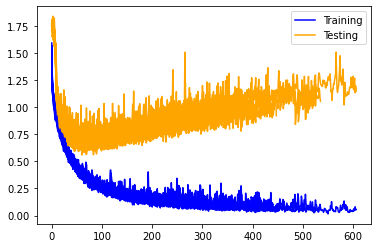

In [8]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

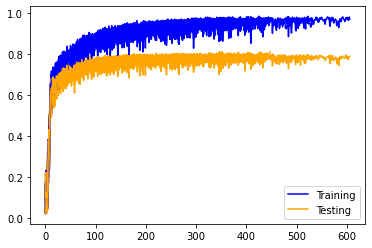

In [9]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

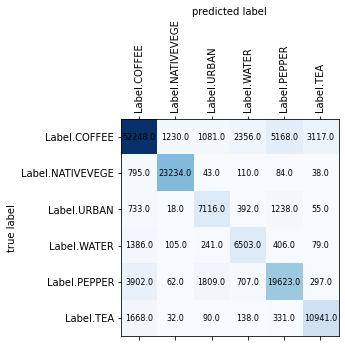

In [10]:
plot_confusion_matrix(conf_matrix, labels)

In [11]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.86030429 0.94137191 0.68554913 0.63717421 0.73083799 0.75314931]
Mean precision:  0.7680644724020634

Recalls:  [0.80134969 0.95597433 0.74497487 0.74575688 0.74329545 0.82886364]
Mean recall:  0.8033691440800642

F-Score:  [0.82978115 0.94861692 0.71402769 0.68720279 0.73701408 0.78919465]
Mean f-score:  0.7843062152628427
